In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pingouin as pg
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

%matplotlib inline 

from platform import python_version
print(python_version())

3.8.5


This code works in two steps.  

Step 1) Read in all the abundance data and clean it up.  
    Specifically, we read in the qPCR for absolute abundance of 16S, and the Braken results for relative abundance.  We join everything, with the mean 16S counts, and compute total abundances, diversity merics etc. 
    
Step 2) Run the GEE and sensisitivity analyeses


## Step 1: Join the DNA data together in one place

In [ ]:
# qPCR data for 16S

In [181]:
url1 = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/qPCR/Plate_1/qPCR_plate1.csv?token=GHSAT0AAAAAABVVFHN4SC7VZTZAXLQ2VK2SYX3EVWA'
url2 = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/qPCR/Plate_2/qPCR_plate2.csv?token=GHSAT0AAAAAABVVFHN53SI2NRX6GNAPZJN2YX3EV7Q'
url3 = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/qPCR/Plate_3/qPCR_plate3.csv?token=GHSAT0AAAAAABVVFHN5NJU6XNV3GOKJQTI4YX3EWJQ'
url4 = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/qPCR/Plate_4/qPCR_plate4.tsv?token=GHSAT0AAAAAABVVFHN5I24QK3FWHOEJCQVIYX3EWUQ'


df1 = pd.read_csv(url1, index_col=0, sep=',')
df2 = pd.read_csv(url2, index_col=0, sep=',')
df3 = pd.read_csv(url3, index_col=0, sep=',')
df4 = pd.read_csv(url4, index_col=0, sep='\t')

In [182]:
df4.columns

Index(['Well96', 'PCR_Replicate', 'Plate', 'OGSampleName', 'SampleName',
       'Donor', 'Condition', 'Replicate', 'DilutionFactor', 'DiluteSampleName',
       'Omit', 'Target', 'Task', 'Dyes', 'Cq', 'Cq.Conf', 'Amp.Score',
       'Amp.Status', 'Annotated', 'Baseline.Start', 'Baseline.End',
       'Curve.Quality', 'Result.Quality.Issues', 'logCopyNumber', 'CopyNumber',
       'SampleNameFull'],
      dtype='object')

In [183]:
10**df4.logCopyNumber * df4.DilutionFactor / 6 - df4.CopyNumber

Well
A5   -1.490116e-08
A6    4.842877e-08
B5    3.725290e-08
C5    2.444722e-09
C6   -1.047738e-09
D5    2.025627e-08
E3    4.237518e-08
E4   -4.284084e-08
F3   -5.587935e-08
G5    1.788139e-07
G6    1.668930e-06
H5   -4.649162e-06
I5   -7.450581e-09
I6   -1.285225e-07
J5   -8.195639e-08
K3   -7.916242e-09
K4   -1.862645e-09
L3   -1.210719e-08
dtype: float64

In [184]:
cols = ['Plate', 
        'Well96',
        'SampleName',
        'Donor',
        'Condition',
        'Replicate',
        'PCR_Replicate',
       'logCopyNumber',
        'CopyNumber']

df_qpcr = pd.concat([df1[cols], df2[cols], df3[cols], df4[cols]])
df_qpcr = df_qpcr[df_qpcr.Donor.str[0] == 'D'].copy()

In [185]:
#how many replicates for each sample?
pd.DataFrame(df_qpcr.groupby('SampleName').size()).groupby(0).size()

0
1     14
2     22
3    174
dtype: int64

In [186]:
df_qpcr.groupby('Donor').SampleName.nunique()

Donor
D01    21
D02    21
D03    21
D04    21
D05    21
D06    21
D07    21
D08    21
D09    21
D10    21
Name: SampleName, dtype: int64

In [187]:
df_qpcr['logCopyNumber'] = np.log10(df_qpcr.CopyNumber)

Text(0.5, 1.0, 'Replicate 2 vs. Replicate 3')

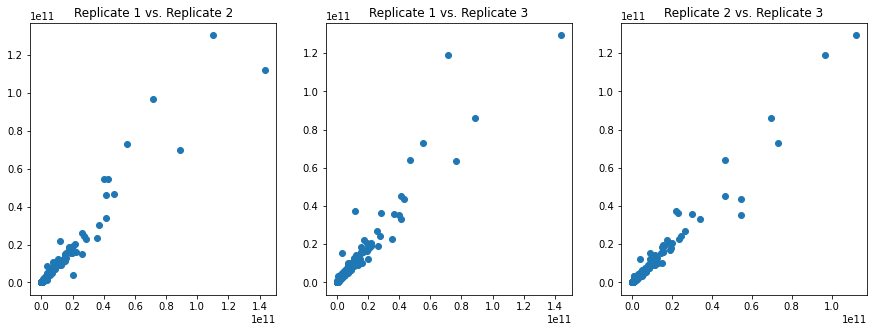

In [188]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)

df_temp = pd.merge(df_qpcr[df_qpcr.PCR_Replicate == 'Rep1'][['SampleName', 'logCopyNumber', 'CopyNumber']],
         df_qpcr[df_qpcr.PCR_Replicate == 'Rep2'][['SampleName', 'logCopyNumber', 'CopyNumber']], on='SampleName')
plt.scatter(df_temp.CopyNumber_x, df_temp.CopyNumber_y)
plt.title('Replicate 1 vs. Replicate 2')


plt.subplot(1,3,2)

df_temp = pd.merge(df_qpcr[df_qpcr.PCR_Replicate == 'Rep1'][['SampleName', 'logCopyNumber', 'CopyNumber']],
         df_qpcr[df_qpcr.PCR_Replicate == 'Rep3'][['SampleName', 'logCopyNumber', 'CopyNumber']], on='SampleName')
plt.scatter(df_temp.CopyNumber_x, df_temp.CopyNumber_y)
plt.title('Replicate 1 vs. Replicate 3')

plt.subplot(1,3,3)

df_temp = pd.merge(df_qpcr[df_qpcr.PCR_Replicate == 'Rep2'][['SampleName', 'logCopyNumber', 'CopyNumber']],
         df_qpcr[df_qpcr.PCR_Replicate == 'Rep3'][['SampleName', 'logCopyNumber', 'CopyNumber']], on='SampleName')
plt.scatter(df_temp.CopyNumber_x, df_temp.CopyNumber_y)
plt.title('Replicate 2 vs. Replicate 3')


Text(0.5, 1.0, 'Replicate 2 vs. Replicate 3')

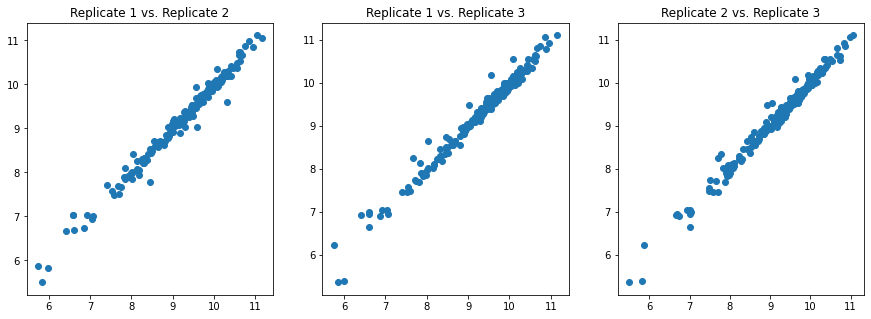

In [189]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)

df_temp = pd.merge(df_qpcr[df_qpcr.PCR_Replicate == 'Rep1'][['SampleName', 'logCopyNumber', 'CopyNumber']],
         df_qpcr[df_qpcr.PCR_Replicate == 'Rep2'][['SampleName', 'logCopyNumber', 'CopyNumber']], on='SampleName')
plt.scatter(df_temp.logCopyNumber_x, df_temp.logCopyNumber_y)
plt.title('Replicate 1 vs. Replicate 2')


plt.subplot(1,3,2)

df_temp = pd.merge(df_qpcr[df_qpcr.PCR_Replicate == 'Rep1'][['SampleName', 'logCopyNumber', 'CopyNumber']],
         df_qpcr[df_qpcr.PCR_Replicate == 'Rep3'][['SampleName', 'logCopyNumber', 'CopyNumber']], on='SampleName')
plt.scatter(df_temp.logCopyNumber_x, df_temp.logCopyNumber_y)
plt.title('Replicate 1 vs. Replicate 3')

plt.subplot(1,3,3)

df_temp = pd.merge(df_qpcr[df_qpcr.PCR_Replicate == 'Rep2'][['SampleName', 'logCopyNumber', 'CopyNumber']],
         df_qpcr[df_qpcr.PCR_Replicate == 'Rep3'][['SampleName', 'logCopyNumber', 'CopyNumber']], on='SampleName')
plt.scatter(df_temp.logCopyNumber_x, df_temp.logCopyNumber_y)
plt.title('Replicate 2 vs. Replicate 3')


Text(0.5, 1.0, 'histogram of ratio of copy number from replicates 1 & 2')

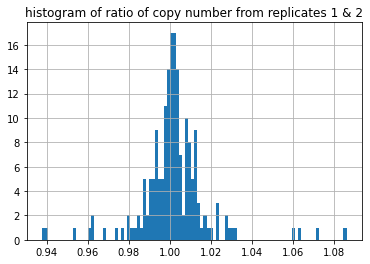

In [190]:
df_temp = pd.merge(df_qpcr[df_qpcr.PCR_Replicate == 'Rep1'][['SampleName', 'logCopyNumber', 'CopyNumber']],
         df_qpcr[df_qpcr.PCR_Replicate == 'Rep2'][['SampleName', 'logCopyNumber', 'CopyNumber']], on='SampleName')
#df_temp = df_temp[df_temp.SampleName.str[0] == 'D']

df_temp['ratio'] = df_temp.logCopyNumber_x / df_temp.logCopyNumber_y
df_temp.ratio.hist(bins=100)
plt.title('histogram of ratio of copy number from replicates 1 & 2')

In [191]:
disagrees = set(df_temp[np.abs(df_temp.ratio - 1) > .02].SampleName)

df_temp2 = pd.merge(pd.merge(df_qpcr[(df_qpcr.PCR_Replicate == 'Rep1') & (df_qpcr.SampleName.isin(disagrees))][['SampleName', 'logCopyNumber']],
         df_qpcr[(df_qpcr.PCR_Replicate == 'Rep2') & (df_qpcr.SampleName.isin(disagrees))][['SampleName', 'logCopyNumber']], on='SampleName'),
        df_qpcr[(df_qpcr.PCR_Replicate == 'Rep3') & (df_qpcr.SampleName.isin(disagrees))][['SampleName', 'logCopyNumber']], on = 'SampleName')

df_temp2.rename(columns = {'logCopyNumber_x': 'Rep1', 'logCopyNumber_y': 'Rep2', 'logCopyNumber': 'Rep3'})

SampleName       Rep1       Rep2       Rep3
0   D07_ZF_R1   9.177784   8.903333   9.100403
1   D03_ZR_R1   7.843204   8.105724   8.149605
2   D01_NF_R1  10.307618   9.610770  10.093069
3   D08_OR_R1   9.551862   9.944828  10.192488
4   D09_NF_R2  10.418079  10.183591  10.282316
5   D01_ZR_R2   7.410220   7.702978   7.458640
6   D09_OF_R2   8.442283   7.771312   8.359034
7   D07_ZH_R2   8.027743   8.422215   8.665929
8   D01_ZH_R2   8.180103   7.943672   8.106838
9   D03_OF_R2   9.579151   9.036571   9.536681
10  D07_OF_R3   9.306666   9.021004   9.220111
11  D03_OF_R3   5.994561   5.832535   5.402555
12  D04_ZF_R3   8.537224   8.712120   8.700794
13  D06_OF_R3  10.076011  10.343627  10.572489
14  D03_ZR_R3   8.026093   7.841270   8.022769
15  D04_OH_R3   9.490284   9.280863   9.448716
16  D10_NF_R3   5.842788   5.496852   5.364126
17  D01_ZR_R3   7.708954   7.499895   7.736991
18  D03_OH_R3   8.796486   8.620732   8.568924
19  D01_ZH_R1   6.409217   6.657261   6.923895
20  D03_ZF_R3   5.745047   5.878920   6.236669
21  D09_ZH_R1   6.592446   7.029519   7.006602
22  D09_ZR_R1   6.598472   7.023705   6.664598

In [193]:
df_16s = df_qpcr[['SampleName', 'Donor', 'Condition', 'Replicate']].drop_duplicates().reset_index().copy()
df_16s = pd.merge(df_16s, pd.DataFrame(df_qpcr.groupby('SampleName').logCopyNumber.median()), on='SampleName')
df_16s['CopyNumberPerMicroliter'] = 10**(df_16s.logCopyNumber) 

df_16s['CopyNumberPerGram'] = df_16s.CopyNumberPerMicroliter * 50/0.062 
df_16s.loc[df_16s.Condition.str[0] == 'Z' ,'CopyNumberPerGram'] = df_16s.CopyNumberPerMicroliter * 50/0.006#0.08 
df_16s.loc[df_16s.Condition.str[0] == 'O' ,'CopyNumberPerGram'] = df_16s.CopyNumberPerMicroliter * 50/0.013#0.037 


df_16s['logCopyNumberPerGram'] = np.log10(df_16s.CopyNumberPerGram)
# if it's a NF, multiply CopyNumberPerMicroliter by (50/0.062) to get copy number per gram
df_16s

Well SampleName Donor Condition Replicate  logCopyNumber  \
0     A1  D07_ZF_R1   D07        ZF        R1       9.100403   
1    A10  D03_ZR_R1   D03        ZR        R1       8.105724   
2    A11  D03_OH_R1   D03        OH        R1       9.822108   
3    A13  D03_ZF_R1   D03        ZF        R1       8.488243   
4    A19  D03_NF_R1   D03        NF        R1       9.699568   
..   ...        ...   ...       ...       ...            ...   
205   C5  D03_ZF_R3   D03        ZF        R3       5.878920   
206   E3  D05_ZH_R3   D05        ZH        R3       6.685014   
207   G5  D07_NF_R3   D07        NF        R3       8.526012   
208   I5  D09_ZH_R1   D09        ZH        R1       7.006602   
209   K3  D09_ZR_R1   D09        ZR        R1       6.664598   

     CopyNumberPerMicroliter  CopyNumberPerGram  logCopyNumberPerGram  
0               1.260095e+09       1.050079e+13             13.021222  
1               1.275628e+08       1.063024e+12             12.026543  
2               6.639082e+09       2.553493e+13             13.407135  
3               3.077816e+08       2.564846e+12             12.409061  
4               5.006887e+09       4.037812e+12             12.606146  
..                       ...                ...                   ...  
205             7.566942e+05       6.305785e+09              9.799739  
206             4.841884e+06       4.034903e+10             10.605833  
207             3.357469e+08       2.707636e+11             11.432590  
208             1.015318e+07       8.460983e+10             10.927421  
209             4.619535e+06       3.849612e+10             10.585417  

[210 rows x 9 columns]

Text(0.5, 0, 'log10 of copy number')

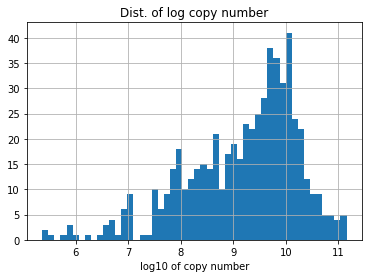

In [194]:
df_qpcr[df_qpcr.Donor.str[0] =='D'].logCopyNumber.hist(bins=50)
plt.title('Dist. of log copy number')
plt.xlabel('log10 of copy number')

Text(0.5, 0, 'log copy number / gram')

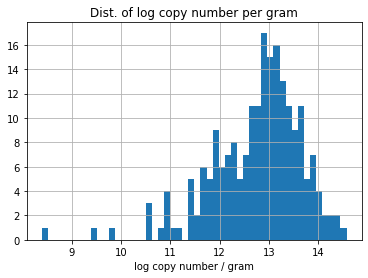

In [195]:
df_16s.logCopyNumberPerGram.hist(bins=50)
plt.title('Dist. of log copy number per gram')
plt.xlabel('log copy number / gram')

In [ ]:
# ANOVA for variation in 16S counts

Text(0.5, 1.0, '')

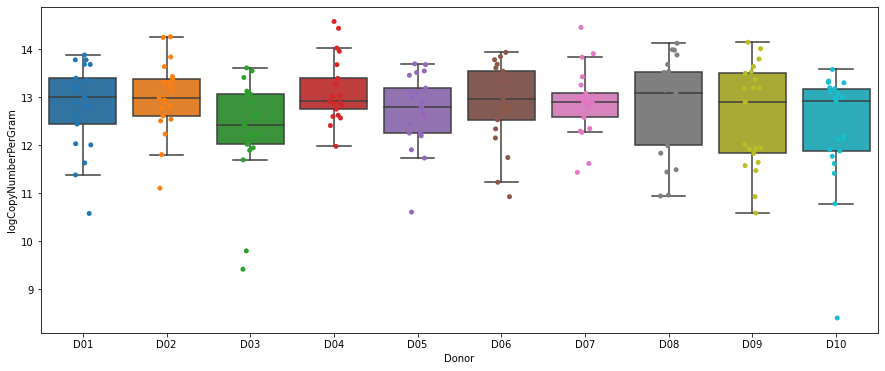

In [196]:
order = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10']

plt.figure(figsize=(15,6))
sns.boxplot(x='Donor', y='logCopyNumberPerGram', data=df_16s, showfliers=False, order=order)
sns.stripplot(x='Donor', y='logCopyNumberPerGram', data=df_16s, order=order)
plt.title('', size=16)

In [197]:
from statsmodels.formula.api import ols
model = ols('logCopyNumberPerGram ~ C(Donor)', data=df_16s).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq     df         F    PR(>F)
C(Donor)   13.187656    9.0  1.780535  0.073827
Residual  164.590392  200.0       NaN       NaN

Text(0.5, 1.0, '')

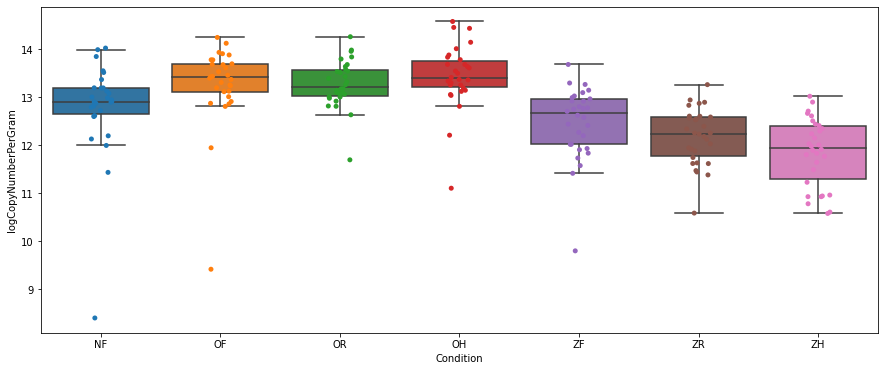

In [198]:
order = ['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH']

plt.figure(figsize=(15,6))
sns.boxplot(x='Condition', y='logCopyNumberPerGram', data=df_16s, showfliers=False, order=order)
sns.stripplot(x='Condition', y='logCopyNumberPerGram', data=df_16s, order=order)
plt.title('', size=16)

In [199]:
from statsmodels.formula.api import ols
model = ols('logCopyNumberPerGram ~ C(Condition)', data=df_16s).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq     df          F        PR(>F)
C(Condition)   66.879226    6.0  20.403708  1.221689e-18
Residual      110.898822  203.0        NaN           NaN

In [200]:
df_16s['Donor_Condition'] = df_16s.Donor + '_' + df_16s.Condition

Text(0.5, 1.0, '')

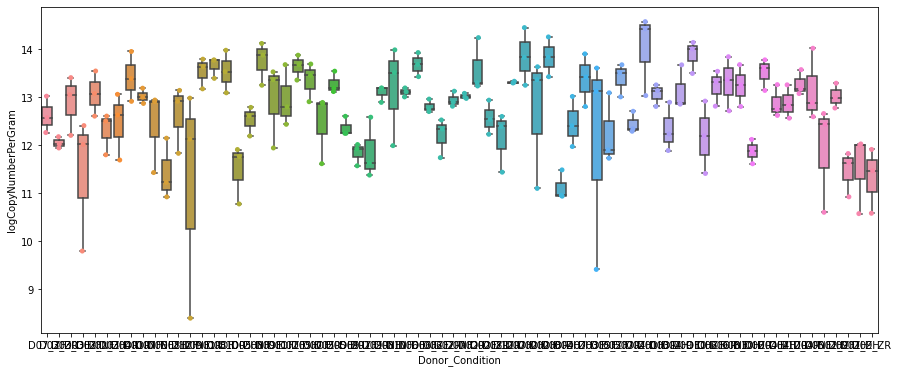

In [201]:
#order = ['NF', 'OH', 'OR', 'OH', 'ZF', 'ZR', 'ZH']

plt.figure(figsize=(15,6))
sns.boxplot(x='Donor_Condition', y='logCopyNumberPerGram', data=df_16s, showfliers=False)
sns.stripplot(x='Donor_Condition', y='logCopyNumberPerGram', data=df_16s)
plt.title('', size=16)

In [202]:
from statsmodels.formula.api import ols
model = ols('logCopyNumberPerGram ~ C(Donor) * C(Condition)', data=df_16s).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq     df          F        PR(>F)
C(Donor)               13.187656    9.0   3.161574  1.668148e-03
C(Condition)           66.879226    6.0  24.050175  1.971870e-19
C(Donor):C(Condition)  32.825348   54.0   1.311577  1.056180e-01
Residual               64.885818  140.0        NaN           NaN

In [203]:
# read in DNA relative abundance data

In [204]:
url_genus = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/DNA/2.kraken/kraken2_classification/processed_results_krakenonly/taxonomy_matrices/kraken_genus_reads.txt?token=GHSAT0AAAAAABVVFHN4SERNDD2QHESREKH2YX3EZ4Q'
url_phylum = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/DNA/2.kraken/kraken2_classification/processed_results_krakenonly/taxonomy_matrices/kraken_phylum_reads.txt?token=GHSAT0AAAAAABVVFHN4ZK3IFQOBS4H6454KYX3E2IA'
url_kingdom = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/DNA/2.kraken/kraken2_classification/processed_results_krakenonly/taxonomy_matrices/kraken_kingdom_reads.txt?token=GHSAT0AAAAAABVVFHN46NTI6Y64XZWJSNESYX3E2SQ'

df_genus= pd.read_csv(url_genus, index_col=0, sep='\t')
df_phylum = pd.read_csv(url_phylum, index_col=0, sep='\t')
df_kingdom = pd.read_csv(url_kingdom, index_col=0, sep='\t')

df_genus = df_genus.T
df_phylum = df_phylum.T
df_kingdom = df_kingdom.T



In [205]:
#a few dumb little tweaks for the names

df_genus.rename(columns = {'Podoviridae: environmental samples (321841)': 'Podoviridae: environmental samples',
                          'Candida (5475)': 'Candida 1',
                           'Viruses: environmental samples (186616)': 'Viruses: environmental samples',
                           'Candida (1535326)': 'Candida 2',
                           'Nitrospira (1234)':'Nitrospira',
                          'Ponticoccus (983507)': 'Ponticoccus 1',
                          'Ponticoccus (519422)': 'Ponticoccus 2'}, inplace=True)

df_phylum.columns = [c.split(' (')[0] for c in list(df_phylum.columns)]



In [206]:
df_genus.sum().sum()

8292308718

In [207]:
df_phylum.sum().sum()

8292308718

In [208]:
df_kingdom.sum().sum()

8292308718

In [209]:
df_genus.sum().sort_values()

Attisvirus                               1
Fabavirus                                1
unclassified Genomoviridae               1
Teschovirus                              1
Betterkatzvirus                          1
                                   ...    
Ruminococcus                     335898205
Faecalibacterium                 561832758
unclassified                     578721126
Bacteroides                     1685942900
classified at a higher level    1839372253
Length: 3567, dtype: int64

In [210]:
df_phylum.sum().sort_values()

Candidatus Huberarchaea                  3
Candidatus Parvarchaeota                49
Candidatus Veblenbacteria               60
Candidatus Brennerbacteria              68
Coprothermobacterota                    76
                                   ...    
classified at a higher level     350921479
Proteobacteria                   381018626
unclassified                     578721126
Bacteroidetes                   2677467726
Firmicutes                      3974961319
Length: 174, dtype: int64

In [211]:
df_kingdom.sum()

classified at a higher level      14527699
unclassified                     578721126
Viruses                            9628689
Metazoa                              90462
Fungi                             10161148
Bacteria                        7678578933
Archaea                             600661
dtype: int64

In [212]:
df_taxonomy = pd.read_excel('genbank_taxonomy_array.xlsm')

df_taxonomy.loc[df_taxonomy.taxon_id == 983507, 'genus'] = 'Ponticoccus 1'
df_taxonomy.loc[df_taxonomy.taxon_id == 519422, 'genus'] = 'Ponticoccus 2'

df_taxonomy.loc[df_taxonomy.taxon_id == 5475, 'genus'] = 'Candida 1'
df_taxonomy.loc[df_taxonomy.taxon_id == 1535326, 'genus'] = 'Candida 2'

df_bubbleup = df_taxonomy[['genus', 'phylum', 'kingdom']].drop_duplicates().reset_index(drop=True).copy()

In [92]:
if 0:
    url_extra_dict_genus = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/qPCR/genus_copynumber_table.tsv?token=GHSAT0AAAAAABVVFHN4J53SWJF3QNGVB3QSYV5DTLA'
    url_extra_dict_phylum = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/qPCR/phylum_copynumber_table.tsv?token=GHSAT0AAAAAABVVFHN5AZZTUKERIXULRB4UYV5DTTA'

    df_extra_dict_genus = pd.read_csv(url_extra_dict_genus, index_col=0, sep='\t')
    df_extra_dict_phylum = pd.read_csv(url_extra_dict_phylum, index_col=0, sep='\t')

    df_temp1 = pd.DataFrame([], columns=['genus', 'phylum', 'kingdom'])
    df_temp2 = pd.DataFrame([], columns=['genus', 'phylum', 'kingdom'])

    df_temp1['genus'] = df_extra_dict_genus.Genus
    df_temp1['kingdom'] = df_extra_dict_genus.kingdom

    df_temp2['phylum'] = df_extra_dict_phylum.Phylum
    df_temp2['kingdom'] = df_extra_dict_phylum.kingdom

    df_bubbleup = pd.concat([df_bubtemp[['genus', 'phylum', 'kingdom']], 
                             df_temp1[~df_temp1.genus.isin(set(df_bubtemp.genus))],
                             df_temp2[~df_temp2.phylum.isin(set(df_bubtemp.phylum))]])

    df_bubbleup_tweaks = pd.concat([
                             df_temp1[~df_temp1.genus.isin(set(df_bubtemp.genus))],
                             df_temp2[~df_temp2.phylum.isin(set(df_bubtemp.phylum))]])

In [213]:
# every genus maps to 0 or 1 phyla except for Ponticoccus which maps to two different genuses
df_bubbleup.groupby('genus')['phylum'].nunique().sort_values()

genus
unclassified virophages    0
Erythroparvovirus          0
Tabernariusvirus           0
Erskinevirus               0
Errantivirus               0
                          ..
Hormoscilla                1
Hortaea                    1
Hoyosella                  1
Methanoculleus             1
Ponticoccus                2
Name: phylum, Length: 4286, dtype: int64

In [214]:
#and every phylum rolls up to a unique kingdom.  Phew!
df_bubbleup.groupby('phylum')['kingdom'].nunique().sort_values()

phylum
Acidobacteria                      1
Candidatus Terrybacteria           1
Candidatus Thorarchaeota           1
Candidatus Uhrbacteria             1
Candidatus Veblenbacteria          1
                                  ..
Candidatus Heimdallarchaeota       1
Candidatus Helarchaeota            1
Candidatus Huberarchaea            1
Candidatus Glassbacteria           1
candidate division Zixibacteria    1
Name: kingdom, Length: 173, dtype: int64

In [215]:
df_temp = df_genus.T.copy()
df_temp['genus'] = df_temp.index

df_temp = pd.merge(df_temp, df_bubbleup[~df_bubbleup.genus.isna()], on='genus', how='left')
df_temp['tot_count'] = df_temp.iloc[:,:-3].T.sum()

In [216]:
#should be 0
df_genus.T.shape[0] - df_temp.shape[0]

0

In [217]:
#should also be 0
df_genus.sum().T.sum() - df_temp.tot_count.sum()

0

In [218]:
# which ones are in the genus table but not in our dictionary?
#not much!  Just 4 genus
#fixed by hand

df_temp[(df_temp.phylum.isna()) & (df_temp.kingdom.isna())][['genus', 'tot_count']]

genus   tot_count
0  classified at a higher level  1839372253
1                  unclassified   578721126

In [219]:
#Of the very few mismatches, we've got a weird feature where the genus 'Ponticoccus' maps to two different phyla.
df_taxonomy[df_taxonomy.taxon_id.isin([321841, 5475,983507,519422,5475])]

Taxon  taxon_id ignore_me   kingdom  \
10791  Podoviridae: environmental samples    321841      root   Viruses   
23663                             Candida      5475      root     Fungi   
33256                         Ponticoccus    983507      root  Bacteria   
49341                         Ponticoccus    519422      root  Bacteria   

               phylum                class                order  \
10791             NaN                  NaN         Caudovirales   
23663      Ascomycota      Saccharomycetes    Saccharomycetales   
33256  Proteobacteria  Alphaproteobacteria      Rhodobacterales   
49341  Actinobacteria       Actinobacteria  Propionibacteriales   

                    family                                genus species strain  
10791           Podoviridae  Podoviridae: environmental samples     NaN    NaN  
23663                   NaN                           Candida 1     NaN    NaN  
33256      Rhodobacteraceae                       Ponticoccus 1     NaN    NaN  
49341  Propionibacteriaceae                       Ponticoccus 2     NaN    NaN

In [220]:
#What's the difference between the manually rolled up phylum counts and the phylum read table?

df_temp1 = pd.DataFrame(df_temp.groupby('phylum').tot_count.sum()).rename(columns={'tot_count' : 'Manual Rollup'})
df_temp2 = pd.DataFrame(df_phylum.sum()).rename(columns={0 : 'Phylum Table'})

df_rollup_diff = pd.merge(df_temp1, df_temp2, left_index=True, right_index=True, how='outer').fillna(0)
df_rollup_diff['difference'] = df_rollup_diff['Phylum Table'] - df_rollup_diff['Manual Rollup'] 

df_rollup_diff = df_rollup_diff[~df_rollup_diff.index.isin(['unclassified', 'classified at a higher level'])]

In [221]:
df_rollup_diff

Manual Rollup  Phylum Table  difference
Acidobacteria                         391329.0        412734     21405.0
Actinobacteria                     271570382.0     291313059  19742677.0
Aquificae                              11836.0         12635       799.0
Armatimonadetes                        56576.0         58130      1554.0
Ascomycota                           5891750.0       6446477    554727.0
...                                        ...           ...         ...
candidate division FCPU426                 0.0          4110      4110.0
candidate division NC10                 1661.0          1686        25.0
candidate division WOR-3                   0.0          6962      6962.0
candidate division WWE3                    0.0          5796      5796.0
candidate division Zixibacteria            0.0          8512      8512.0

[172 rows x 3 columns]

In [222]:
#Here's 20 rows of this thing
df_rollup_diff.sort_index()[0:20].astype('int64')

Manual Rollup  Phylum Table  difference
Acidobacteria                       391329        412734       21405
Actinobacteria                   271570382     291313059    19742677
Aquificae                            11836         12635         799
Armatimonadetes                      56576         58130        1554
Ascomycota                         5891750       6446477      554727
Bacteroidetes                   2330360263    2677467726   347107463
Balneolaeota                         13332         13752         420
Basidiomycota                      2187558       2263697       76139
Blastocladiomycota                    6116          6116           0
Caldiserica                            871          1084         213
Calditrichaeota                       4846          4846           0
Candidatus Abawacabacteria               0          1419        1419
Candidatus Adlerbacteria                 0           326         326
Candidatus Aenigmarchaeota             611           611           0
Candidatus Altiarchaeota              1734          1737           3
Candidatus Amesbacteria                  0           805         805
Candidatus Aminicenantes             27171         27171           0
Candidatus Andersenbacteria              0          1323        1323
Candidatus Atribacteria               4428          4428           0
Candidatus Azambacteria                  0          1242        1242

In [223]:
#this thing should be equal the thing below
df_rollup_diff.difference.sum() - (df_genus['classified at a higher level'].sum() - df_phylum['classified at a higher level'].sum() )

16757510.0

In [224]:
df_temp[(df_temp.phylum.isna()) & (~df_temp.genus.isin(['classified at a higher level', 'unclassified']))].tot_count.sum()

16757510

In [225]:
#cases where manual rollup is 0

#these are cases where the lookup table has a phylum but no genus.
df_rollup_diff[df_rollup_diff['Manual Rollup'] == 0].sort_values(by='difference')[-20:]

Manual Rollup  Phylum Table  difference
Candidatus Berkelbacteria                  0.0          3812      3812.0
candidate division FCPU426                 0.0          4110      4110.0
Candidatus Woesearchaeota                  0.0          4636      4636.0
Candidatus Uhrbacteria                     0.0          5172      5172.0
candidate division WWE3                    0.0          5796      5796.0
Candidatus Woesebacteria                   0.0          5975      5975.0
Candidatus Levybacteria                    0.0          6475      6475.0
Candidatus Wolfebacteria                   0.0          6482      6482.0
candidate division WOR-3                   0.0          6962      6962.0
Candidatus Nomurabacteria                  0.0          7202      7202.0
Candidatus Falkowbacteria                  0.0          7906      7906.0
candidate division Zixibacteria            0.0          8512      8512.0
Candidatus Magasanikbacteria               0.0          9050      9050.0
Candidatus Poribacteria                    0.0         10231     10231.0
Candidatus Portnoybacteria                 0.0         10672     10672.0
Candidatus Eisenbacteria                   0.0         10822     10822.0
Candidatus Roizmanbacteria                 0.0         12226     12226.0
Candidatus Marinimicrobia                  0.0         14803     14803.0
Candidatus Moranbacteria                   0.0         22401     22401.0
Candidatus Rokubacteria                    0.0         57091     57091.0

In [226]:
#cases where phylum table is 0

df_rollup_diff[df_rollup_diff['Phylum Table'] == 0]

Empty DataFrame
Columns: [Manual Rollup, Phylum Table, difference]
Index: []

In [227]:
#OK looking good, now let's do the rollup.  Careful with the NULLs!

In [228]:
ttt = df_rollup_diff.copy()

ttt1 = pd.merge(ttt[[]], df_phylum.T, left_index = True, right_index=True, how='left').fillna(0)
ttt2 = pd.merge(ttt[[]], df_temp.groupby('phylum').sum().iloc[:,:-1], left_index = True, right_index=True, how='left').fillna(0)

df_phylum_no_genus = ttt1 - ttt2
df_phylum_no_genus['genus'] = 'null'
df_phylum_no_genus['phylum'] = df_phylum_no_genus.index

df_phylum_no_genus = pd.merge( df_phylum_no_genus, df_bubbleup[['phylum', 'kingdom']].drop_duplicates(), on = 'phylum')

In [229]:
df_pg = pd.concat([df_temp.iloc[:, :-1].fillna('null'),df_phylum_no_genus]).reset_index(drop=True)

#df_pg.loc[df_pg.genus == 'classified at a higher level', df_pg.columns[:-3]] = df_phylum.T.loc[df_phylum.T.index == 'classified at a higher level', df_pg.columns[:-3]]

In [230]:
df_stupid = df_phylum.T.loc[df_phylum.T.index == 'classified at a higher level'].copy()
df_stupid['genus'] = np.nan
df_stupid['phylum'] = np.nan
df_stupid['kingdom'] = np.nan

df_stupid.reset_index(drop=True, inplace=True)

df_stupider = pd.DataFrame(df_temp[(df_temp.phylum.isna()) & (~df_temp.genus.isin(['classified at a higher level', 'unclassified']))][df_stupid.columns].sum()).T

df_stupider['genus'] = np.nan
df_stupider['phylum'] = np.nan
df_stupider['kingdom'] = np.nan

df_stupid = df_stupid - df_stupider

df_stupid['genus'] = 'null'
df_stupid['phylum'] = 'classified at a higher level'
df_stupid['kingdom'] = 'null'

df_pg.loc[0] = df_stupid.loc[0]

In [231]:
df_temp[(df_temp.phylum.isna()) & (~df_temp.genus.isin(['classified at a higher level', 'unclassified']))].groupby('kingdom').tot_count.sum()

kingdom
Archaea         5644
Bacteria      409428
Fungi           7681
Viruses     16334757
Name: tot_count, dtype: int64

In [232]:
#should be 0
df_genus.sum().T.sum() - df_pg.sum()[:-3].sum()

0.0

In [233]:
#should also be 0
df_kingdom['unclassified'].sum().sum() - df_pg[df_pg.genus == 'unclassified'].sum()[:-3].sum()

0.0

In [234]:
df_pg[df_pg.kingdom == 'null']

D04-ZR-R1  D10-NF-R1  NCO-B2-R1  D02-OF-R1  D02-OF-R3  D06-ZR-R2  \
0   626060.0  1343249.0       74.0  2438248.0  1509977.0   898681.0   
1  6471896.0  1654910.0      287.0  2973101.0  2353816.0  1103825.0   

   D06-ZF-R2  D09-ZH-R2  D01-ZR-R3  D10-OH-R1  ...  D06-OF-R1  D03-ZR-R1  \
0   886377.0   704459.0   586079.0  4692140.0  ...  3329178.0  1735362.0   
1  1256495.0  2580747.0  1326495.0  5639370.0  ...  2363768.0  5174207.0   

   D09-ZR-R3  D01-ZF-R3  D03-ZH-R3  D07-OH-R2  D09-NF-R2         genus  \
0   704908.0  1242680.0   952127.0   639166.0   683381.0          null   
1  2264921.0  1949529.0  2991735.0  1049433.0  2236656.0  unclassified   

                         phylum  kingdom  
0  classified at a higher level     null  
1                          null     null  

[2 rows x 237 columns]

In [235]:
df_kingdom.columns[2:]

Index(['Viruses', 'Metazoa', 'Fungi', 'Bacteria', 'Archaea'], dtype='object')

In [236]:
sample_cols = df_kingdom.T.columns
kingdom_cols = df_kingdom.columns[2:]


df_ttking = df_kingdom.T[df_kingdom.T.index.isin(kingdom_cols)].copy()

df_ttroll = df_pg.groupby('kingdom').sum()[sample_cols]
df_ttroll = df_ttroll[df_ttroll.index.isin(kingdom_cols)].copy()
df_ttroll = pd.merge(df_ttking[[]], df_ttroll, left_index=True, right_index=True, how='left').fillna(0)

#df_tttweak = pd.merge(df_pg, df_bubbleup_tweaks, on='genus').groupby('kingdom_x').sum()[sample_cols]
#df_tttweak = pd.merge(df_ttking[[]], df_tttweak, left_index=True, right_index=True, how='left').fillna(0)

df_unclassified_kingdoms = df_ttking - df_ttroll #

df_unclassified_kingdoms['genus'] = 'null'
df_unclassified_kingdoms['phylum'] = 'null'
df_unclassified_kingdoms['kingdom'] = df_unclassified_kingdoms.index

df_unclassified_kingdoms.reset_index(drop=True, inplace=True)
df_unclassified_kingdoms

D04-ZR-R1  D10-NF-R1  NCO-B2-R1  D02-OF-R1  D02-OF-R3  D06-ZR-R2  \
0    22832.0     3904.0        0.0  -193551.0   -72051.0   -20437.0   
1     1182.0      268.0        2.0      511.0      411.0      181.0   
2    10084.0     1477.0        1.0     3947.0     2572.0      624.0   
3   533573.0  1305757.0       41.0  2529678.0  1512009.0   894546.0   
4       94.0       22.0        0.0       10.0        3.0       10.0   

   D06-ZF-R2  D09-ZH-R2  D01-ZR-R3  D10-OH-R1  ...  D06-OF-R1  D03-ZR-R1  \
0    -5102.0   -24379.0     5908.0    14344.0  ...    -5250.0  -175739.0   
1      203.0      401.0      301.0      922.0  ...      657.0      381.0   
2      743.0     1539.0     1117.0     4675.0  ...     1753.0     3015.0   
3   849720.0   699979.0   557839.0  4557078.0  ...  3238130.0  1838316.0   
4       14.0        4.0        7.0       32.0  ...       30.0       17.0   

   D09-ZR-R3  D01-ZF-R3  D03-ZH-R3  D07-OH-R2  D09-NF-R2  genus  phylum  \
0   -20240.0    -4158.0   -63787.0     1866.0    -9813.0   null    null   
1      355.0      290.0      258.0      221.0      333.0   null    null   
2     1352.0     1240.0     2219.0      971.0     1108.0   null    null   
3   699706.0  1211728.0   978353.0   605728.0   659862.0   null    null   
4        3.0        5.0       13.0        4.0        6.0   null    null   

    kingdom  
0   Viruses  
1   Metazoa  
2     Fungi  
3  Bacteria  
4   Archaea  

[5 rows x 237 columns]

In [237]:
df_ttking -  df_temp.groupby('kingdom').sum()[sample_cols]

D04-ZR-R1  D10-NF-R1  NCO-B2-R1  D02-OF-R1  D02-OF-R3  D06-ZR-R2  \
Archaea       515.0       89.0        2.0      129.0      134.0       51.0   
Bacteria  5947062.0  8840685.0      370.0  9813519.0  8248935.0  3225336.0   
Fungi       22364.0     3115.0        2.0     8025.0     5460.0     1471.0   
Metazoa         NaN        NaN        NaN        NaN        NaN        NaN   
Viruses     22832.0     3904.0        0.0  -193551.0   -72051.0   -20437.0   

          D06-ZF-R2  D09-ZH-R2  D01-ZR-R3   D10-OH-R1  ...  D10-OF-R3  \
Archaea        58.0      139.0       79.0       230.0  ...       51.0   
Bacteria  4753562.0  4507257.0  5790578.0  26111114.0  ...  6515738.0   
Fungi        1727.0     4252.0     2621.0     10361.0  ...     2190.0   
Metazoa         NaN        NaN        NaN         NaN  ...        NaN   
Viruses     -5102.0   -24379.0     5908.0     14344.0  ...     2567.0   

           D06-ZF-R1   D05-ZF-R1   D06-OF-R1   D03-ZR-R1  D09-ZR-R3  \
Archaea        148.0       224.0       114.0       199.0      134.0   
Bacteria  11820430.0  15096394.0  11568117.0  16192674.0  4841610.0   
Fungi         4460.0     12489.0      3874.0      7653.0     3739.0   
Metazoa          NaN         NaN         NaN         NaN        NaN   
Viruses     -22735.0    -52148.0     -5250.0   -175739.0   -20240.0   

          D01-ZF-R3  D03-ZH-R3  D07-OH-R2  D09-NF-R2  
Archaea       128.0      119.0       68.0      106.0  
Bacteria  6509205.0  9916999.0  4436913.0  5426869.0  
Fungi        2757.0     5352.0     2205.0     3062.0  
Metazoa         NaN        NaN        NaN        NaN  
Viruses     -4158.0   -63787.0     1866.0    -9813.0  

[5 rows x 234 columns]

In [238]:
df_ttking.T.sum() - df_ttroll.T.sum() 

Viruses      -6707081.0
Metazoa         90462.0
Fungi          506874.0
Bacteria    325743094.0
Archaea          2921.0
dtype: float64

In [239]:
(df_phylum['classified at a higher level']/df_phylum.T.sum() * 100).sort_values()[-20:]

D10-ZH-R2     5.736390
D10-OH-R2     5.764811
D06-OF-R2     5.774421
D10-OH-R3     5.841602
NCO-B4-R1     5.917160
D10-ZH-R1     5.925345
D10-OR-R2     6.029396
D10-OF-R1     6.119218
PCO-B4-R3     9.803344
PCO-B1-R3    10.715149
PCO-B3-R3    11.368882
PCO-B4-R1    16.444575
PCO-B2-R3    16.682912
PCO-B4-R2    16.718225
PCO-B3-R2    16.872595
PCO-B1-R1    17.413637
PCO-B2-R1    17.425993
PCO-B1-R2    17.546919
PCO-B3-R1    17.592554
PCO-B2-R2    18.634313
dtype: float64

In [240]:
df_phylum['classified at a higher level'] - df_kingdom['classified at a higher level']  - df_stupider[sample_cols].T[0].astype('int64')

D04-ZR-R1     567765
D10-NF-R1    1311428
NCO-B2-R1         44
D02-OF-R1    2340595
D02-OF-R3    1442944
              ...   
D09-ZR-R3     681176
D01-ZF-R3    1209105
D03-ZH-R3     917056
D07-OH-R2     608790
D09-NF-R2     651496
Length: 234, dtype: int64

In [241]:
(df_ttking.sum() - df_ttroll.sum()  ).astype('int64')

D04-ZR-R1     567765
D10-NF-R1    1311428
NCO-B2-R1         44
D02-OF-R1    2340595
D02-OF-R3    1442944
              ...   
D09-ZR-R3     681176
D01-ZF-R3    1209105
D03-ZH-R3     917056
D07-OH-R2     608790
D09-NF-R2     651496
Length: 234, dtype: int64

In [242]:
df_tweak_2 = df_temp[(df_temp.phylum.isna()) 
        & (~df_temp.genus.isin(['classified at a higher level', 'unclassified']))].groupby('kingdom').sum()[sample_cols]
df_tweak_2 = pd.merge(df_ttking[[]], df_tweak_2, left_index=True, right_index=True, how='left').fillna(0)

In [243]:
df_ttking - df_ttroll

D04-ZR-R1  D10-NF-R1  NCO-B2-R1  D02-OF-R1  D02-OF-R3  D06-ZR-R2  \
Viruses     22832.0     3904.0        0.0  -193551.0   -72051.0   -20437.0   
Metazoa      1182.0      268.0        2.0      511.0      411.0      181.0   
Fungi       10084.0     1477.0        1.0     3947.0     2572.0      624.0   
Bacteria   533573.0  1305757.0       41.0  2529678.0  1512009.0   894546.0   
Archaea        94.0       22.0        0.0       10.0        3.0       10.0   

          D06-ZF-R2  D09-ZH-R2  D01-ZR-R3  D10-OH-R1  ...  D10-OF-R3  \
Viruses     -5102.0   -24379.0     5908.0    14344.0  ...     2567.0   
Metazoa       203.0      401.0      301.0      922.0  ...      224.0   
Fungi         743.0     1539.0     1117.0     4675.0  ...      994.0   
Bacteria   849720.0   699979.0   557839.0  4557078.0  ...  1443963.0   
Archaea        14.0        4.0        7.0       32.0  ...        6.0   

          D06-ZF-R1  D05-ZF-R1  D06-OF-R1  D03-ZR-R1  D09-ZR-R3  D01-ZF-R3  \
Viruses    -22735.0   -52150.0    -5250.0  -175739.0   -20240.0    -4158.0   
Metazoa       549.0      802.0      657.0      381.0      355.0      290.0   
Fungi        1984.0     4428.0     1753.0     3015.0     1352.0     1240.0   
Bacteria  2403263.0  2249757.0  3238130.0  1838316.0   699706.0  1211728.0   
Archaea        30.0       13.0       30.0       17.0        3.0        5.0   

          D03-ZH-R3  D07-OH-R2  D09-NF-R2  
Viruses    -63787.0     1866.0    -9813.0  
Metazoa       258.0      221.0      333.0  
Fungi        2219.0      971.0     1108.0  
Bacteria   978353.0   605728.0   659862.0  
Archaea        13.0        4.0        6.0  

[5 rows x 234 columns]

In [ ]:
#join on 16S copy number

In [244]:
url_counts = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/qPCR/16Scopynum/taxonomic_copy_number.tsv?token=GHSAT0AAAAAABVVFHN5CWJNI5AP3NZPXI5UYX3E4PQ'
df_count2  = pd.read_csv(url_counts, index_col=0, sep='\t')

In [245]:
df_count2[df_count2.name == 'Bacteria']

name  mean16S
taxid                   
2      Bacteria     1.94

In [246]:
kingdom_cols

Index(['Viruses', 'Metazoa', 'Fungi', 'Bacteria', 'Archaea'], dtype='object')

In [247]:
df_temp2 = pd.merge(df_pg, df_count2, left_on = 'genus', right_on = 'name', how='left')
df_temp3 = pd.DataFrame(df_temp2.groupby(['genus', 'phylum', 'kingdom']).mean16S.mean()).reset_index()
df_temp3.loc[df_temp3.kingdom.isin(['Viruses', 'Metazoa', 'Fungi', 'Archaea']), 'mean16S'] = 0

df_tt1 = df_temp3[~df_temp3.mean16S.isna()].copy()

df_temp4 = pd.merge(df_temp3[df_temp3.mean16S.isna()][['genus', 'phylum', 'kingdom']], df_count2, left_on = 'phylum', right_on = 'name', how='left')
df_temp5 = pd.DataFrame(df_temp4.groupby(['genus', 'phylum', 'kingdom']).mean16S.mean()).reset_index()

df_tt2 = df_temp5[~df_temp5.mean16S.isna()].copy()

df_temp6 = pd.merge(df_temp5[df_temp5.mean16S.isna()][['genus', 'phylum', 'kingdom']], df_count2, left_on = 'kingdom', right_on = 'name', how='left')
df_temp7 = pd.DataFrame(df_temp6.groupby(['genus', 'phylum', 'kingdom']).mean16S.mean()).reset_index()

df_tt3 = df_temp7[~df_temp7.mean16S.isna()].copy()

df_final = pd.merge(df_pg, pd.concat([df_tt1,df_tt2,df_tt3]), on = ['genus', 'phylum', 'kingdom'], how='left')

In [248]:
df_final[['D04-ZR-R1', 'genus', 'phylum', 'kingdom', 'mean16S']].sort_values(by='D04-ZR-R1', ascending = False)[0:10]

D04-ZR-R1             genus          phylum   kingdom  mean16S
1     6471896.0      unclassified            null      null      NaN
3148  5651234.0        Prevotella   Bacteroidetes  Bacteria     4.10
3708  4158559.0              null      Firmicutes  Bacteria     4.32
2557  3887587.0  Faecalibacterium      Firmicutes  Bacteria     6.00
2477  3543998.0       Coprococcus      Firmicutes  Bacteria     4.32
2732  1798863.0   Bifidobacterium  Actinobacteria  Bacteria     3.34
2443  1783740.0       Clostridium      Firmicutes  Bacteria     9.19
2549  1527881.0     Oscillibacter      Firmicutes  Bacteria     3.00
3136  1419967.0       Bacteroides   Bacteroidetes  Bacteria     4.66
2474  1301104.0         Roseburia      Firmicutes  Bacteria     5.00

In [249]:
df_final[df_final.mean16S > 0].mean16S.mean()

3.0917406639003855

In [250]:
dfdumb = df_final[#(df_final.kingdom == 'Bacteria') & 
                  (~df_final['mean16S'].isna())]

simp = dfdumb[sample_cols].T.dot(dfdumb['mean16S'])/dfdumb[sample_cols].sum()

Text(0.5, 1.0, 'Histo: Avg microbial 16S count')

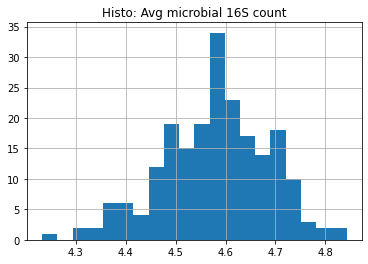

In [251]:
simp[(simp.index.str[0] == 'D') & (simp.index != 'D03-ZH-R2')].hist(bins=20)
plt.title('Histo: Avg microbial 16S count')

In [252]:
df_temp = pd.DataFrame(simp, columns = ['mean_16s_count']).reset_index()
df_temp['SampleName'] = df_temp['index'].str.replace('-', '_')

df_count = pd.merge(df_16s, df_temp[['SampleName', 'mean_16s_count']], left_on = 'SampleName', right_on='SampleName')
df_count['MicrobesPerGram'] = df_count.CopyNumberPerGram / df_count.mean_16s_count
df_count['logMicrobesPerGram'] = np.log10(df_count.MicrobesPerGram)

Text(0.5, 0, 'Log10 of microbes / dry gram')

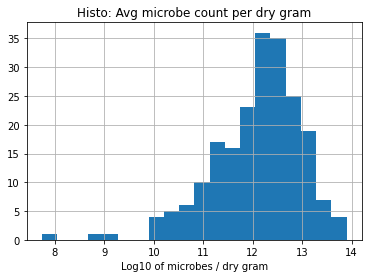

In [253]:
df_count.logMicrobesPerGram.hist(bins=20)
plt.title('Histo: Avg microbe count per dry gram')
plt.xlabel('Log10 of microbes / dry gram')

Text(0.5, 1.0, '')

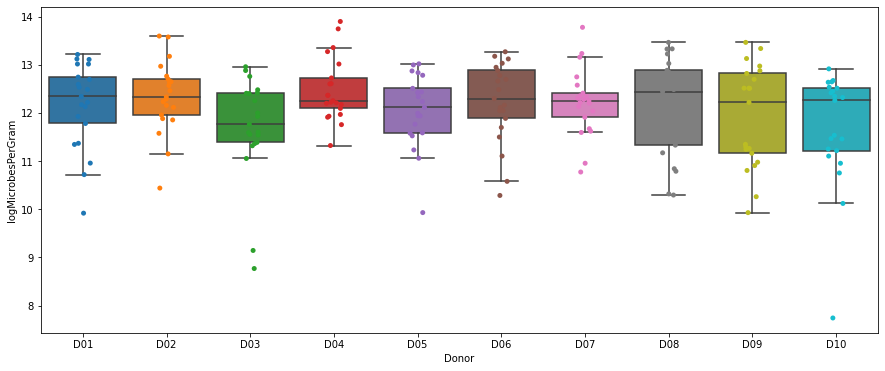

In [254]:
order = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10']

plt.figure(figsize=(15,6))
sns.boxplot(x='Donor', y='logMicrobesPerGram', data=df_count, showfliers=False, order=order)
sns.stripplot(x='Donor', y='logMicrobesPerGram', data=df_count, order=order)
plt.title('', size=16)

In [255]:
from statsmodels.formula.api import ols
model = ols('logMicrobesPerGram ~ C(Donor)', data=df_count).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq     df         F    PR(>F)
C(Donor)   12.776786    9.0  1.734313  0.083276
Residual  163.712418  200.0       NaN       NaN

Text(0.5, 1.0, '')

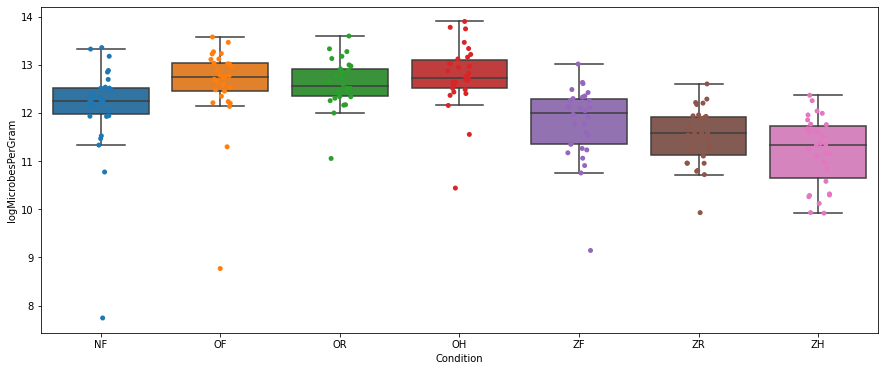

In [256]:
order = ['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH']

plt.figure(figsize=(15,6))
sns.boxplot(x='Condition', y='logMicrobesPerGram', data=df_count, showfliers=False, order=order)
sns.stripplot(x='Condition', y='logMicrobesPerGram', data=df_count, order=order)
plt.title('', size=16)

In [257]:
from statsmodels.formula.api import ols
model = ols('logMicrobesPerGram ~ C(Condition)', data=df_count).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq     df          F        PR(>F)
C(Condition)   65.782954    6.0  20.104164  2.105046e-18
Residual      110.706251  203.0        NaN           NaN

In [258]:
df_count['Donor_Condition'] = df_count.Donor + '_' + df_count.Condition

Text(0.5, 1.0, '')

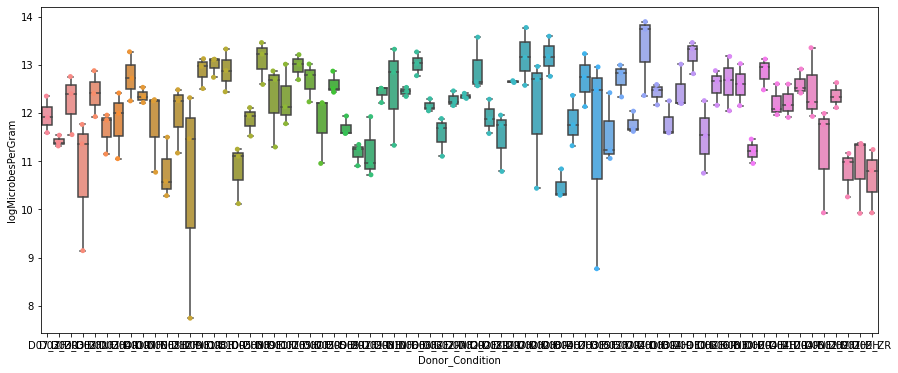

In [259]:
#order = ['NF', 'OH', 'OR', 'OH', 'ZF', 'ZR', 'ZH']

plt.figure(figsize=(15,6))
sns.boxplot(x='Donor_Condition', y='logMicrobesPerGram', data=df_count, showfliers=False)
sns.stripplot(x='Donor_Condition', y='logMicrobesPerGram', data=df_count)
plt.title('', size=16)

In [87]:
from statsmodels.formula.api import ols
model = ols('logCopyNumberPerGram ~ C(Donor) * C(Condition) ', data=df_count).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

NameError: name 'df_count' is not defined

In [88]:
64.9 / (13.2 + 66.9 + 32.8 + 64.9)

0.36501687289088863

In [262]:
url_concetnration = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/qPCR/BenchmarkingDNAConcentration.csv?token=GHSAT0AAAAAABVVFHN5J2F4YWJOQLE6YT5UYX3E6MA'

df_concentration = pd.read_csv(url_concetnration)

<AxesSubplot:xlabel='MicrobesPerGram', ylabel='DNAConcentration'>

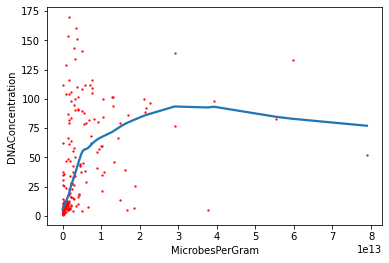

In [263]:
df_temp = pd.merge(df_count, df_concentration, on='SampleName')

sns.regplot(x = 'MicrobesPerGram', y = 'DNAConcentration', data=df_temp, lowess=True, scatter_kws={'color':'r', 's':2})



In [264]:
data_cols = df_final.columns[:-4]

In [265]:
df_final

D04-ZR-R1  D10-NF-R1  NCO-B2-R1  D02-OF-R1  D02-OF-R3  D06-ZR-R2  \
0      626060.0  1343249.0       74.0  2438248.0  1509977.0   898681.0   
1     6471896.0  1654910.0      287.0  2973101.0  2353816.0  1103825.0   
2           0.0        0.0        0.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        3.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        0.0        0.0   
...         ...        ...        ...        ...        ...        ...   
3734       78.0        7.0        0.0       23.0       11.0       20.0   
3735        0.0        1.0        0.0        0.0        0.0        0.0   
3736       72.0        2.0        0.0       27.0       11.0       38.0   
3737       48.0       19.0        0.0       33.0       18.0       13.0   
3738      112.0       22.0        0.0       31.0       27.0       16.0   

      D06-ZF-R2  D09-ZH-R2  D01-ZR-R3  D10-OH-R1  ...  D03-ZR-R1  D09-ZR-R3  \
0      886377.0   704459.0   586079.0  4692140.0  ...  1735362.0   704908.0   
1     1256495.0  2580747.0  1326495.0  5639370.0  ...  5174207.0  2264921.0   
2           0.0        0.0        0.0        0.0  ...        0.0        0.0   
3           0.0        2.0        0.0        1.0  ...        1.0        1.0   
4           0.0        1.0        0.0        0.0  ...        0.0        0.0   
...         ...        ...        ...        ...  ...        ...        ...   
3734        9.0       15.0        5.0       20.0  ...       17.0        5.0   
3735        0.0        0.0        0.0        2.0  ...        0.0        0.0   
3736       37.0       47.0       15.0       22.0  ...       38.0       46.0   
3737       11.0       29.0       16.0       86.0  ...       88.0       21.0   
3738        9.0       57.0       24.0       92.0  ...       32.0       43.0   

      D01-ZF-R3  D03-ZH-R3  D07-OH-R2  D09-NF-R2                    genus  \
0     1242680.0   952127.0   639166.0   683381.0                     null   
1     1949529.0  2991735.0  1049433.0  2236656.0             unclassified   
2           0.0        0.0        0.0        1.0  unclassified Poxviridae   
3           0.0        0.0        0.0        0.0            Orthopoxvirus   
4           1.0        0.0        0.0        0.0             Parapoxvirus   
...         ...        ...        ...        ...                      ...   
3734        8.0       12.0        9.0        8.0                     null   
3735        0.0        0.0        0.0        0.0                     null   
3736       21.0       17.0       13.0       28.0                     null   
3737       19.0       39.0       15.0       29.0                     null   
3738       29.0       21.0       25.0       28.0                     null   

                               phylum   kingdom  mean16S  
0        classified at a higher level      null      NaN  
1                                null      null      NaN  
2                                null   Viruses     0.00  
3                                null   Viruses     0.00  
4                                null   Viruses     0.00  
...                               ...       ...      ...  
3734       candidate division FCPU426  Bacteria     1.94  
3735          candidate division NC10  Bacteria     1.94  
3736         candidate division WOR-3  Bacteria     1.94  
3737          candidate division WWE3  Bacteria     1.94  
3738  candidate division Zixibacteria  Bacteria     1.94  

[3739 rows x 238 columns]

In [ ]:
# compute all the metrics we are interested in

In [266]:
df = pd.DataFrame([])

In [267]:
df_phylum = pd.DataFrame([], columns = data_cols).T

df_phylum['Total Count'] = df_final[data_cols].sum()

df_phylum['Firmicutes'] = df_final[df_final.phylum == 'Firmicutes'][data_cols].sum()
df_phylum['Bacteroidetes'] = df_final[df_final.phylum == 'Bacteroidetes'][data_cols].sum()
df_phylum['Proteobacteria'] = df_final[df_final.phylum == 'Proteobacteria'][data_cols].sum()
df_phylum['Actinobacteria'] = df_final[df_final.phylum == 'Actinobacteria'][data_cols].sum()
df_phylum['Other Bacteria'] = df_final[(~df_final.phylum.isin(['Firmicutes', 'Bacteroidetes', 'Actinobacteria'])) & (df_final.kingdom == 'Bacteria')][data_cols].sum()
df_phylum['Viruses'] = df_final[(df_final.kingdom == 'Viruses')][data_cols].sum()
df_phylum['Fungi'] = df_final[(df_final.kingdom == 'Fungi')][data_cols].sum()
df_phylum['Unclassified'] = df_final[(df_final.genus == 'unclassified')][data_cols].sum()
df_phylum['Root'] = df_final[(df_final.phylum == 'classified at a higher level')][data_cols].sum()

df_phylum['Other'] = df_phylum['Total Count'] - df_final[df_final.kingdom.isin(['Bacteria', 'Viruses', 'Fungi'])][data_cols].sum() -  df_phylum.Unclassified - df_phylum.Root

df_phylum = df_phylum[df_phylum['Total Count'] > 100000]

df_temp = df_count[['SampleName', 'mean_16s_count', 'MicrobesPerGram', 'logMicrobesPerGram']].copy()
df_temp['SampleName'] = df_temp['SampleName'].str.replace('_', '-')
df_temp = df_temp.set_index('SampleName')
df_phylum = pd.merge(df_phylum, df_temp, left_index = True, right_index = True)

df_temp = df_concentration.copy()
df_temp['SampleName'] = df_temp['SampleName'].str.replace('_', '-')
df_temp = df_temp.set_index('SampleName')
df_phylum = pd.merge(df_phylum, df_temp, left_index = True, right_index = True)

df_phylum.tail()

Total Count  Firmicutes  Bacteroidetes  Proteobacteria  \
D09-ZR-R3   25218155.0  10675845.0      9461369.0       1066013.0   
D01-ZF-R3   34207554.0  16239717.0     13928675.0        329927.0   
D03-ZH-R3   49820183.0  20469541.0     22838869.0        207801.0   
D07-OH-R2   20392102.0  12413353.0      4993863.0        896042.0   
D09-NF-R2   26779870.0  15251536.0      5897523.0       1055497.0   

           Actinobacteria  Other Bacteria   Viruses    Fungi  Unclassified  \
D09-ZR-R3        925216.0       1118798.0   45236.0  20496.0     2264921.0   
D01-ZF-R3        185494.0        621253.0   21064.0  17650.0     1949529.0   
D03-ZH-R3       2127743.0        263853.0  144675.0  27652.0     2991735.0   
D07-OH-R2        322684.0        954149.0    6160.0  12438.0     1049433.0   
D09-NF-R2       1562912.0       1098795.0   25427.0  21634.0     2236656.0   

                Root   Other  mean_16s_count  MicrobesPerGram  \
D09-ZR-R3   704908.0  1366.0        4.624150     6.371960e+10   
D01-ZF-R3  1242680.0  1492.0        4.537551     6.018842e+11   
D03-ZH-R3   952127.0  3988.0        4.386005     1.789153e+12   
D07-OH-R2   639166.0   856.0        4.706214     1.431565e+13   
D09-NF-R2   683381.0  2006.0        4.743168     3.257057e+12   

           logMicrobesPerGram  DNAConcentration  
D09-ZR-R3           10.804273              2.64  
D01-ZF-R3           11.779513             10.30  
D03-ZH-R3           12.252647             12.90  
D07-OH-R2           13.155811             66.60  
D09-NF-R2           12.512825            134.00

In [268]:
df_phylum.columns

Index(['Total Count', 'Firmicutes', 'Bacteroidetes', 'Proteobacteria',
       'Actinobacteria', 'Other Bacteria', 'Viruses', 'Fungi', 'Unclassified',
       'Root', 'Other', 'mean_16s_count', 'MicrobesPerGram',
       'logMicrobesPerGram', 'DNAConcentration'],
      dtype='object')

In [391]:
df = df_phylum[['MicrobesPerGram', 'mean_16s_count', 'Total Count', 'DNAConcentration']].copy()

for col in ['Firmicutes', 'Bacteroidetes', 'Proteobacteria',
       'Actinobacteria', 'Other Bacteria', 'Viruses', 'Fungi', 'Unclassified',
       'Root', 'Other']:
    df['Absolute Abundance: ' + col] = df_phylum[col] / df_phylum['Total Count'] * df_phylum['MicrobesPerGram']
    
for col in ['Firmicutes', 'Bacteroidetes', 'Proteobacteria',
       'Actinobacteria', 'Other Bacteria', 'Viruses', 'Fungi', 'Unclassified',
       'Root', 'Other']:
    df['Relative Abundance: ' + col] = df_phylum[col] / df_phylum['Total Count']

In [401]:
df['Total Count'].describe()

count    2.090000e+02
mean     3.735386e+07
std      2.542741e+07
min      7.140795e+06
25%      2.210013e+07
50%      2.729356e+07
75%      4.329333e+07
max      1.640719e+08
Name: Total Count, dtype: float64

In [406]:
df_temp = df_final[~df_final.genus.isin(['null', 'unclassified'])].copy() #[data_cols]
df_temp['name'] = df_temp['phylum'] + ': ' + df_temp['genus']
df_genus = df_temp.set_index('name')[data_cols].T.loc[df_phylum.index, :]

df_rel_genus = df_genus.copy()
df_rel_genus['Total Count'] = df_genus.T.sum()
for col in df_rel_genus.columns:
    if col != 'Total Count':
        df_rel_genus[col] = df_rel_genus[col] / df_rel_genus['Total Count']

df_rel_genus.drop(columns=['Total Count'], inplace=True)

df_rel_genus.tail()

name       null: unclassified Poxviridae  null: Orthopoxvirus  \
D09-ZR-R3                   0.000000e+00         5.523670e-08   
D01-ZF-R3                   0.000000e+00         0.000000e+00   
D03-ZH-R3                   0.000000e+00         0.000000e+00   
D07-OH-R2                   0.000000e+00         0.000000e+00   
D09-NF-R2                   5.238133e-08         0.000000e+00   

name       null: Parapoxvirus  null: Avipoxvirus  null: Capripoxvirus  \
D09-ZR-R3        0.000000e+00       5.523670e-08                  0.0   
D01-ZF-R3        3.888595e-08       0.000000e+00                  0.0   
D03-ZH-R3        0.000000e+00       0.000000e+00                  0.0   
D07-OH-R2        0.000000e+00       0.000000e+00                  0.0   
D09-NF-R2        0.000000e+00       0.000000e+00                  0.0   

name       null: Leporipoxvirus  null: Suipoxvirus  null: Molluscipoxvirus  \
D09-ZR-R3                   0.0                0.0            0.000000e+00   
D01-ZF-R3                   0.0                0.0            0.000000e+00   
D03-ZH-R3                   0.0                0.0            5.415001e-08   
D07-OH-R2                   0.0                0.0            0.000000e+00   
D09-NF-R2                   0.0                0.0            0.000000e+00   

name       null: Yatapoxvirus  null: unclassified Chordopoxvirinae  ...  \
D09-ZR-R3        0.000000e+00                                  0.0  ...   
D01-ZF-R3        0.000000e+00                                  0.0  ...   
D03-ZH-R3        0.000000e+00                                  0.0  ...   
D07-OH-R2        0.000000e+00                                  0.0  ...   
D09-NF-R2        5.238133e-08                                  0.0  ...   

name       Candidatus Diapherotrites: unclassified Diapherotrites  \
D09-ZR-R3                                       5.523670e-08        
D01-ZF-R3                                       0.000000e+00        
D03-ZH-R3                                       2.707500e-08        
D07-OH-R2                                       6.724488e-08        
D09-NF-R2                                       5.238133e-08        

name       Candidatus Parvarchaeota: unclassified Candidatus Parvarchaeota  \
D09-ZR-R3                                                0.0                 
D01-ZF-R3                                                0.0                 
D03-ZH-R3                                                0.0                 
D07-OH-R2                                                0.0                 
D09-NF-R2                                                0.0                 

name       Candidatus Micrarchaeota: Candidatus Micrarchaeum  \
D09-ZR-R3                                                0.0   
D01-ZF-R3                                                0.0   
D03-ZH-R3                                                0.0   
D07-OH-R2                                                0.0   
D09-NF-R2                                                0.0   

name       Candidatus Micrarchaeota: unclassified Candidatus Micrarchaeota  \
D09-ZR-R3                                       1.104734e-07                 
D01-ZF-R3                                       7.777190e-08                 
D03-ZH-R3                                       1.353750e-07                 
D07-OH-R2                                       0.000000e+00                 
D09-NF-R2                                       1.047627e-07                 

name       Candidatus Micrarchaeota: Candidatus Mancarchaeum  \
D09-ZR-R3                                       0.000000e+00   
D01-ZF-R3                                       2.722017e-07   
D03-ZH-R3                                       0.000000e+00   
D07-OH-R2                                       0.000000e+00   
D09-NF-R2                                       0.000000e+00   

name       null: unclassified DPANN group  \
D09-ZR-R3                             0.0   
D01-ZF-R3                            

In [407]:
df_abs_genus = pd.concat([df[['MicrobesPerGram', 'Total Count']].sort_index(), df_genus.sort_index()], axis=1)
for col in df_genus.columns:
    df_abs_genus[col] = df_abs_genus[col] / df_abs_genus['Total Count'] * df_abs_genus['MicrobesPerGram']
    
#df_abs_genus.drop(columns=['MicrobesPerGram', 'Total Count'], inplace=True)

df_abs_genus.tail()

MicrobesPerGram  Total Count  null: unclassified Poxviridae  \
D10-ZH-R2     1.316319e+10   22670427.0                        0.00000   
D10-ZH-R3     1.267569e+11   33535539.0                        0.00000   
D10-ZR-R1     1.643602e+11   27103345.0                     6064.20314   
D10-ZR-R2     2.875924e+11   15382122.0                        0.00000   
D10-ZR-R3     8.986227e+10   26344170.0                        0.00000   

           null: Orthopoxvirus  null: Parapoxvirus  null: Avipoxvirus  \
D10-ZH-R2                  0.0                 0.0                0.0   
D10-ZH-R3                  0.0                 0.0                0.0   
D10-ZR-R1                  0.0                 0.0                0.0   
D10-ZR-R2                  0.0                 0.0                0.0   
D10-ZR-R3                  0.0                 0.0                0.0   

           null: Capripoxvirus  null: Leporipoxvirus  null: Suipoxvirus  \
D10-ZH-R2                  0.0                   0.0                0.0   
D10-ZH-R3                  0.0                   0.0                0.0   
D10-ZR-R1                  0.0                   0.0                0.0   
D10-ZR-R2                  0.0                   0.0                0.0   
D10-ZR-R3                  0.0                   0.0                0.0   

           null: Molluscipoxvirus  ...  \
D10-ZH-R2                     0.0  ...   
D10-ZH-R3                     0.0  ...   
D10-ZR-R1                     0.0  ...   
D10-ZR-R2                     0.0  ...   
D10-ZR-R3                     0.0  ...   

           Candidatus Diapherotrites: unclassified Diapherotrites  \
D10-ZH-R2                                         580.632866        
D10-ZH-R3                                        7559.553585        
D10-ZR-R1                                       12128.406281        
D10-ZR-R2                                           0.000000        
D10-ZR-R3                                        6822.175145        

           Candidatus Parvarchaeota: unclassified Candidatus Parvarchaeota  \
D10-ZH-R2                                                0.0                 
D10-ZH-R3                                                0.0                 
D10-ZR-R1                                                0.0                 
D10-ZR-R2                                                0.0                 
D10-ZR-R3                                                0.0                 

           Candidatus Micrarchaeota: Candidatus Micrarchaeum  \
D10-ZH-R2                                                0.0   
D10-ZH-R3                                                0.0   
D10-ZR-R1                                                0.0   
D10-ZR-R2                                                0.0   
D10-ZR-R3                                                0.0   

           Candidatus Micrarchaeota: unclassified Candidatus Micrarchaeota  \
D10-ZH-R2                                           0.000000                 
D10-ZH-R3                                       15119.107171                 
D10-ZR-R1                                       30321.015702                 
D10-ZR-R2                                           0.000000                 
D10-ZR-R3                                        3411.087572                 

           Candidatus Micrarchaeota: Candidatus Mancarchaeum  \
D10-ZH-R2                                                0.0   
D10-ZH-R3                                                0.0   
D10-ZR-R1                                                0.0   
D10-ZR-R2                                                0.0   
D10-ZR-R3                                                0.0   

           null: unclassified DPANN group  \
D10-ZH-R2                             0.0   
D10-ZH-R3                             0.0   
D10-ZR-R1                             0.0   
D10-ZR-R2                             0.0   
D10-ZR-R3                             0.0   

           Candidatus Altiarc

In [408]:
(df_abs_genus[df_genus.columns].sum(axis=1) - df_abs_genus['Total Count']).sort_values()

D10-NF-R3    1.159435e+07
D03-OF-R3    4.114144e+08
D03-ZF-R3    9.716828e+08
D05-ZH-R3    5.596422e+09
D01-ZH-R1    5.890964e+09
                 ...     
D02-OF-R2    2.733293e+13
D02-OR-R2    2.981527e+13
D04-OH-R1    4.096578e+13
D07-OH-R1    4.325011e+13
D04-OH-R2    5.750346e+13
Length: 209, dtype: float64

In [409]:
df_alpha = pd.DataFrame([])

df_alpha['Richness 0.01%'] = (df_rel_genus>0.0001).sum(axis=1)
df_alpha['Richness 0.001%'] = (df_rel_genus>0.00001).sum(axis=1)
df_alpha['Richness 0.0001%'] = (df_rel_genus>0.000001).sum(axis=1)
df_alpha['Richness 0.00001%'] = (df_rel_genus>0.0000001).sum(axis=1)
#df_alpha['Richness 0.000001%'] = (df_rel_genus>0.00000001).sum(axis=1)
df_alpha['Richness Any%'] = (df_rel_genus>0).sum(axis=1)


df_alpha['Richness 100M'] = (df_abs_genus>100000000).sum(axis=1)
df_alpha['Richness 10M'] = (df_abs_genus>10000000).sum(axis=1)
df_alpha['Richness 1M'] = (df_abs_genus>1000000).sum(axis=1)

df_alpha['Shannon Entropy'] = -(df_rel_genus* np.log(df_rel_genus)).fillna(0).T.sum()
df_alpha['Inv Simpson'] = (df_rel_genus**2).T.sum()**-1
#df_alpha['Chao1']

df_alpha

<ipython-input-409-5f08fb6aee3e>:15: RuntimeWarning: divide by zero encountered in log
  df_alpha['Shannon Entropy'] = -(df_rel_genus* np.log(df_rel_genus)).fillna(0).T.sum()


Richness 0.01%  Richness 0.001%  Richness 0.0001%  \
D04-ZR-R1             107              362              1511   
D10-NF-R1              79              216               807   
D02-OF-R1              80              208               767   
D02-OF-R3              81              218               814   
D06-ZR-R2              79              226               832   
...                   ...              ...               ...   
D09-ZR-R3              99              256               944   
D01-ZF-R3              86              225               809   
D03-ZH-R3              84              233               862   
D07-OH-R2              84              245               927   
D09-NF-R2              94              272              1019   

           Richness 0.00001%  Richness Any%  Richness 100M  Richness 10M  \
D04-ZR-R1               2794           3080             94           270   
D10-NF-R1               1969           2575             92           255   
D02-OF-R1               2055           2822            124           403   
D02-OF-R3               2269           2765            122           392   
D06-ZR-R2               2270           2643             61           131   
...                      ...            ...            ...           ...   
D09-ZR-R3               2299           2683             40            77   
D01-ZF-R3               2263           2812             70           161   
D03-ZH-R3               2364           2906             93           272   
D07-OH-R2               2313           2707            251           929   
D09-NF-R2               2507           2803            127           453   

           Richness 1M  Shannon Entropy  Inv Simpson  
D04-ZR-R1         1152         3.322845    15.348745  
D10-NF-R1          958         2.572146     5.043725  
D02-OF-R1         1418         2.117674     2.876175  
D02-OF-R3         1413         2.557832     4.752923  
D06-ZR-R2          462         2.262505     3.854080  
...                ...              ...          ...  
D09-ZR-R3          169         2.852421     6.591178  
D01-ZF-R3          520         2.683706     7.363171  
D03-ZH-R3         1039         2.668884     5.938143  
D07-OH-R2         2315         2.970163    10.942753  
D09-NF-R2         1535         3.073128     9.855915  

[209 rows x 10 columns]

In [410]:
df = pd.merge(df, df_alpha, left_index=True, right_index=True)

In [411]:
df.to_csv('primary_outcomes.csv')
df_rel_genus.to_csv('secondary_outcomes.csv')
df_genus.to_csv('genus_outcomes.csv')
df_abs_genus.to_csv('abs_genus.csv')

## Step 2: Fit the model

In [3]:
df = pd.read_csv('primary_outcomes.csv', index_col = 0)
df_rel_genus = pd.read_csv('secondary_outcomes.csv', index_col = 0)
df_genus = pd.read_csv('genus_outcomes.csv', index_col = 0)
df_abs_genus = pd.read_csv('abs_genus.csv', index_col = 0)

In [4]:
df['Patient'] = df.index.str.split('-').str[0]
df['Sample_Type'] = df.index.str.split('-').str[1]
df['Replication'] = df.index.str.split('-').str[2]

In [5]:
df_dna = df[['Relative Abundance: Firmicutes', 'Relative Abundance: Bacteroidetes',
       'Relative Abundance: Actinobacteria',
       'Relative Abundance: Other Bacteria', 'Relative Abundance: Proteobacteria']].copy()
norm = df_dna.iloc[:,:-1].sum(axis=1)
for col in df_dna.columns:
    df_dna[col] = df_dna[col]/norm



In [6]:
#10 patients, 21 samples each
df.groupby('Patient').size()

Patient
D01    21
D02    21
D03    20
D04    21
D05    21
D06    21
D07    21
D08    21
D09    21
D10    21
dtype: int64

In [7]:
#7 Sample Types, 30 samples each
df.groupby('Sample_Type').size()

Sample_Type
NF    30
OF    30
OH    30
OR    30
ZF    30
ZH    29
ZR    30
dtype: int64

In [8]:
#3 Replications for each
df.groupby('Replication').size()

Replication
R1    70
R2    69
R3    70
dtype: int64

In [9]:
df.columns

Index(['MicrobesPerGram', 'mean_16s_count', 'Total Count', 'DNAConcentration',
       'Absolute Abundance: Firmicutes', 'Absolute Abundance: Bacteroidetes',
       'Absolute Abundance: Proteobacteria',
       'Absolute Abundance: Actinobacteria',
       'Absolute Abundance: Other Bacteria', 'Absolute Abundance: Viruses',
       'Absolute Abundance: Fungi', 'Absolute Abundance: Unclassified',
       'Absolute Abundance: Root', 'Absolute Abundance: Other',
       'Relative Abundance: Firmicutes', 'Relative Abundance: Bacteroidetes',
       'Relative Abundance: Proteobacteria',
       'Relative Abundance: Actinobacteria',
       'Relative Abundance: Other Bacteria', 'Relative Abundance: Viruses',
       'Relative Abundance: Fungi', 'Relative Abundance: Unclassified',
       'Relative Abundance: Root', 'Relative Abundance: Other',
       'Richness 0.01%', 'Richness 0.001%', 'Richness 0.0001%',
       'Richness 0.00001%', 'Richness Any%', 'Richness 100M', 'Richness 10M',
       'Richness 1M

In [10]:
#Overall Abundance

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))


feature = 'MicrobesPerGram'

df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
df_temp['log_feature'] = np.log(df_temp[feature])

mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 log_feature   No. Observations:                  209
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  21
Family:                           Gaussian   Mean cluster size:                20.9
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Fri, 23 Sep 2022   Scale:                           2.902
Covariance type:                    robust   Time:                         16:10:43
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          27.9166      0.437     63.880      0.000      27.060      28.773
C(Sample_Type, Treatment(reference='NF'))[T.OF]     1.1015      0.532      2.072      0.038       0.059       2.144
C(Sample_Type, Treatment(reference='NF'))[T.OH]     1.4757      0.506      2.916      0.004       0.484       2.467
C(Sample_Type, Treatment(reference='NF'))[T.OR]     1.1349      0.496      2.286      0.022       0.162       2.108
C(Sample_Type, Treatment(reference='NF'))[T.ZF]    -0.7527      0.511     -1.472      0.141      -1.755       0.249
C(Sample_Type, Treatment(reference='NF'))[T.ZH]    -2.1663      0.548     -3.955      0.000      -3.240      -1.093
C(Sample_Type, Treatment(reference='NF'))[T.ZR]    -1.3970      0.495     -2.819      0.005      -2.368      -0.426
==============================================================================
Skew:                         -2.1664   Kurtosis:                       9.4045
Centered skew:                -1.9996   Centered kurtosis:              8.0421
==============================================================================
"""

In [11]:
ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['mean'] = np.exp(preds['mean'])
preds['err_high'] =  np.exp(preds.mean_ci_upper) - preds['mean']
preds['err_low'] = preds['mean'] -  np.exp(preds.mean_ci_lower)
preds

Sample_Type          mean   mean_se  mean_ci_lower  mean_ci_upper  \
0          NF  1.330546e+12  0.437013      27.060080      28.773141   
1          OF  4.003256e+12  0.347375      28.337286      29.698972   
2          OR  4.139335e+12  0.254780      28.552196      29.550916   
3          OH  5.819884e+12  0.292432      28.819145      29.965458   
4          ZF  6.268292e+11  0.367102      26.444433      27.883447   
5          ZR  3.291085e+11  0.301645      25.928439      27.110867   
6          ZH  1.524786e+11  0.348782      25.066690      26.433890   

       err_high       err_low  
0  1.802858e+12  7.655526e+11  
1  3.905345e+12  1.976847e+12  
2  2.680910e+12  1.627095e+12  
3  4.503764e+12  2.538965e+12  
4  6.603153e+11  3.215683e+11  
5  2.653206e+11  1.468960e+11  
6  1.495810e+11  7.550794e+10

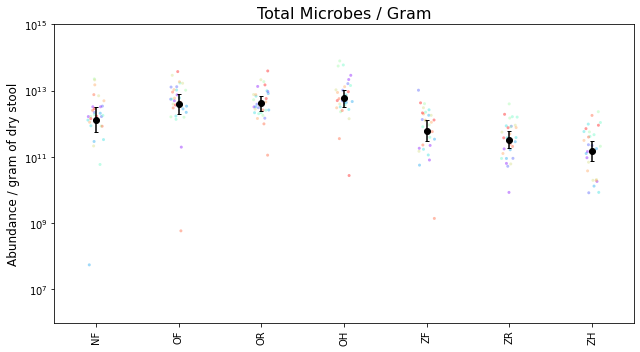

In [12]:
plt.figure(figsize=(12,8))

ii = 0
for pp in set(df.Patient):
    df_temp = df[df.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Sample_Type', y=feature, data=df_temp, 
                  order = ['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'],
                  s=3, alpha=0.4, color = colors[ii], zorder = 1 + ii)
    ii += 1
    #sns.swarmplot('Sample_Type', 'entropy', data=df_temp, jitter=0.2)
    

temp = preds
data = temp.groupby('Sample_Type')[['mean', 'err_low', 'err_high']].mean().reindex(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder = 12)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 13)

plt.title('Total Microbes / Gram', fontsize=16)

plt.xlabel('', fontsize=12)
plt.ylabel('Abundance / gram of dry stool', fontsize=12)

plt.yscale('log')
plt.ylim([10**6, 10**15])

plt.tight_layout()
#fig1=plt.show()

#plt.ylim([0,1])

plt.savefig('temp.jpg', dpi=400)


In [13]:
#DNA Concentration

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))


feature = 'DNAConcentration'

df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
df_temp['log_feature'] = np.log(df_temp[feature])

mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 log_feature   No. Observations:                  209
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  21
Family:                           Gaussian   Mean cluster size:                20.9
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Fri, 23 Sep 2022   Scale:                           0.613
Covariance type:                    robust   Time:                         16:10:45
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           4.0838      0.211     19.330      0.000       3.670       4.498
C(Sample_Type, Treatment(reference='NF'))[T.OF]    -0.4387      0.238     -1.841      0.066      -0.906       0.028
C(Sample_Type, Treatment(reference='NF'))[T.OH]    -0.2413      0.257     -0.937      0.349      -0.746       0.263
C(Sample_Type, Treatment(reference='NF'))[T.OR]    -0.0967      0.221     -0.437      0.662      -0.530       0.337
C(Sample_Type, Treatment(reference='NF'))[T.ZF]    -1.8614      0.232     -8.028      0.000      -2.316      -1.407
C(Sample_Type, Treatment(reference='NF'))[T.ZH]    -2.5181      0.223    -11.301      0.000      -2.955      -2.081
C(Sample_Type, Treatment(reference='NF'))[T.ZR]    -2.4009      0.205    -11.736      0.000      -2.802      -2.000
==============================================================================
Skew:                         -1.0039   Kurtosis:                       0.9498
Centered skew:                -1.0989   Centered kurtosis:              1.5242
==============================================================================
"""

In [14]:
ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['mean'] = np.exp(preds['mean'])
preds['err_high'] =  np.exp(preds.mean_ci_upper) - preds['mean']
preds['err_low'] = preds['mean'] -  np.exp(preds.mean_ci_lower)

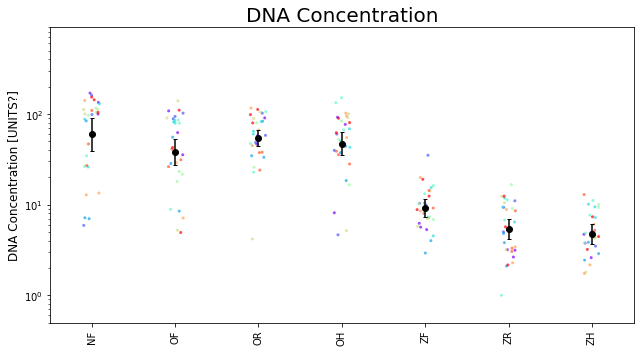

In [15]:
plt.figure(figsize=(12,8))

ii = 0
for pp in set(df.Patient):
    df_temp = df[df.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Sample_Type', y=feature, data=df_temp, 
                  order = ['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'],
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii)
    ii += 1
    #sns.swarmplot('Sample_Type', 'entropy', data=df_temp, jitter=0.2)
    

temp = preds
data = temp.groupby('Sample_Type')[['mean', 'err_low', 'err_high']].mean().reindex(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder = 12)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 13)

plt.title('DNA Concentration', fontsize=20)

plt.xlabel('', fontsize=12)
plt.ylabel('DNA Concentration [UNITS?]', fontsize=12)

plt.yscale('log')
plt.ylim([0.5, 9 * 10**2])

plt.tight_layout()
#fig1=plt.show()

#plt.ylim([0,1])

plt.savefig('temp.jpg')


In [16]:
df.columns

Index(['MicrobesPerGram', 'mean_16s_count', 'Total Count', 'DNAConcentration',
       'Absolute Abundance: Firmicutes', 'Absolute Abundance: Bacteroidetes',
       'Absolute Abundance: Proteobacteria',
       'Absolute Abundance: Actinobacteria',
       'Absolute Abundance: Other Bacteria', 'Absolute Abundance: Viruses',
       'Absolute Abundance: Fungi', 'Absolute Abundance: Unclassified',
       'Absolute Abundance: Root', 'Absolute Abundance: Other',
       'Relative Abundance: Firmicutes', 'Relative Abundance: Bacteroidetes',
       'Relative Abundance: Proteobacteria',
       'Relative Abundance: Actinobacteria',
       'Relative Abundance: Other Bacteria', 'Relative Abundance: Viruses',
       'Relative Abundance: Fungi', 'Relative Abundance: Unclassified',
       'Relative Abundance: Root', 'Relative Abundance: Other',
       'Richness 0.01%', 'Richness 0.001%', 'Richness 0.0001%',
       'Richness 0.00001%', 'Richness Any%', 'Richness 100M', 'Richness 10M',
       'Richness 1M

In [17]:
#'Relative Abundance: Firmicutes'

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

feature = 'Relative Abundance: Firmicutes'



df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
df_temp['log_feature'] = np.log(df_temp[feature])

mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 log_feature   No. Observations:                  209
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  21
Family:                           Gaussian   Mean cluster size:                20.9
Dependence structure:         Exchangeable   Num. iterations:                     3
Date:                     Fri, 23 Sep 2022   Scale:                           0.040
Covariance type:                    robust   Time:                         16:10:50
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -0.5640      0.037    -15.237      0.000      -0.637      -0.491
C(Sample_Type, Treatment(reference='NF'))[T.OF]    -0.2357      0.040     -5.952      0.000      -0.313      -0.158
C(Sample_Type, Treatment(reference='NF'))[T.OH]    -0.1909      0.038     -5.078      0.000      -0.265      -0.117
C(Sample_Type, Treatment(reference='NF'))[T.OR]    -0.2494      0.034     -7.387      0.000      -0.316      -0.183
C(Sample_Type, Treatment(reference='NF'))[T.ZF]    -0.0912      0.022     -4.111      0.000      -0.135      -0.048
C(Sample_Type, Treatment(reference='NF'))[T.ZH]    -0.2788      0.042     -6.701      0.000      -0.360      -0.197
C(Sample_Type, Treatment(reference='NF'))[T.ZR]    -0.2217      0.042     -5.225      0.000      -0.305      -0.139
==============================================================================
Skew:                         -0.0816   Kurtosis:                      -0.5755
Centered skew:                -0.5241   Centered kurtosis:              0.2236
==============================================================================
"""

In [18]:
ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['mean'] = np.exp(preds['mean'])
preds['err_high'] =  np.exp(preds.mean_ci_upper) - preds['mean']
preds['err_low'] = preds['mean'] -  np.exp(preds.mean_ci_lower)

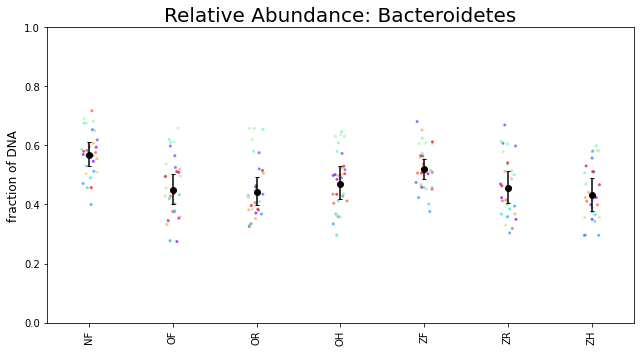

In [19]:
plt.figure(figsize=(12,8))

ii = 0
for pp in set(df.Patient):
    df_temp = df[df.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Sample_Type', y=feature, data=df_temp, 
                  order = ['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'],
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii)
    ii += 1
    #sns.swarmplot('Sample_Type', 'entropy', data=df_temp, jitter=0.2)
    

temp = preds
data = temp.groupby('Sample_Type')[['mean', 'err_low', 'err_high']].mean().reindex(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder = 12)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 13)

plt.title('Relative Abundance: Bacteroidetes' , fontsize=20)

plt.xlabel('', fontsize=12)
plt.ylabel('fraction of DNA', fontsize=12)

#plt.yscale('log')
plt.ylim([0, 1])

plt.tight_layout()
#fig1=plt.show()

#plt.ylim([0,1])

plt.savefig('temp.jpg')


<AxesSubplot:>

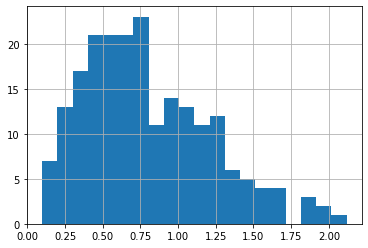

In [20]:
(df['Relative Abundance: Bacteroidetes'] / df['Relative Abundance: Firmicutes']).hist(bins=20)

In [21]:
(df['Relative Abundance: Bacteroidetes'] / df['Relative Abundance: Firmicutes']).describe()

count    209.000000
mean       0.797683
std        0.425226
min        0.097773
25%        0.465891
50%        0.707882
75%        1.065162
max        2.117496
dtype: float64

In [22]:
#Ratio

df2 = df.copy()
df2['ratio'] = df['Relative Abundance: Bacteroidetes'] / df['Relative Abundance: Firmicutes']
df2['frac'] = df['Relative Abundance: Bacteroidetes'] / (df['Relative Abundance: Bacteroidetes'] + df['Relative Abundance: Firmicutes'])

feature = 'frac'



df_temp = df2[[feature, 'Sample_Type', 'Patient']].copy()
df_temp['feature'] = np.log(df_temp[feature])
df_temp['log_feature'] = np.log(df_temp[feature])

mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'ZF\'))',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 log_feature   No. Observations:                  209
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  21
Family:                           Gaussian   Mean cluster size:                20.9
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Fri, 23 Sep 2022   Scale:                           0.127
Covariance type:                    robust   Time:                         16:10:57
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -1.0269      0.068    -14.996      0.000      -1.161      -0.893
C(Sample_Type, Treatment(reference='ZF'))[T.NF]    -0.2638      0.071     -3.730      0.000      -0.402      -0.125
C(Sample_Type, Treatment(reference='ZF'))[T.OF]     0.1595      0.051      3.114      0.002       0.059       0.260
C(Sample_Type, Treatment(reference='ZF'))[T.OH]     0.1221      0.048      2.556      0.011       0.028       0.216
C(Sample_Type, Treatment(reference='ZF'))[T.OR]     0.1717      0.063      2.728      0.006       0.048       0.295
C(Sample_Type, Treatment(reference='ZF'))[T.ZH]     0.2357      0.032      7.386      0.000       0.173       0.298
C(Sample_Type, Treatment(reference='ZF'))[T.ZR]     0.1533      0.039      3.946      0.000       0.077       0.230
==============================================================================
Skew:                         -1.2968   Kurtosis:                       1.7137
Centered skew:                -0.4159   Centered kurtosis:              1.1107
==============================================================================
"""

In [23]:
ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

#preds['mean'] = preds['mean']
#preds['err_high'] =  preds.mean_ci_upper - preds['mean']
#preds['err_low'] = preds['mean'] -  preds.mean_ci_lower


#preds['mean'] = np.exp(preds['mean'])
#preds['err_high'] =  np.exp(preds.mean_ci_upper) - preds['mean']
#preds['err_low'] = preds['mean'] -  np.exp(preds.mean_ci_lower)


preds['mean'] = np.exp(preds['mean']) / (1 - np.exp(preds['mean']))
preds['mean_ci_upper'] = np.exp(preds['mean_ci_upper']) / (1 - np.exp(preds['mean_ci_upper']))
preds['mean_ci_lower'] = np.exp(preds['mean_ci_lower']) / (1 - np.exp(preds['mean_ci_lower']))
preds['err_high'] =  preds.mean_ci_upper - preds['mean']
preds['err_low'] = preds['mean'] -  preds.mean_ci_lower

In [24]:
preds

Sample_Type      mean   mean_se  mean_ci_lower  mean_ci_upper  err_high  \
0          NF  0.379481  0.122148       0.276360       0.537278  0.157797   
1          OF  0.724332  0.103266       0.522294       1.058888  0.334556   
2          OR  0.739732  0.118702       0.508159       1.157852  0.418121   
3          OH  0.679689  0.105630       0.490267       0.990961  0.311273   
4          ZF  0.557950  0.068476       0.455925       0.693683  0.135733   
5          ZR  0.716693  0.091771       0.535529       0.999016  0.282322   
6          ZH  0.829184  0.084969       0.622763       1.152623  0.323439   

    err_low  
0  0.103121  
1  0.202038  
2  0.231573  
3  0.189422  
4  0.102025  
5  0.181164  
6  0.206421

In [25]:
feature

'frac'

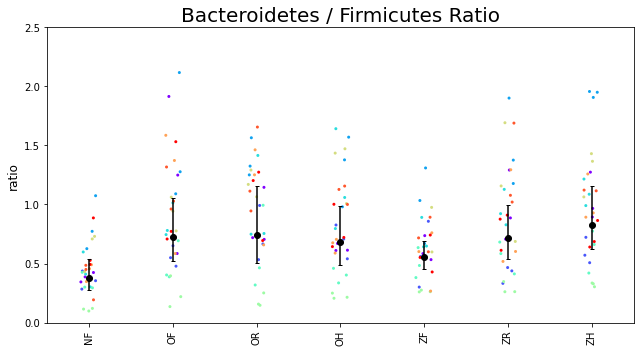

In [26]:
plt.figure(figsize=(12,8))

feature = 'ratio'

ii = 0
for pp in set(df.Patient):
    df_temp = df2[df2.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Sample_Type', y=feature, data=df_temp, 
                  order = ['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'],
                  s=3, alpha=1, color = colors[ii], zorder = 1 + ii)
    ii += 1
    #sns.swarmplot('Sample_Type', 'entropy', data=df_temp, jitter=0.2)
    

temp = preds
data = temp.groupby('Sample_Type')[['mean', 'err_low', 'err_high']].mean().reindex(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder = 12)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 13)

plt.title('Bacteroidetes / Firmicutes Ratio' , fontsize=20)

plt.xlabel('', fontsize=12)
plt.ylabel('ratio', fontsize=12)

#plt.yscale('log')
plt.ylim([0, 2.5])

plt.tight_layout()
#fig1=plt.show()

#plt.ylim([0,1])

plt.savefig('temp.jpg')


In [27]:
df2['ratio'].sort_index().to_csv('temp.csv')

In [28]:
.5/.0099

50.5050505050505

In [29]:
df.mean()

MicrobesPerGram                       5.008213e+12
mean_16s_count                        4.578717e+00
Total Count                           3.735386e+07
DNAConcentration                      4.092660e+01
Absolute Abundance: Firmicutes        2.596394e+12
Absolute Abundance: Bacteroidetes     1.577213e+12
Absolute Abundance: Proteobacteria    7.007541e+10
Absolute Abundance: Actinobacteria    1.772831e+11
Absolute Abundance: Other Bacteria    8.987326e+10
Absolute Abundance: Viruses           8.629560e+09
Absolute Abundance: Fungi             5.167048e+09
Absolute Abundance: Unclassified      3.961496e+11
Absolute Abundance: Root              1.571560e+11
Absolute Abundance: Other             3.474813e+08
Relative Abundance: Firmicutes        4.861162e-01
Relative Abundance: Bacteroidetes     3.467466e-01
Relative Abundance: Proteobacteria    1.396451e-02
Relative Abundance: Actinobacteria    3.829057e-02
Relative Abundance: Other Bacteria    1.757769e-02
Relative Abundance: Viruses    

In [30]:
df['Absolute Abundance: Root'].sort_values()

D10-NF-R3    2.494772e+06
D03-OF-R3    1.341310e+07
D03-ZF-R3    2.642542e+07
D09-ZR-R1    2.715364e+08
D01-ZH-R1    2.736034e+08
                 ...     
D08-OF-R2    1.006396e+12
D04-OH-R2    1.160926e+12
D02-OF-R2    1.371675e+12
D02-OR-R2    1.703448e+12
D07-OH-R1    1.717593e+12
Name: Absolute Abundance: Root, Length: 209, dtype: float64

In [31]:
ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['% change'] = np.exp(preds['mean'])
preds['CI_high'] =  np.exp(preds.mean_ci_upper)
preds['CI_low'] = np.exp(preds.mean_ci_lower)
preds['feature'] = feature



In [32]:
df['Absolute Abundance: Unclassified + Root'] = df['Absolute Abundance: Unclassified'] + df['Absolute Abundance: Root']

In [33]:
#do them all 

features = ['MicrobesPerGram',  'Absolute Abundance: Firmicutes', 'Absolute Abundance: Bacteroidetes',
       'Absolute Abundance: Actinobacteria',
       'Absolute Abundance: Other Bacteria', 'Absolute Abundance: Viruses',
       'Absolute Abundance: Fungi', 'Absolute Abundance: Unclassified + Root',
            'Absolute Abundance: Unclassified',
       'Absolute Abundance: Root', 'Absolute Abundance: Other']

df_kit_effects = pd.DataFrame([], columns = ['feature', 'OF', 'OF_annot', 'ZF', 'ZF_annot'])
df_temp_effects_O = pd.DataFrame([], columns = ['feature', 'OR', 'OR_annot', 'OH', 'OH_annot'])
df_temp_effects_Z = pd.DataFrame([], columns = ['feature', 'ZR', 'ZR_annot', 'ZH', 'ZH_annot'])
df_preds = pd.DataFrame([], columns = ['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high'])

i = 0

for feature in features:
    print(feature)

    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()
    
    ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])
    preds = pd.concat([ref, est.get_prediction(ref).summary_frame(alpha=.05)], axis=1)
    preds['prediction'] = np.exp(preds['mean'])
    preds['CI_high'] =  np.exp(preds.mean_ci_upper)
    preds['CI_low'] = np.exp(preds.mean_ci_lower)
    preds['feature'] = feature
    
    df_preds = pd.concat([df_preds, preds[['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high']]])


    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']

    cols = ['C(Sample_Type, Treatment(reference=\'NF\'))[T.OF]',
            'C(Sample_Type, Treatment(reference=\'NF\'))[T.ZF]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_kit_effects.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]



    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'OF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'OF\'))[T.OR]',
            'C(Sample_Type, Treatment(reference=\'OF\'))[T.OH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_O.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]



    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'ZF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZR]',
            'C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_Z.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]

    i += 1

MicrobesPerGram
Absolute Abundance: Firmicutes
Absolute Abundance: Bacteroidetes
Absolute Abundance: Actinobacteria
Absolute Abundance: Other Bacteria
Absolute Abundance: Viruses
Absolute Abundance: Fungi
Absolute Abundance: Unclassified + Root
Absolute Abundance: Unclassified
Absolute Abundance: Root
Absolute Abundance: Other


In [34]:
df[df.Sample_Type == 'ZF'][features].mean() / 10**9

MicrobesPerGram                            1514.925595
Absolute Abundance: Firmicutes              829.111634
Absolute Abundance: Bacteroidetes           453.713009
Absolute Abundance: Actinobacteria           54.109939
Absolute Abundance: Other Bacteria           21.534819
Absolute Abundance: Viruses                   3.190488
Absolute Abundance: Fungi                     1.188154
Absolute Abundance: Unclassified + Root     151.990685
Absolute Abundance: Unclassified            108.251363
Absolute Abundance: Root                     43.739323
Absolute Abundance: Other                     0.086867
dtype: float64

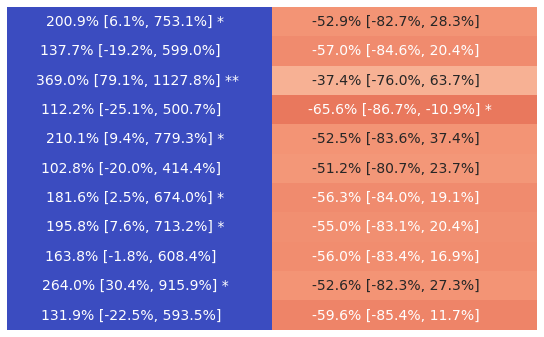

In [35]:
fig, ax = plt.subplots(figsize=(2*4.75,2*2.97)) 

sns.heatmap(-df_kit_effects[['OF', 'ZF']]
              , robust=True, annot = df_kit_effects[['OF_annot', 'ZF_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

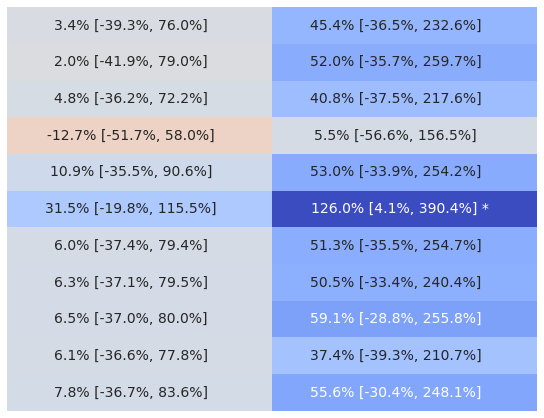

In [36]:
fig, ax = plt.subplots(figsize=(2*4.75,10/8*2*2.97)) 

sns.heatmap(-df_temp_effects_O[['OR', 'OH']]
              , robust=True, annot = df_temp_effects_O[['OR_annot', 'OH_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

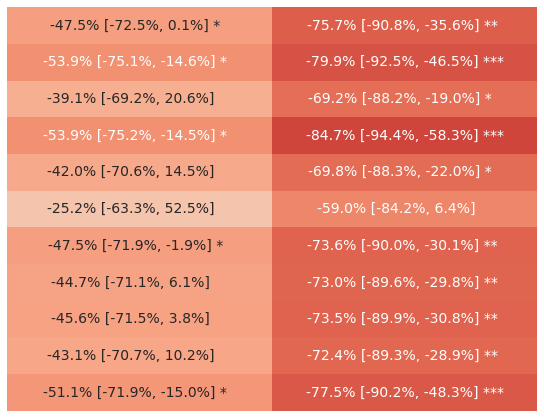

In [37]:
fig, ax = plt.subplots(figsize=(2*4.75,10/8*2*2.97)) 

sns.heatmap(-df_temp_effects_Z[['ZR', 'ZH']]
              , robust=True, annot = df_temp_effects_Z[['ZR_annot', 'ZH_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

In [ ]:
# sensitivity analysis: within-patient (fixed effects)

In [64]:
feature = 'MicrobesPerGram'

df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
df_temp = pd.concat([df_temp, pd.get_dummies(df_temp.Patient)], axis=1)
df_temp['log_feature'] = np.log(df_temp[feature])

mod = smf.ols('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\')) + D01 + D02 + D03 + D04 + D05 + D06 + D07 + D08 + D09',
                  df_temp)

est = mod.fit(cov_type='HC3')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_feature   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     12.47
Date:                Fri, 23 Sep 2022   Prob (F-statistic):           2.30e-21
Time:                        16:50:50   Log-Likelihood:                -390.94
No. Observations:                 209   AIC:                             813.9
Df Residuals:                     193   BIC:                             867.4
Df Model:                          15                                         
Covariance Type:                  HC3                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          26.9833      0.827     32.641      0.000      25.363      28.604
C(Sample_Type, Treatment(reference='NF'))[T.OF]     1.1015      0.557      1.977      0.048       0.009       2.194
C(Sample_Type, Treatment(reference='NF'))[T.OH]     1.4757      0.519      2.842      0.004       0.458       2.494
C(Sample_Type, Treatment(reference='NF'))[T.OR]     1.1349      0.473      2.399      0.016       0.208       2.062
C(Sample_Type, Treatment(reference='NF'))[T.ZF]    -0.7527      0.513     -1.468      0.142      -1.758       0.252
C(Sample_Type, Treatment(reference='NF'))[T.ZH]    -2.1797      0.539     -4.045      0.000      -3.236      -1.124
C(Sample_Type, Treatment(reference='NF'))[T.ZR]    -1.3970      0.483     -2.892      0.004      -2.344      -0.450
D01                                                 1.1065      0.592      1.868      0.062      -0.055       2.268
D02                                                 1.5082      0.637      2.368      0.018       0.260       2.757
D03                                                -0.0648      0.815     -0.079      0.937      -1.663       1.533
D04                                                 1.8294      0.600      3.049      0.002       0.653       3.005
D05                                                 0.8542      0.589      1.451      0.147      -0.300       2.008
D06                                                 1.2553      0.577      2.176      0.030       0.125       2.386
D07                                                 1.2316      0.603      2.042      0.041       0.050       2.414
D08                                                 1.0721      0.624      1.718      0.086      -0.151       2.295
D09                                                 0.5406      0.621      0.870      0.384      -0.677       1.758
==============================================================================
Omnibus:                      111.646   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              703.549
Skew:                          -1.999   Prob(JB):                    1.68e-153
Kurtosis:                      11.050   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [54]:
features = ['MicrobesPerGram',  'Absolute Abundance: Firmicutes', 'Absolute Abundance: Bacteroidetes',
       'Absolute Abundance: Actinobacteria']

df_kit_effects_fe = pd.DataFrame([], columns = ['feature', 'OF', 'OF_annot', 'ZF', 'ZF_annot'])
df_temp_effects_O_fe = pd.DataFrame([], columns = ['feature', 'OR', 'OR_annot', 'OH', 'OH_annot'])
df_temp_effects_Z_fe = pd.DataFrame([], columns = ['feature', 'ZR', 'ZR_annot', 'ZH', 'ZH_annot'])
df_preds_fe = pd.DataFrame([], columns = ['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high'])


i = 0

for feature in features:
    print(feature)

    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = pd.concat([df_temp, pd.get_dummies(df_temp.Patient)], axis=1)
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.ols('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\')) + D01 + D02 + D03 + D04 + D05 + D06 + D07 + D08 + D09',
                  df_temp)

    est = mod.fit(cov_type='HC3')
    
    
    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'NF\'))[T.OF]',
            'C(Sample_Type, Treatment(reference=\'NF\'))[T.ZF]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_kit_effects_fe.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]



    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = pd.concat([df_temp, pd.get_dummies(df_temp.Patient)], axis=1)
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.ols('log_feature ~ C(Sample_Type, Treatment(reference=\'OF\')) + D01 + D02 + D03 + D04 + D05 + D06 + D07 + D08 + D09',
                  df_temp)

    est = mod.fit(cov_type='HC3')

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'OF\'))[T.OR]',
            'C(Sample_Type, Treatment(reference=\'OF\'))[T.OH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_O_fe.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]



    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = pd.concat([df_temp, pd.get_dummies(df_temp.Patient)], axis=1)
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.ols('log_feature ~ C(Sample_Type, Treatment(reference=\'ZF\')) + D01 + D02 + D03 + D04 + D05 + D06 + D07 + D08 + D09',
                  df_temp)

    est = mod.fit(cov_type='HC3')


    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZR]',
            'C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_Z_fe.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]

    i += 1

MicrobesPerGram
Absolute Abundance: Firmicutes
Absolute Abundance: Bacteroidetes
Absolute Abundance: Actinobacteria


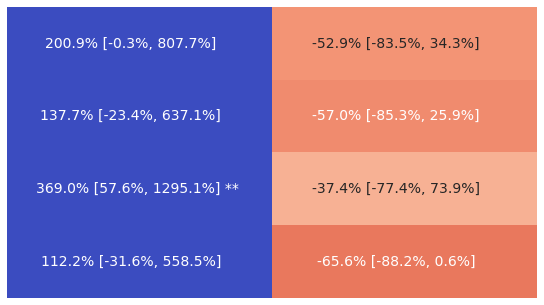

In [53]:
fig, ax = plt.subplots(figsize=(2*4.75,0.9 * 2*2.97)) 

sns.heatmap(-df_kit_effects_fe[['OF', 'ZF']]
              , robust=True, annot = df_kit_effects_fe[['OF_annot', 'ZF_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 



In [66]:
df_temp_effects_Z_fe

feature         ZR                    ZR_annot  \
0                     MicrobesPerGram -47.496308   -47.5% [-74.3%, 7.2%]       
1      Absolute Abundance: Firmicutes -53.920169  -53.9% [-77.4%, -5.9%] *     
2   Absolute Abundance: Bacteroidetes -39.052230  -39.1% [-70.5%, 25.8%]       
3  Absolute Abundance: Actinobacteria -53.912114  -53.9% [-77.8%, -4.2%] *     

          ZH                     ZH_annot  
0 -75.998134  -76.0% [-89.7%, -44.0%] ***  
1 -80.104638  -80.1% [-91.5%, -53.5%] ***  
2 -69.717219  -69.7% [-87.1%, -29.0%] **   
3 -84.724030  -84.7% [-93.5%, -64.2%] ***

In [39]:
#relative abundances

In [40]:
df['Relative Abundance: Unclassified + Root'] = df['Relative Abundance: Unclassified'] + df['Relative Abundance: Root']

In [41]:
export_cols = ['MicrobesPerGram',  'mean_16s_count', 'DNAConcentration',
    'Relative Abundance: Firmicutes', 'Relative Abundance: Bacteroidetes',
       'Relative Abundance: Actinobacteria',
       'Relative Abundance: Other Bacteria', 
    'Relative Abundance: Viruses',
       'Relative Abundance: Fungi',
               'Relative Abundance: Unclassified + Root',
    'Relative Abundance: Unclassified','Richness 0.01%', 'Richness 0.001%', 'Richness 0.0001%',
       'Richness 0.00001%', 'Richness Any%', 'Shannon Entropy', 'Inv Simpson']
df[['Patient', 'Sample_Type', 'Replication'] + export_cols].sort_index().to_csv('raw_data2.csv')


export_cols_abs = ['MicrobesPerGram',  'mean_16s_count', 'DNAConcentration',
    'Absolute Abundance: Firmicutes', 'Absolute Abundance: Bacteroidetes',
       'Absolute Abundance: Actinobacteria',
       'Absolute Abundance: Other Bacteria', 
    'Absolute Abundance: Viruses',
       'Absolute Abundance: Fungi',
               'Absolute Abundance: Unclassified + Root',
    'Absolute Abundance: Unclassified','Richness 100M', 'Richness 10M', 'Richness 1M']
df[['Patient', 'Sample_Type', 'Replication'] + export_cols_abs].sort_index().to_csv('raw_data_abs.csv')

In [42]:
df_temp.describe()

Absolute Abundance: Other  log_feature
count               2.090000e+02   209.000000
mean                3.474813e+08    18.055168
std                 9.719038e+08     2.169050
min                 1.926677e+03     7.563552
25%                 2.372671e+07    16.982112
50%                 9.497209e+07    18.369094
75%                 2.681039e+08    19.406885
max                 1.048738e+10    23.073439

In [43]:
#do them all 

features = ['Relative Abundance: Firmicutes', 'Relative Abundance: Bacteroidetes',
       'Relative Abundance: Actinobacteria',
       'Relative Abundance: Other Bacteria', 'Relative Abundance: Viruses',
       'Relative Abundance: Fungi', 'Relative Abundance: Unclassified',
       'Relative Abundance: Root', 'Relative Abundance: Other']

features = export_cols_abs

df_kit_effects = pd.DataFrame([], columns = ['feature', 'OF', 'OF_annot', 'p_OF', 'ZF', 'ZF_annot', 'p_ZF'])
df_temp_effects_O = pd.DataFrame([], columns = ['feature', 'OR', 'OR_annot', 'p_OR', 'OH', 'OH_annot', 'p_OH'])
df_temp_effects_Z = pd.DataFrame([], columns = ['feature', 'ZR', 'ZR_annot', 'p_ZR', 'ZH', 'ZH_annot', 'p_ZH'])
df_preds = pd.DataFrame([], columns = ['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high'])

i = 0

for feature in features:
    print(feature)

    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = df_temp[df_temp[feature]>0].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])
    

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()
    
    ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])
    preds = pd.concat([ref, est.get_prediction(ref).summary_frame(alpha=.05)], axis=1)
    preds['prediction'] = np.exp(preds['mean'])
    preds['CI_high'] =  np.exp(preds.mean_ci_upper)
    preds['CI_low'] = np.exp(preds.mean_ci_lower)
    preds['feature'] = feature
    
    df_preds = pd.concat([df_preds, preds[['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high']]])

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'NF\'))[T.OF]',
            'C(Sample_Type, Treatment(reference=\'NF\'))[T.ZF]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_kit_effects.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0],                    
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0],
        temp[temp.feature == cols[1]].p.values[0], ]
    
    
    ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])


    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = df_temp[df_temp[feature]>0].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'OF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'OF\'))[T.OR]',
            'C(Sample_Type, Treatment(reference=\'OF\'))[T.OH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_O.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0],                    
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0],
        temp[temp.feature == cols[1]].p.values[0], ]



    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = df_temp[df_temp[feature]>0].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'ZF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZR]',
            'C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_Z.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0],                    
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0],
        temp[temp.feature == cols[1]].p.values[0], ]

    i += 1

MicrobesPerGram
mean_16s_count
DNAConcentration
Absolute Abundance: Firmicutes
Absolute Abundance: Bacteroidetes
Absolute Abundance: Actinobacteria
Absolute Abundance: Other Bacteria
Absolute Abundance: Viruses
Absolute Abundance: Fungi
Absolute Abundance: Unclassified + Root
Absolute Abundance: Unclassified
Richness 100M
Richness 10M
Richness 1M


In [44]:
df_preds.to_csv('temp.csv')

In [45]:
df_temp_effects_Z

feature         ZR  \
0                           MicrobesPerGram -47.496308   
1                            mean_16s_count  -1.372435   
2                          DNAConcentration -41.698536   
3            Absolute Abundance: Firmicutes -53.920169   
4         Absolute Abundance: Bacteroidetes -39.052230   
5        Absolute Abundance: Actinobacteria -53.912114   
6        Absolute Abundance: Other Bacteria -42.019726   
7               Absolute Abundance: Viruses -25.167092   
8                 Absolute Abundance: Fungi -47.497455   
9   Absolute Abundance: Unclassified + Root -44.656728   
10         Absolute Abundance: Unclassified -45.623458   
11                            Richness 100M -15.414855   
12                             Richness 10M -26.388913   
13                              Richness 1M -30.684714   

                       ZR_annot   p_ZR         ZH  \
0     -47.5% [-72.5%, 0.1%] *    0.050 -75.674620   
1      -1.4% [-2.4%, -0.4%] **   0.007  -1.154104   
2   -41.7% [-55.3%, -24.0%] ***  0.000 -48.143250   
3   -53.9% [-75.1%, -14.6%] *    0.014 -79.903581   
4    -39.1% [-69.2%, 20.6%]      0.155 -69.150146   
5   -53.9% [-75.2%, -14.5%] *    0.014 -84.661638   
6    -42.0% [-70.6%, 14.5%]      0.116 -69.784721   
7    -25.2% [-63.3%, 52.5%]      0.425 -59.013454   
8    -47.5% [-71.9%, -1.9%] *    0.044 -73.605734   
9     -44.7% [-71.1%, 6.1%]      0.075 -73.012914   
10    -45.6% [-71.5%, 3.8%]      0.065 -73.526462   
11    -15.4% [-34.7%, 9.6%]      0.205 -38.459966   
12   -26.4% [-42.7%, -5.4%] *    0.017 -44.399284   
13   -30.7% [-49.1%, -5.7%] *    0.020 -52.063192   

                       ZH_annot   p_ZH  
0   -75.7% [-90.8%, -35.6%] **   0.004  
1      -1.2% [-2.0%, -0.3%] **   0.005  
2   -48.1% [-61.1%, -30.9%] ***  0.000  
3   -79.9% [-92.5%, -46.5%] ***  0.001  
4   -69.2% [-88.2%, -19.0%] *    0.017  
5   -84.7% [-94.4%, -58.3%] ***  0.000  
6   -69.8% [-88.3%, -22.0%] *    0.013  
7     -59.0% [-84.2%, 6.4%]      0.067  
8   -73.6% [-90.0%, -30.1%] **   0.007  
9   -73.0% [-89.6%, -29.8%] **   0.007  
10  -73.5% [-89.9%, -30.8%] **   0.007  
11  -38.5% [-57.5%, -10.8%] **   0.010  
12  -44.4% [-61.5%, -19.7%] **   0.002  
13  -52.1% [-70.5%, -22.2%] **   0.003

In [46]:
df[df.Sample_Type == 'ZF'][features].mean() *100

MicrobesPerGram                            1.514926e+14
mean_16s_count                             4.590110e+02
DNAConcentration                           1.057733e+03
Absolute Abundance: Firmicutes             8.291116e+13
Absolute Abundance: Bacteroidetes          4.537130e+13
Absolute Abundance: Actinobacteria         5.410994e+12
Absolute Abundance: Other Bacteria         2.153482e+12
Absolute Abundance: Viruses                3.190488e+11
Absolute Abundance: Fungi                  1.188154e+11
Absolute Abundance: Unclassified + Root    1.519907e+13
Absolute Abundance: Unclassified           1.082514e+13
Richness 100M                              8.026667e+03
Richness 10M                               2.362333e+04
Richness 1M                                8.167667e+04
dtype: float64

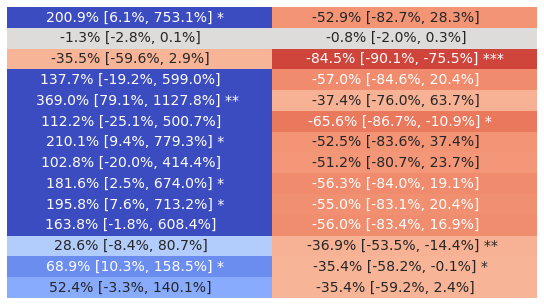

In [47]:
fig, ax = plt.subplots(figsize=(2*4.75,0.9 * 2*2.97)) 

sns.heatmap(-df_kit_effects[['OF', 'ZF']]
              , robust=True, annot = df_kit_effects[['OF_annot', 'ZF_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

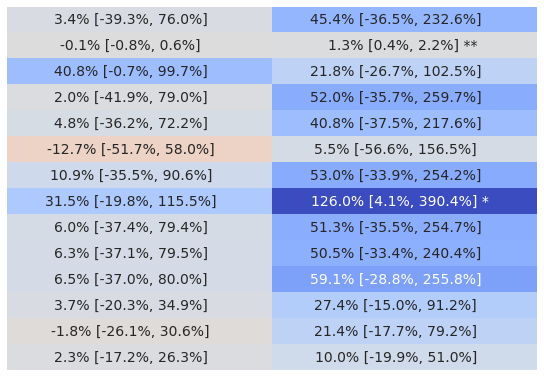

In [48]:
fig, ax = plt.subplots(figsize=(2*4.75,0.9 * 10/8*2*2.97)) 

sns.heatmap(-df_temp_effects_O[['OR', 'OH']]
              , robust=True, annot = df_temp_effects_O[['OR_annot', 'OH_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

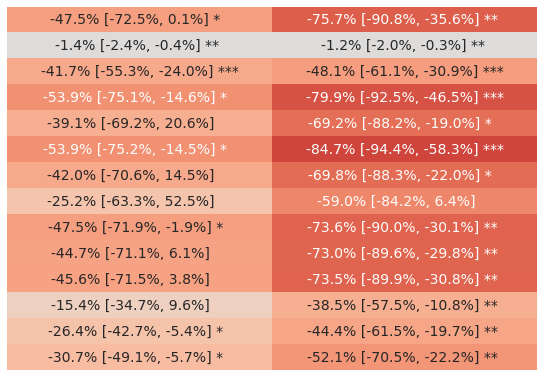

In [49]:
fig, ax = plt.subplots(figsize=(2*4.75,0.9 * 10/8*2*2.97)) 

sns.heatmap(-df_temp_effects_Z[['ZR', 'ZH']]
              , robust=True, annot = df_temp_effects_Z[['ZR_annot', 'ZH_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

In [50]:
# same with fixed effects

In [51]:
features = ['Relative Abundance: Firmicutes', 'Relative Abundance: Bacteroidetes',
       'Relative Abundance: Actinobacteria',
       'Relative Abundance: Other Bacteria', 'Relative Abundance: Viruses',
       'Relative Abundance: Fungi', 'Relative Abundance: Unclassified',
       'Relative Abundance: Root', 'Relative Abundance: Other']

df_kit_effects_fe = pd.DataFrame([], columns = ['feature', 'OF', 'OF_annot', 'ZF', 'ZF_annot'])
df_temp_effects_O_fe = pd.DataFrame([], columns = ['feature', 'OR', 'OR_annot', 'OH', 'OH_annot'])
df_temp_effects_Z_fe = pd.DataFrame([], columns = ['feature', 'ZR', 'ZR_annot', 'ZH', 'ZH_annot'])

i = 0

for feature in features:
    print(feature)

    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = pd.concat([df_temp, pd.get_dummies(df_temp.Patient)], axis=1)
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.ols('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\')) + D01 + D02 + D03 + D04 + D05 + D06 + D07 + D08 + D09',
                  df_temp)

    est = mod.fit(cov_type='HC3')

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'NF\'))[T.OF]',
            'C(Sample_Type, Treatment(reference=\'NF\'))[T.ZF]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_kit_effects_fe.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]



    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = pd.concat([df_temp, pd.get_dummies(df_temp.Patient)], axis=1)
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.ols('log_feature ~ C(Sample_Type, Treatment(reference=\'OF\')) + D01 + D02 + D03 + D04 + D05 + D06 + D07 + D08 + D09',
                  df_temp)

    est = mod.fit(cov_type='HC3')

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'OF\'))[T.OR]',
            'C(Sample_Type, Treatment(reference=\'OF\'))[T.OH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_O_fe.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]



    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = pd.concat([df_temp, pd.get_dummies(df_temp.Patient)], axis=1)
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.ols('log_feature ~ C(Sample_Type, Treatment(reference=\'ZF\')) + D01 + D02 + D03 + D04 + D05 + D06 + D07 + D08 + D09',
                  df_temp)

    est = mod.fit(cov_type='HC3')


    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZR]',
            'C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_Z_fe.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]

    i += 1

Relative Abundance: Firmicutes
Relative Abundance: Bacteroidetes
Relative Abundance: Actinobacteria
Relative Abundance: Other Bacteria
Relative Abundance: Viruses
Relative Abundance: Fungi
Relative Abundance: Unclassified
Relative Abundance: Root
Relative Abundance: Other


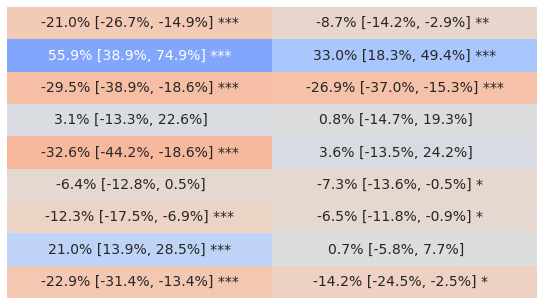

In [52]:
fig, ax = plt.subplots(figsize=(2*4.75,0.9 * 2*2.97)) 

sns.heatmap(-df_kit_effects_fe[['OF', 'ZF']]
              , robust=True, annot = df_kit_effects_fe[['OF_annot', 'ZF_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

In [53]:
# alpha diversity

In [54]:
df.columns

Index(['MicrobesPerGram', 'mean_16s_count', 'Total Count', 'DNAConcentration',
       'Absolute Abundance: Firmicutes', 'Absolute Abundance: Bacteroidetes',
       'Absolute Abundance: Proteobacteria',
       'Absolute Abundance: Actinobacteria',
       'Absolute Abundance: Other Bacteria', 'Absolute Abundance: Viruses',
       'Absolute Abundance: Fungi', 'Absolute Abundance: Unclassified',
       'Absolute Abundance: Root', 'Absolute Abundance: Other',
       'Relative Abundance: Firmicutes', 'Relative Abundance: Bacteroidetes',
       'Relative Abundance: Proteobacteria',
       'Relative Abundance: Actinobacteria',
       'Relative Abundance: Other Bacteria', 'Relative Abundance: Viruses',
       'Relative Abundance: Fungi', 'Relative Abundance: Unclassified',
       'Relative Abundance: Root', 'Relative Abundance: Other',
       'Richness 0.01%', 'Richness 0.001%', 'Richness 0.0001%',
       'Richness 0.00001%', 'Richness Any%', 'Richness 100M', 'Richness 10M',
       'Richness 1M

In [55]:
#do them all 

features = ['Shannon Entropy', 'Inv Simpson',
       'Richness 0.01%', 'Richness 0.001%', 'Richness 0.0001%',
       'Richness 0.00001%', 'Richness Any%']

df_kit_effects = pd.DataFrame([], columns = ['feature', 'OF', 'OF_annot', 'ZF', 'ZF_annot'])
df_temp_effects_O = pd.DataFrame([], columns = ['feature', 'OR', 'OR_annot', 'OH', 'OH_annot'])
df_temp_effects_Z = pd.DataFrame([], columns = ['feature', 'ZR', 'ZR_annot', 'ZH', 'ZH_annot'])
df_preds = pd.DataFrame([], columns = ['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high'])


i = 0

for feature in features:
    print(feature)

    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])
    preds = pd.concat([ref, est.get_prediction(ref).summary_frame(alpha=.05)], axis=1)
    preds['prediction'] = np.exp(preds['mean'])
    preds['CI_high'] =  np.exp(preds.mean_ci_upper)
    preds['CI_low'] = np.exp(preds.mean_ci_lower)
    preds['feature'] = feature
    
    df_preds = pd.concat([df_preds, preds[['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high']]])
    
    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'NF\'))[T.OF]',
            'C(Sample_Type, Treatment(reference=\'NF\'))[T.ZF]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_kit_effects.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]



    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'OF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'OF\'))[T.OR]',
            'C(Sample_Type, Treatment(reference=\'OF\'))[T.OH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_O.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]



    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'ZF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZR]',
            'C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_Z.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0]]

    i += 1

Shannon Entropy
Inv Simpson
Richness 0.01%
Richness 0.001%
Richness 0.0001%
Richness 0.00001%
Richness Any%


In [56]:
df_preds.tail()

feature Sample_Type   prediction       CI_low      CI_high
2  Richness Any%          OR  2745.351132  2680.030797  2812.263518
3  Richness Any%          OH  2760.475323  2689.052680  2833.794988
4  Richness Any%          ZF  2790.797132  2683.977483  2901.868098
5  Richness Any%          ZR  2761.527627  2653.285960  2874.185049
6  Richness Any%          ZH  2762.352836  2668.756496  2859.231708

In [57]:
df_kit_effects

feature         OF                     OF_annot         ZF  \
0    Shannon Entropy  -9.028210    -9.0% [-12.4%, -5.6%] ***  -3.397741   
1        Inv Simpson -28.403790  -28.4% [-36.2%, -19.7%] *** -12.682718   
2     Richness 0.01%  -6.278509     -6.3% [-9.5%, -2.9%] ***  -4.491191   
3    Richness 0.001%  -9.079020    -9.1% [-13.2%, -4.7%] ***  -6.719493   
4   Richness 0.0001%  -8.824733    -8.8% [-12.4%, -5.1%] ***  -6.822279   
5  Richness 0.00001%  -5.113878     -5.1% [-7.0%, -3.2%] ***  -4.098501   
6      Richness Any%  -0.421729      -0.4% [-2.2%, 1.4%]      -0.113452   

                     ZF_annot  
0    -3.4% [-5.5%, -1.2%] **   
1  -12.7% [-19.7%, -5.1%] ***  
2    -4.5% [-8.0%, -0.9%] *    
3   -6.7% [-10.7%, -2.6%] **   
4   -6.8% [-10.1%, -3.5%] ***  
5    -4.1% [-5.9%, -2.2%] ***  
6     -0.1% [-2.4%, 2.3%]

In [58]:
df[df.Sample_Type == 'ZF'][features].mean()

Shannon Entropy         2.826130
Inv Simpson             8.539705
Richness 0.01%         88.066667
Richness 0.001%       257.833333
Richness 0.0001%      959.200000
Richness 0.00001%    2329.200000
Richness Any%        2799.400000
dtype: float64

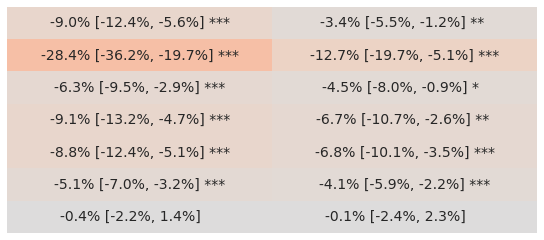

In [59]:
fig, ax = plt.subplots(figsize=(2*4.75,0.7 * 2*2.97)) 

sns.heatmap(-df_kit_effects[['OF', 'ZF']]
              , robust=True, annot = df_kit_effects[['OF_annot', 'ZF_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

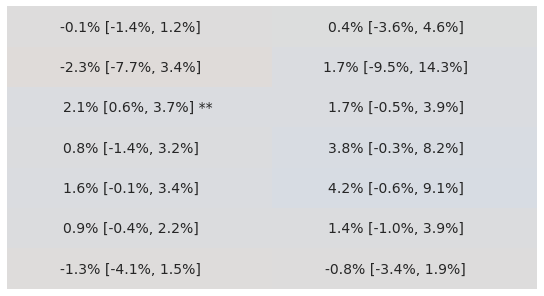

In [60]:
fig, ax = plt.subplots(figsize=(2*4.75,0.7 * 10/8*2*2.97)) 

sns.heatmap(-df_temp_effects_O[['OR', 'OH']]
              , robust=True, annot = df_temp_effects_O[['OR_annot', 'OH_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

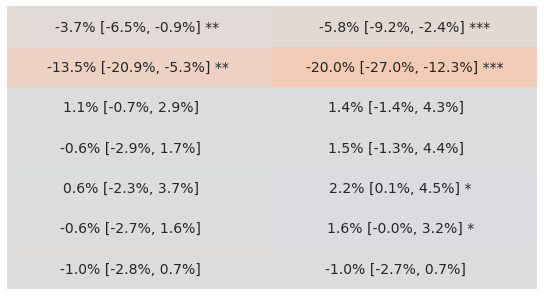

In [61]:
fig, ax = plt.subplots(figsize=(2*4.75,0.7 * 10/8*2*2.97)) 

sns.heatmap(-df_temp_effects_Z[['ZR', 'ZH']]
              , robust=True, annot = df_temp_effects_Z[['ZR_annot', 'ZH_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

In [62]:
#richness plots

In [63]:
feature = 'Richness 0.01%'

df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
df_temp['log_feature'] = np.log(df_temp[feature])

mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 log_feature   No. Observations:                  209
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                  20
                      Estimating Equations   Max. cluster size:                  21
Family:                           Gaussian   Mean cluster size:                20.9
Dependence structure:         Exchangeable   Num. iterations:                     3
Date:                     Sat, 27 Aug 2022   Scale:                           0.016
Covariance type:                    robust   Time:                         15:47:58
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           4.5182      0.042    106.669      0.000       4.435       4.601
C(Sample_Type, Treatment(reference='NF'))[T.OF]    -0.0648      0.018     -3.624      0.000      -0.100      -0.030
C(Sample_Type, Treatment(reference='NF'))[T.OH]    -0.0484      0.022     -2.243      0.025      -0.091      -0.006
C(Sample_Type, Treatment(reference='NF'))[T.OR]    -0.0439      0.019     -2.258      0.024      -0.082      -0.006
C(Sample_Type, Treatment(reference='NF'))[T.ZF]    -0.0460      0.019     -2.433      0.015      -0.083      -0.009
C(Sample_Type, Treatment(reference='NF'))[T.ZH]    -0.0320      0.026     -1.225      0.221      -0.083       0.019
C(Sample_Type, Treatment(reference='NF'))[T.ZR]    -0.0348      0.022     -1.612      0.107      -0.077       0.008
==============================================================================
Skew:                          0.0137   Kurtosis:                      -0.6926
Centered skew:                 0.0629   Centered kurtosis:              0.4725
==============================================================================
"""

In [64]:
ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['mean'] = np.exp(preds['mean'])
preds['err_high'] =  np.exp(preds.mean_ci_upper) - preds['mean']
preds['err_low'] = preds['mean'] -  np.exp(preds.mean_ci_lower)

In [65]:
preds

Sample_Type       mean   mean_se  mean_ci_lower  mean_ci_upper  err_high  \
0          NF  91.668193  0.042357       4.435158       4.601193  7.934905   
1          OF  85.912798  0.040071       4.374795       4.531870  7.019428   
2          OR  87.732974  0.037882       4.400050       4.548546  6.761934   
3          OH  87.335258  0.038004       4.395269       4.544240  6.753613   
4          ZF  87.551200  0.033344       4.406870       4.537577  5.912886   
5          ZR  88.529543  0.036985       4.410846       4.555827  6.655856   
6          ZH  88.777476  0.041875       4.404060       4.568206  7.593566   

    err_low  
0  7.302769  
1  6.489231  
2  6.278058  
3  6.268845  
4  5.538814  
5  6.190444  
6  6.995230

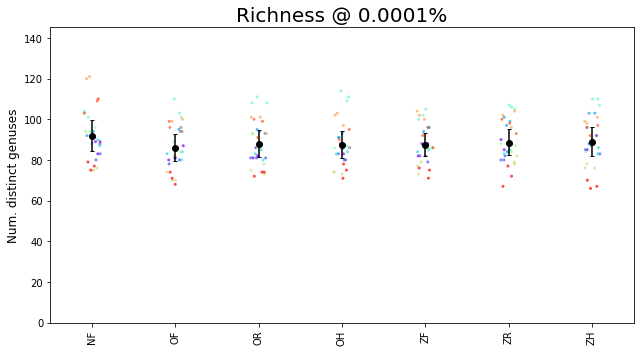

In [66]:
plt.figure(figsize=(12,8))

ii = 0
for pp in set(df.Patient):
    df_temp = df[df.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Sample_Type', y=feature, data=df_temp, 
                  order = ['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'],
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii)
    ii += 1
    #sns.swarmplot('Sample_Type', 'entropy', data=df_temp, jitter=0.2)
    

temp = preds
data = temp.groupby('Sample_Type')[['mean', 'err_low', 'err_high']].mean().reindex(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder = 12)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 13)

plt.title('Richness @ 0.0001%' , fontsize=20)

plt.xlabel('', fontsize=12)
plt.ylabel('Num. distinct genuses', fontsize=12)

#plt.yscale('log')
plt.ylim([0, df[feature].max()*1.2])

plt.tight_layout()
#fig1=plt.show()

#plt.ylim([0,1])

plt.savefig('temp.jpg')


In [67]:
#genus level results

In [297]:
df_rel_genus['Patient'] = df_rel_genus.index.str.split('-').str[0]
df_rel_genus['Sample_Type'] = df_rel_genus.index.str.split('-').str[1]
df_rel_genus['Replication'] = df_rel_genus.index.str.split('-').str[2]

In [387]:
df_temp = pd.DataFrame(df_rel_genus[df_rel_genus.Sample_Type == 'NF'].mean()).rename(columns={0:'Avg'})
df_temp['phylum'] = df_temp.index.str.split(':').str[0]
df_temp['name'] = df_temp.index
genera_to_study  = df_temp[df_temp.Avg > 0.0001].sort_values(by=['phylum', 'Avg']).name.values

In [388]:
#10 patients, 21 samples each
df_rel_genus.groupby('Patient').size()

Patient
D01    21
D02    21
D03    20
D04    21
D05    21
D06    21
D07    21
D08    21
D09    21
D10    21
dtype: int64

In [389]:
#7 Sample Types, 30 samples each
df_rel_genus.groupby('Sample_Type').size()

Sample_Type
NF    30
OF    30
OH    30
OR    30
ZF    30
ZH    29
ZR    30
dtype: int64

In [390]:
#3 Replications for each
df_rel_genus.groupby('Replication').size()

Replication
R1    70
R2    69
R3    70
dtype: int64

In [391]:
df_rel_genus[['Patient', 'Sample_Type', 'Replication'] + list(genera_to_study)].sort_index().to_csv('temp.csv')

In [413]:
#do them all 

df_kit_effects = pd.DataFrame([], columns = ['feature', 'OF', 'OF_annot', 'p_OF', 'ZF', 'ZF_annot', 'p_ZF'])
df_temp_effects_O = pd.DataFrame([], columns = ['feature', 'OR', 'OR_annot', 'p_OR', 'OH', 'OH_annot', 'p_OH'])
df_temp_effects_Z = pd.DataFrame([], columns = ['feature', 'ZR', 'ZR_annot', 'p_ZR', 'ZH', 'ZH_annot', 'p_ZH'])
df_preds = pd.DataFrame([], columns = ['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high'])

i = 0

for feature in genera_to_study:
    print(feature)
    
    if df_rel_genus[df_rel_genus[feature]> 0].shape[0] < 209:
        print('some zeros')

    df_temp = df_rel_genus[df_rel_genus[feature]> 0][[feature, 'Sample_Type', 'Patient']].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
                  'Patient',
                  df_temp[df_temp[feature]> 0],
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()
    
    ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])
    preds = pd.concat([ref, est.get_prediction(ref).summary_frame(alpha=.05)], axis=1)
    preds['prediction'] = np.exp(preds['mean'])
    preds['CI_high'] =  np.exp(preds.mean_ci_upper)
    preds['CI_low'] = np.exp(preds.mean_ci_lower)
    preds['feature'] = feature
    
    df_preds = pd.concat([df_preds, preds[['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high']]])

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'NF\'))[T.OF]',
            'C(Sample_Type, Treatment(reference=\'NF\'))[T.ZF]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(est.summary2().tables[1]['P>|z|'].loc[cols]) #list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] ' 

    df_kit_effects.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0],
        temp[temp.feature == cols[1]].p.values[0]]



    df_temp = df_rel_genus[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'OF\'))',
                  'Patient',
                  df_temp[df_temp[feature]> 0],
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'OF\'))[T.OR]',
            'C(Sample_Type, Treatment(reference=\'OF\'))[T.OH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(est.summary2().tables[1]['P>|z|'].loc[cols]) #list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] ' 

    df_temp_effects_O.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0],
        temp[temp.feature == cols[1]].p.values[0]]



    df_temp = df_rel_genus[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'ZF\'))',
                  'Patient',
                  df_temp[df_temp[feature]> 0],
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZR]',
            'C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] =  list(est.summary2().tables[1]['P>|z|'].loc[cols]) #list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  

    df_temp_effects_Z.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0],
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0],
        temp[temp.feature == cols[1]].p.values[0]]

    i += 1

Actinobacteria: Actinomyces
Actinobacteria: Cryptobacterium
Actinobacteria: Streptomyces
Actinobacteria: Coriobacteriaceae: environmental samples
Actinobacteria: unclassified Coriobacteriia
Actinobacteria: Olsenella
Actinobacteria: unclassified Eggerthellales
Actinobacteria: Enterorhabdus
Actinobacteria: Parolsenella
Actinobacteria: Gordonibacter
Actinobacteria: unclassified Coriobacteriaceae
Actinobacteria: Eggerthella
Actinobacteria: Collinsella
Actinobacteria: Bifidobacterium
Bacteroidetes: unclassified Prevotellaceae
Bacteroidetes: Paraprevotella
Bacteroidetes: unclassified Bacteroidales (miscellaneous)
Bacteroidetes: Prevotellaceae: environmental samples
Bacteroidetes: unclassified Rikenellaceae
Bacteroidetes: Barnesiella
Bacteroidetes: Butyricimonas
Bacteroidetes: unclassified Bacteroidaceae
Bacteroidetes: Odoribacter
Bacteroidetes: Parabacteroides
Bacteroidetes: Prevotella
Bacteroidetes: Alistipes
Bacteroidetes: Bacteroides
Firmicutes: Carnobacterium
Firmicutes: Bacillus
Firmicu

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Firmicutes: Dysosmobacter
Firmicutes: Agathobaculum
Firmicutes: Anaeromassilibacillus
Firmicutes: Ruthenibacterium
Firmicutes: Sellimonas
Firmicutes: Desulfotomaculum
Firmicutes: Candidatus Borkfalkia
some zeros
Firmicutes: Veillonella


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Firmicutes: Turicibacter
Firmicutes: Lachnotalea
Firmicutes: Tyzzerella
Firmicutes: Neglecta
Firmicutes: Holdemania
Firmicutes: Enterococcus
Firmicutes: Hungatella
Firmicutes: unclassified Eubacteriaceae
Firmicutes: Pseudoflavonifractor
Firmicutes: Clostridioides
Firmicutes: Eisenbergiella
Firmicutes: Anaerotruncus
Firmicutes: Erysipelatoclostridium
Firmicutes: Lactobacillus
Firmicutes: Romboutsia
Firmicutes: Intestinimonas
Firmicutes: unclassified Clostridia
Firmicutes: Lachnospiraceae: environmental samples
Firmicutes: Phascolarctobacterium
Firmicutes: Fusicatenibacter
Firmicutes: Butyrivibrio
Firmicutes: Mitsuokella
Firmicutes: unclassified Erysipelotrichaceae
Firmicutes: Clostridiales: environmental samples
Firmicutes: Megasphaera
Firmicutes: unclassified Oscillospiraceae
Firmicutes: Lachnospira
Firmicutes: Anaerobutyricum
Firmicutes: Flavonifractor
Firmicutes: unclassified Clostridiaceae
Firmicutes: Lachnoclostridium
Firmicutes: Coprobacillus
Firmicutes: Streptococcus
Firmicutes: 

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


null: crAss-like viruses


In [75]:
df_preds.to_csv('temp.csv')

In [414]:
from statsmodels.stats import multitest

In [415]:
test_list = df_preds[(df_preds.prediction > 0.001)].feature.drop_duplicates().values

In [416]:
test_list = df_preds[(df_preds.prediction > 0.001)].feature.drop_duplicates().values

df_temp = df_preds[(df_preds.feature.isin(test_list)) & (df_preds.Sample_Type == 'NF')][['feature', 'prediction']]
df_temp['phylum'] = df_temp.feature.str.split(':').str[0]
df_temp['genus'] = df_temp.feature.str.split(':').str[1]

df_t1 = df_kit_effects[['feature', 'OF', 'OF_annot', 'p_OF']].rename(columns = {'OF': 'change', 'OF_annot': 'annot', 'p_OF': 'p'})
df_t1['comp'] = 'OF'
df_t2 = df_kit_effects[['feature', 'ZF', 'ZF_annot', 'p_ZF']].rename(columns = {'ZF': 'change', 'ZF_annot': 'annot', 'p_ZF': 'p'})
df_t2['comp'] = 'ZF'

df_tt = pd.concat([df_t1, df_t2], axis=0)
df_tt.sort_values(by='p', inplace=True)
df_tt['BH'] = multitest.fdrcorrection(df_tt.p, alpha=0.10, method='indep', is_sorted=True)[0].astype(int)
df_tt['annot'] = df_tt['annot'] + list(pd.cut(df_tt['BH'], [-2, 0.5, 2], labels=['  ', ' *']))

df_t1 = df_tt[df_tt.comp == 'OF'][['feature', 'change', 'annot']].rename(columns = {'annot': 'OF_annot', 'change':'OF'})
df_t2 = df_tt[df_tt.comp == 'ZF'][['feature', 'change', 'annot']].rename(columns = {'annot': 'ZF_annot', 'change':'ZF'})

df_kit_effects = pd.merge(pd.merge(df_temp, df_t1, on='feature'), df_t2, on='feature')[['feature', 'phylum', 'genus', 'prediction', 'OF', 'OF_annot', 'ZF', 'ZF_annot']].rename(columns={'prediction': 'Avg Rel. Abundance (NF)'})

In [417]:
df_kit_effects 

feature          phylum  \
0                         Actinobacteria: Eggerthella  Actinobacteria   
1                         Actinobacteria: Collinsella  Actinobacteria   
2                     Actinobacteria: Bifidobacterium  Actinobacteria   
3                          Bacteroidetes: Odoribacter   Bacteroidetes   
4                      Bacteroidetes: Parabacteroides   Bacteroidetes   
5                           Bacteroidetes: Prevotella   Bacteroidetes   
6                            Bacteroidetes: Alistipes   Bacteroidetes   
7                          Bacteroidetes: Bacteroides   Bacteroidetes   
8   Firmicutes: Lachnospiraceae: environmental sam...      Firmicutes   
9                        Firmicutes: Fusicatenibacter      Firmicutes   
10   Firmicutes: Clostridiales: environmental samples      Firmicutes   
11          Firmicutes: unclassified Oscillospiraceae      Firmicutes   
12                            Firmicutes: Lachnospira      Firmicutes   
13                        Firmicutes: Anaerobutyricum      Firmicutes   
14                         Firmicutes: Flavonifractor      Firmicutes   
15            Firmicutes: unclassified Clostridiaceae      Firmicutes   
16                      Firmicutes: Lachnoclostridium      Firmicutes   
17                          Firmicutes: Coprobacillus      Firmicutes   
18                          Firmicutes: Streptococcus      Firmicutes   
19                           Firmicutes: Anaerostipes      Firmicutes   
20                         Firmicutes: Butyricicoccus      Firmicutes   
21                               Firmicutes: Gemmiger      Firmicutes   
22                        Firmicutes: Subdoligranulum      Firmicutes   
23  Firmicutes: unclassified Firmicutes sensu stri...      Firmicutes   
24                          Firmicutes: Oscillibacter      Firmicutes   
25                                  Firmicutes: Dorea      Firmicutes   
26      Firmicutes: Firmicutes: environmental samples      Firmicutes   
27  Firmicutes: unclassified Clostridiales (miscel...      Firmicutes   
28                            Firmicutes: Coprococcus      Firmicutes   
29                            Firmicutes: Eubacterium      Firmicutes   
30                              Firmicutes: Roseburia      Firmicutes   
31                            Firmicutes: Clostridium      Firmicutes   
32           Firmicutes: unclassified Ruminococcaceae      Firmicutes   
33           Firmicutes: unclassified Lachnospiraceae      Firmicutes   
34                                Firmicutes: Blautia      Firmicutes   
35                           Firmicutes: Ruminococcus      Firmicutes   
36                       Firmicutes: Faecalibacterium      Firmicutes   

                                                genus  \
0                                         Eggerthella   
1                                         Collinsella   
2                                     Bifidobacterium   
3                                         Odoribacter   
4                                     Parabacteroides   
5                                          Prevotella   
6                                           Alistipes   
7                                         Bacteroides   
8                                     Lachnospiraceae   
9                                    Fusicatenibacter   
10                                      Clostridiales   
11                      unclassified Oscillospiraceae   
12                                        Lachnospira   
13                                    Anaerobutyricum   
14                                     Flavonifractor   
15                        unclassified Clostridiaceae   
16                                  Lachnoclostridium   
17                                      Coprobacillus   
18                                      Streptococcus   
19                                       Anaerostipes   
20                                     Butyricicoccus   
21               

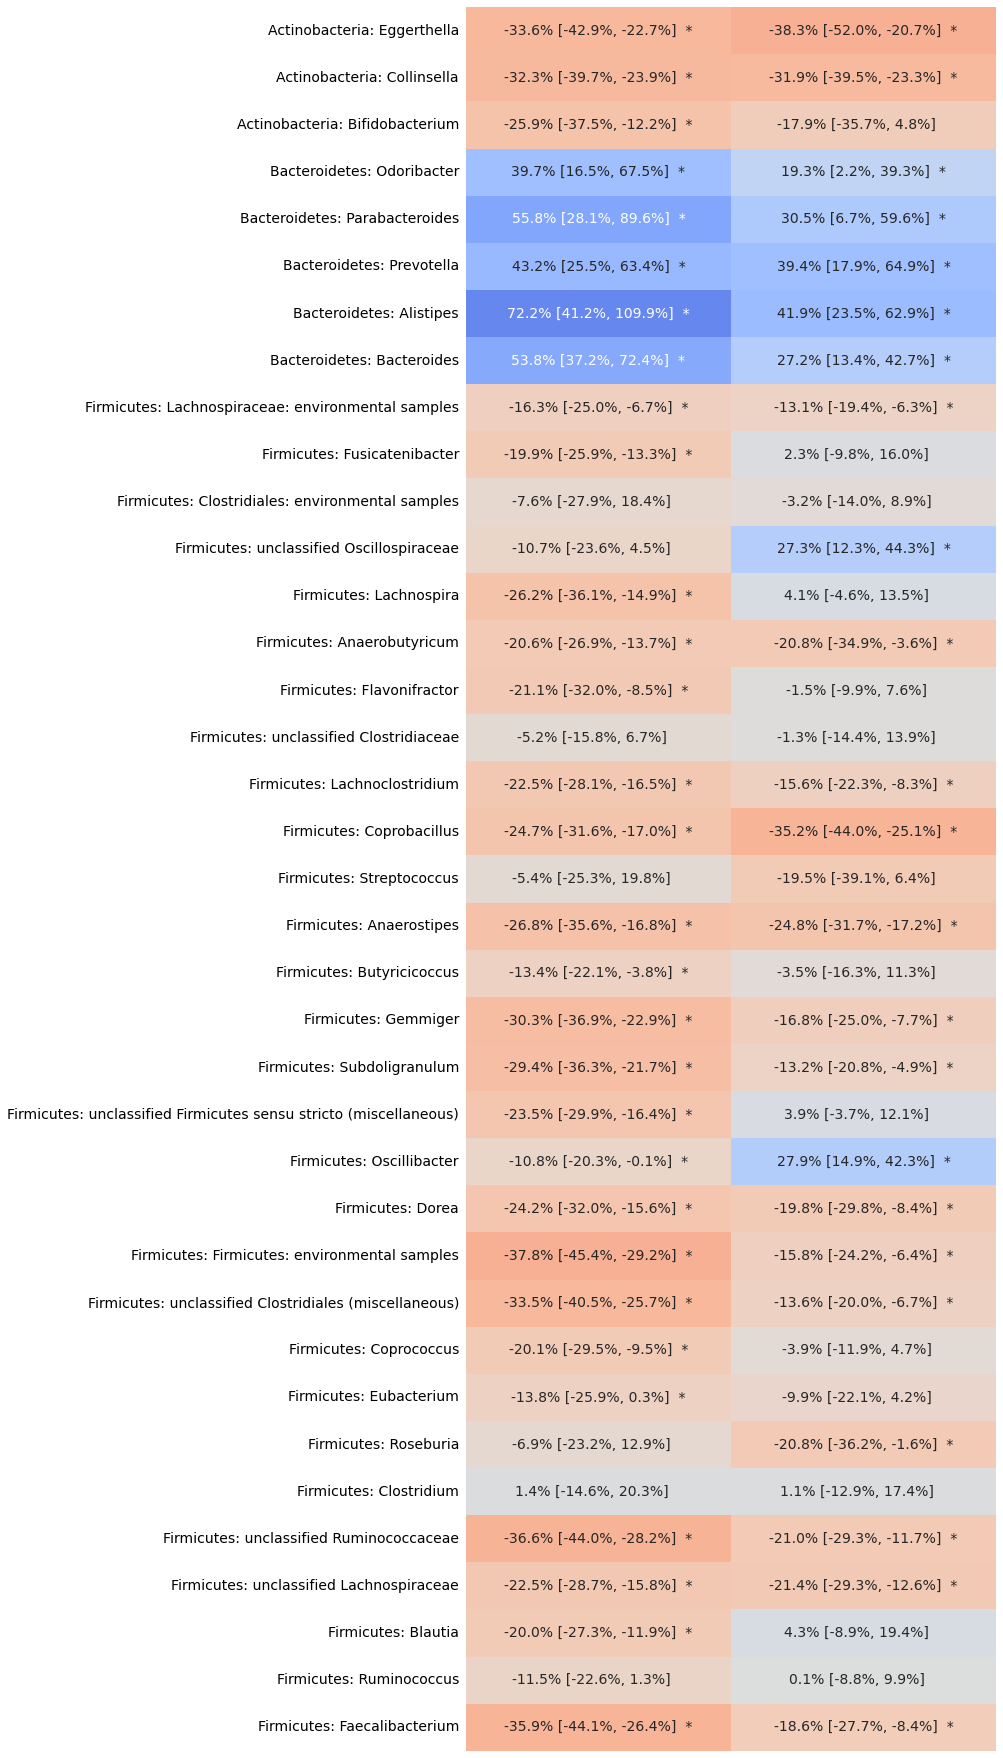

In [418]:
fig, ax = plt.subplots(figsize=(2*4.75, 5.4* 2*2.97)) 

sns.heatmap(-df_kit_effects[['OF', 'ZF']]
              , robust=True, annot = df_kit_effects[['OF_annot', 'ZF_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=df_kit_effects.feature, 
            #label_kws={'size':14},
            xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 
ax.set_yticklabels(labels = df_kit_effects.feature, fontsize=14)

fig.savefig('temp.jpg', bbox_inches='tight')

In [419]:
df_temp_effects_O

feature         OR  \
0                          Actinobacteria: Actinomyces -10.590368   
1                      Actinobacteria: Cryptobacterium -14.472447   
2                         Actinobacteria: Streptomyces   3.475469   
3    Actinobacteria: Coriobacteriaceae: environment... -14.265242   
4          Actinobacteria: unclassified Coriobacteriia  -8.207938   
..                                                 ...        ...   
113             Verrucomicrobia: unclassified Opitutae  -4.092775   
114                       Verrucomicrobia: Akkermansia  14.875997   
115                           null: Guerin_crAss_Alpha  35.762204   
116                           null: Guerin_crAss_Delta   6.999577   
117                           null: crAss-like viruses  28.685470   

                    OR_annot      p_OR         OH                OH_annot  \
0     -10.6% [-23.2%, 4.1%]   0.149586  -5.169878  -5.2% [-21.3%, 14.2%]    
1    -14.5% [-23.9%, -3.8%]   0.009036 -22.453555  -22.5% [-43.0%, 5.4%]    
2        3.5% [-2.6%, 9.9%]   0.264718  13.522602    13.5% [2.8%, 25.4%]    
3    -14.3% [-23.8%, -3.5%]   0.010624 -16.057705  -16.1% [-30.2%, 1.0%]    
4      -8.2% [-22.2%, 8.3%]   0.308885  -7.203652  -7.2% [-39.2%, 41.7%]    
..                       ...       ...        ...                     ...   
113   -4.1% [-16.6%, 10.3%]   0.558805   1.630389   1.6% [-10.8%, 15.8%]    
114     14.9% [2.5%, 28.7%]   0.016655   5.357591    5.4% [-8.2%, 20.9%]    
115    35.8% [14.1%, 61.5%]   0.000558  10.081865  10.1% [-22.8%, 56.9%]    
116     7.0% [-4.2%, 19.5%]   0.229550  13.648362   13.6% [-7.3%, 39.3%]    
117     28.7% [5.8%, 56.5%]   0.011574  53.805546   53.8% [25.7%, 88.1%]    

         p_OH  
0    0.576167  
1    0.104686  
2    0.012159  
3    0.062995  
4    0.729318  
..        ...  
113  0.808674  
114  0.457988  
115  0.595320  
116  0.217763  
117  0.000028  

[118 rows x 7 columns]

In [420]:
#test_list = df_preds[(df_preds.prediction > 0.001)].feature.drop_duplicates().values

df_temp = df_preds[(df_preds.feature.isin(test_list)) & (df_preds.Sample_Type == 'OF')][['feature', 'prediction']]
df_temp['phylum'] = df_temp.feature.str.split(':').str[0]
df_temp['genus'] = df_temp.feature.str.split(':').str[1]

df_t1 = df_temp_effects_O[['feature', 'OR', 'OR_annot', 'p_OR']].rename(columns = {'OR': 'change', 'OR_annot': 'annot', 'p_OR': 'p'})
df_t1['comp'] = 'OR'
df_t2 = df_temp_effects_O[['feature', 'OH', 'OH_annot', 'p_OH']].rename(columns = {'OH': 'change', 'OH_annot': 'annot', 'p_OH': 'p'})
df_t2['comp'] = 'OH'

df_tt = pd.concat([df_t1, df_t2], axis=0)
df_tt.sort_values(by='p', inplace=True)
df_tt['BH'] = multitest.fdrcorrection(df_tt.p, alpha=0.10, method='indep', is_sorted=True)[0].astype(int)
df_tt['annot'] = df_tt['annot'] + list(pd.cut(df_tt['BH'], [-2, 0.5, 2], labels=['  ', ' *']))

df_t1 = df_tt[df_tt.comp == 'OR'][['feature', 'change', 'annot']].rename(columns = {'annot': 'OR_annot', 'change':'OR'})
df_t2 = df_tt[df_tt.comp == 'OH'][['feature', 'change', 'annot']].rename(columns = {'annot': 'OH_annot', 'change':'OH'})

df_temp_effects_O = pd.merge(pd.merge(df_temp, df_t1, on='feature'), df_t2, on='feature')[['feature', 'phylum', 'genus', 'prediction', 'OR', 'OR_annot', 'OH', 'OH_annot']].rename(columns={'prediction': 'Avg Rel. Abundance (OF)'})

In [421]:
df_temp_effects_O

feature          phylum  \
0                         Actinobacteria: Eggerthella  Actinobacteria   
1                         Actinobacteria: Collinsella  Actinobacteria   
2                     Actinobacteria: Bifidobacterium  Actinobacteria   
3                          Bacteroidetes: Odoribacter   Bacteroidetes   
4                      Bacteroidetes: Parabacteroides   Bacteroidetes   
5                           Bacteroidetes: Prevotella   Bacteroidetes   
6                            Bacteroidetes: Alistipes   Bacteroidetes   
7                          Bacteroidetes: Bacteroides   Bacteroidetes   
8   Firmicutes: Lachnospiraceae: environmental sam...      Firmicutes   
9                        Firmicutes: Fusicatenibacter      Firmicutes   
10   Firmicutes: Clostridiales: environmental samples      Firmicutes   
11          Firmicutes: unclassified Oscillospiraceae      Firmicutes   
12                            Firmicutes: Lachnospira      Firmicutes   
13                        Firmicutes: Anaerobutyricum      Firmicutes   
14                         Firmicutes: Flavonifractor      Firmicutes   
15            Firmicutes: unclassified Clostridiaceae      Firmicutes   
16                      Firmicutes: Lachnoclostridium      Firmicutes   
17                          Firmicutes: Coprobacillus      Firmicutes   
18                          Firmicutes: Streptococcus      Firmicutes   
19                           Firmicutes: Anaerostipes      Firmicutes   
20                         Firmicutes: Butyricicoccus      Firmicutes   
21                               Firmicutes: Gemmiger      Firmicutes   
22                        Firmicutes: Subdoligranulum      Firmicutes   
23  Firmicutes: unclassified Firmicutes sensu stri...      Firmicutes   
24                          Firmicutes: Oscillibacter      Firmicutes   
25                                  Firmicutes: Dorea      Firmicutes   
26      Firmicutes: Firmicutes: environmental samples      Firmicutes   
27  Firmicutes: unclassified Clostridiales (miscel...      Firmicutes   
28                            Firmicutes: Coprococcus      Firmicutes   
29                            Firmicutes: Eubacterium      Firmicutes   
30                              Firmicutes: Roseburia      Firmicutes   
31                            Firmicutes: Clostridium      Firmicutes   
32           Firmicutes: unclassified Ruminococcaceae      Firmicutes   
33           Firmicutes: unclassified Lachnospiraceae      Firmicutes   
34                                Firmicutes: Blautia      Firmicutes   
35                           Firmicutes: Ruminococcus      Firmicutes   
36                       Firmicutes: Faecalibacterium      Firmicutes   

                                                genus  \
0                                         Eggerthella   
1                                         Collinsella   
2                                     Bifidobacterium   
3                                         Odoribacter   
4                                     Parabacteroides   
5                                          Prevotella   
6                                           Alistipes   
7                                         Bacteroides   
8                                     Lachnospiraceae   
9                                    Fusicatenibacter   
10                                      Clostridiales   
11                      unclassified Oscillospiraceae   
12                                        Lachnospira   
13                                    Anaerobutyricum   
14                                     Flavonifractor   
15                        unclassified Clostridiaceae   
16                                  Lachnoclostridium   
17                                      Coprobacillus   
18                                      Streptococcus   
19                                       Anaerostipes   
20                                     Butyricicoccus   
21               

In [423]:
#test_list = df_preds[(df_preds.prediction > 0.001)].feature.drop_duplicates().values

df_temp = df_preds[(df_preds.feature.isin(test_list)) & (df_preds.Sample_Type == 'ZF')][['feature', 'prediction']]
df_temp['phylum'] = df_temp.feature.str.split(':').str[0]
df_temp['genus'] = df_temp.feature.str.split(':').str[1]

df_t1 = df_temp_effects_Z[['feature', 'ZR', 'ZR_annot', 'p_ZR']].rename(columns = {'ZR': 'change', 'ZR_annot': 'annot', 'p_ZR': 'p'})
df_t1['comp'] = 'ZR'
df_t2 = df_temp_effects_Z[['feature', 'ZH', 'ZH_annot', 'p_ZH']].rename(columns = {'ZH': 'change', 'ZH_annot': 'annot', 'p_ZH': 'p'})
df_t2['comp'] = 'ZH'

df_tt = pd.concat([df_t1, df_t2], axis=0)
df_tt.sort_values(by='p', inplace=True)
df_tt['BH'] = multitest.fdrcorrection(df_tt.p, alpha=0.10, method='indep', is_sorted=True)[0].astype(int)
df_tt['annot'] = df_tt['annot'] + list(pd.cut(df_tt['BH'], [-2, 0.5, 2], labels=['  ', ' *']))

df_t1 = df_tt[df_tt.comp == 'ZR'][['feature', 'change', 'annot']].rename(columns = {'annot': 'ZR_annot', 'change':'ZR'})
df_t2 = df_tt[df_tt.comp == 'ZH'][['feature', 'change', 'annot']].rename(columns = {'annot': 'ZH_annot', 'change':'ZH'})

df_temp_effects_Z = pd.merge(pd.merge(df_temp, df_t1, on='feature'), df_t2, on='feature')[['feature', 'phylum', 'genus', 'prediction', 'ZR', 'ZR_annot', 'ZH', 'ZH_annot']].rename(columns={'prediction': 'Avg Rel. Abundance (ZF)'})

In [424]:
df_temp_effects_Z

feature          phylum  \
0                         Actinobacteria: Eggerthella  Actinobacteria   
1                         Actinobacteria: Collinsella  Actinobacteria   
2                     Actinobacteria: Bifidobacterium  Actinobacteria   
3                          Bacteroidetes: Odoribacter   Bacteroidetes   
4                      Bacteroidetes: Parabacteroides   Bacteroidetes   
5                           Bacteroidetes: Prevotella   Bacteroidetes   
6                            Bacteroidetes: Alistipes   Bacteroidetes   
7                          Bacteroidetes: Bacteroides   Bacteroidetes   
8   Firmicutes: Lachnospiraceae: environmental sam...      Firmicutes   
9                        Firmicutes: Fusicatenibacter      Firmicutes   
10   Firmicutes: Clostridiales: environmental samples      Firmicutes   
11          Firmicutes: unclassified Oscillospiraceae      Firmicutes   
12                            Firmicutes: Lachnospira      Firmicutes   
13                        Firmicutes: Anaerobutyricum      Firmicutes   
14                         Firmicutes: Flavonifractor      Firmicutes   
15            Firmicutes: unclassified Clostridiaceae      Firmicutes   
16                      Firmicutes: Lachnoclostridium      Firmicutes   
17                          Firmicutes: Coprobacillus      Firmicutes   
18                          Firmicutes: Streptococcus      Firmicutes   
19                           Firmicutes: Anaerostipes      Firmicutes   
20                         Firmicutes: Butyricicoccus      Firmicutes   
21                               Firmicutes: Gemmiger      Firmicutes   
22                        Firmicutes: Subdoligranulum      Firmicutes   
23  Firmicutes: unclassified Firmicutes sensu stri...      Firmicutes   
24                          Firmicutes: Oscillibacter      Firmicutes   
25                                  Firmicutes: Dorea      Firmicutes   
26      Firmicutes: Firmicutes: environmental samples      Firmicutes   
27  Firmicutes: unclassified Clostridiales (miscel...      Firmicutes   
28                            Firmicutes: Coprococcus      Firmicutes   
29                            Firmicutes: Eubacterium      Firmicutes   
30                              Firmicutes: Roseburia      Firmicutes   
31                            Firmicutes: Clostridium      Firmicutes   
32           Firmicutes: unclassified Ruminococcaceae      Firmicutes   
33           Firmicutes: unclassified Lachnospiraceae      Firmicutes   
34                                Firmicutes: Blautia      Firmicutes   
35                           Firmicutes: Ruminococcus      Firmicutes   
36                       Firmicutes: Faecalibacterium      Firmicutes   

                                                genus  \
0                                         Eggerthella   
1                                         Collinsella   
2                                     Bifidobacterium   
3                                         Odoribacter   
4                                     Parabacteroides   
5                                          Prevotella   
6                                           Alistipes   
7                                         Bacteroides   
8                                     Lachnospiraceae   
9                                    Fusicatenibacter   
10                                      Clostridiales   
11                      unclassified Oscillospiraceae   
12                                        Lachnospira   
13                                    Anaerobutyricum   
14                                     Flavonifractor   
15                        unclassified Clostridiaceae   
16                                  Lachnoclostridium   
17                                      Coprobacillus   
18                                      Streptococcus   
19                                       Anaerostipes   
20                                     Butyricicoccus   
21               

In [ ]:
# Here's a little analysis we didn't end up using in the paper that looks at merging the conditions a few at a time.

#the goal was to make a pretty figure, but we scrapped it.

In [431]:
feature = 'Relative Abundance: Bacteroidetes'


df_values = pd.DataFrame([], columns = ['Sample_Type', 'Patient',feature])
df_fit = pd.DataFrame([], columns = ['Sample_Type', 'mean', 'mean_ci_lower', 'mean_ci_upper', 'err_high', 'err_low'])



df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
df_temp['log_feature'] = np.log(df_temp[feature])

mod = smf.gee('log_feature ~ C(Sample_Type)',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['mean'] = np.exp(preds['mean'])
preds['mean_ci_lower'] = np.exp(preds['mean_ci_lower'])
preds['mean_ci_upper'] = np.exp(preds['mean_ci_upper'])
preds['err_high'] =  preds.mean_ci_upper - preds['mean']
preds['err_low'] = preds['mean'] -  preds.mean_ci_lower

df_values = pd.concat([df_values, df_temp[df_temp.Sample_Type == 'NF'][['Sample_Type', 'Patient',feature]]], axis=0)
df_fit = pd.concat([df_fit, preds[preds.Sample_Type == 'NF'][['Sample_Type', 'mean', 'mean_ci_lower', 'mean_ci_upper', 'err_high', 'err_low']]], axis=0)


df_temp.loc[df_temp.Sample_Type == 'NF', 'Sample_Type'] = 'NF_OF_ZF'
df_temp.loc[df_temp.Sample_Type == 'OF', 'Sample_Type'] = 'NF_OF_ZF'
df_temp.loc[df_temp.Sample_Type == 'ZF', 'Sample_Type'] = 'NF_OF_ZF'

mod = smf.gee('log_feature ~ C(Sample_Type)',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
ref = pd.DataFrame(['NF_OF_ZF', 'OR', 'OH', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['mean'] = np.exp(preds['mean'])
preds['mean_ci_lower'] = np.exp(preds['mean_ci_lower'])
preds['mean_ci_upper'] = np.exp(preds['mean_ci_upper'])
preds['err_high'] =  preds.mean_ci_upper - preds['mean']
preds['err_low'] = preds['mean'] -  preds.mean_ci_lower

df_values = pd.concat([df_values, df_temp[df_temp.Sample_Type == 'NF_OF_ZF'][['Sample_Type', 'Patient',feature]]], axis=0)
df_fit = pd.concat([df_fit, preds[preds.Sample_Type == 'NF_OF_ZF'][['Sample_Type', 'mean', 'mean_ci_lower', 'mean_ci_upper', 'err_high', 'err_low']]], axis=0)


df_temp.loc[df_temp.Sample_Type == 'NF_OF_ZF', 'Sample_Type'] = 'NF_OF_OR_ZF_ZR'
df_temp.loc[df_temp.Sample_Type == 'OR', 'Sample_Type'] = 'NF_OF_OR_ZF_ZR'
df_temp.loc[df_temp.Sample_Type == 'ZR', 'Sample_Type'] = 'NF_OF_OR_ZF_ZR'

mod = smf.gee('log_feature ~ C(Sample_Type)',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
ref = pd.DataFrame(['NF_OF_OR_ZF_ZR', 'OH', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['mean'] = np.exp(preds['mean'])
preds['mean_ci_lower'] = np.exp(preds['mean_ci_lower'])
preds['mean_ci_upper'] = np.exp(preds['mean_ci_upper'])
preds['err_high'] =  preds.mean_ci_upper - preds['mean']
preds['err_low'] = preds['mean'] -  preds.mean_ci_lower

df_values = pd.concat([df_values, df_temp[df_temp.Sample_Type == 'NF_OF_OR_ZF_ZR'][['Sample_Type', 'Patient',feature]]], axis=0)
df_fit = pd.concat([df_fit, preds[preds.Sample_Type == 'NF_OF_OR_ZF_ZR'][['Sample_Type', 'mean', 'mean_ci_lower', 'mean_ci_upper', 'err_high', 'err_low']]], axis=0)


df_temp.loc[df_temp.Sample_Type == 'NF_OF_OR_ZF_ZR', 'Sample_Type'] = 'NF_OF_OR_OH_ZF_ZR_ZH'
df_temp.loc[df_temp.Sample_Type == 'OH', 'Sample_Type'] = 'NF_OF_OR_OH_ZF_ZR_ZH'
df_temp.loc[df_temp.Sample_Type == 'ZH', 'Sample_Type'] = 'NF_OF_OR_OH_ZF_ZR_ZH'


mod = smf.gee('log_feature ~ C(Sample_Type)',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
ref = pd.DataFrame(['NF_OF_OR_OH_ZF_ZR_ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['mean'] = np.exp(preds['mean'])
preds['mean_ci_lower'] = np.exp(preds['mean_ci_lower'])
preds['mean_ci_upper'] = np.exp(preds['mean_ci_upper'])
preds['err_high'] =  preds.mean_ci_upper - preds['mean']
preds['err_low'] = preds['mean'] -  preds.mean_ci_lower

df_values = pd.concat([df_values, df_temp[df_temp.Sample_Type == 'NF_OF_OR_OH_ZF_ZR_ZH'][['Sample_Type', 'Patient',feature]]], axis=0)
df_fit = pd.concat([df_fit, preds[preds.Sample_Type == 'NF_OF_OR_OH_ZF_ZR_ZH'][['Sample_Type', 'mean', 'mean_ci_lower', 'mean_ci_upper', 'err_high', 'err_low']]], axis=0)


In [432]:
df_values.sort_values(by=['Patient', 'Sample_Type']).to_csv('temp.csv')

In [433]:
df_fit

Sample_Type      mean  mean_ci_lower  mean_ci_upper  err_high  \
0                    NF  0.224767       0.173528       0.291136  0.066369   
0              NF_OF_ZF  0.286564       0.233713       0.351367  0.064803   
0        NF_OF_OR_ZF_ZR  0.310763       0.252522       0.382436  0.071673   
0  NF_OF_OR_OH_ZF_ZR_ZH  0.323257       0.263861       0.396023  0.072766   

    err_low  
0  0.051239  
0  0.052851  
0  0.058241  
0  0.059396

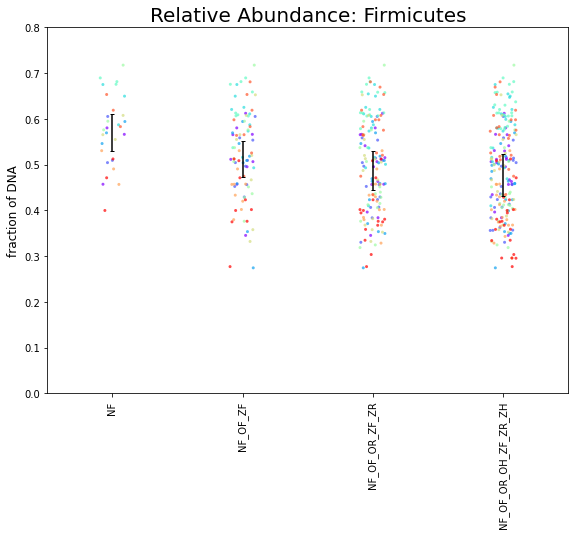

In [161]:
fig, ax = plt.subplots(1,1,figsize=(16,8))

ii = 0

for pp in set(df.Patient):
    df_temp = df_values[df_values.Patient==pp].copy()
    sns.stripplot(x='Sample_Type', y=feature, data=df_temp, 
                  order = ['NF', 'NF_OF_ZF', 'NF_OF_OR_ZF_ZR', 'NF_OF_OR_OH_ZF_ZR_ZH'],
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii, ax=ax)
    ii += 1

temp = df_fit
data = temp.groupby('Sample_Type')[['mean', 'err_low', 'err_high']].mean().reindex(['NF', 'NF_OF_ZF', 'NF_OF_OR_ZF_ZR', 'NF_OF_OR_OH_ZF_ZR_ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder = 12, ax=ax)
#plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 13)

ax.set_title('Relative Abundance: Firmicutes' , fontsize=20)

ax.set_xlabel('', fontsize=12)
plt.ylabel('fraction of DNA', fontsize=12)

#plt.yscale('log')
plt.ylim([0, 0.8])

plt.tight_layout()
#fig1=plt.show()

#plt.ylim([0,1])
plt.gcf().set_size_inches(8, 10)

plt.savefig('temp.jpg')

In [ ]:
#beta diversity

In [105]:
from skbio.diversity import alpha_diversity
from skbio.diversity import get_alpha_diversity_metrics
from skbio.diversity import beta_diversity
from skbio.diversity import get_beta_diversity_metrics

In [106]:
genera = list(df_rel_genus.columns[:-3])

In [107]:
df_temp = df_rel_genus[df_rel_genus.Patient.isin(['D01'])][genera].copy()
bc_dm = beta_diversity('braycurtis', df_temp)
bc_dm.ids = list(df_temp.index)

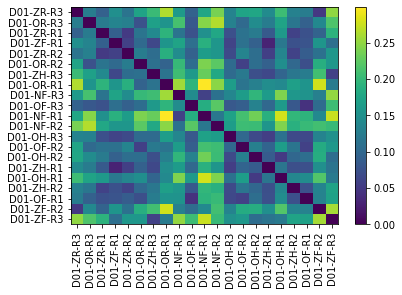

In [108]:
bc_dm

In [126]:
df_bc = pd.DataFrame([], columns = ['Patient', 'Protocol_1', 'Protocol_2', 'bcdist'])
zz = 0

for pp in np.sort(list(set(df.Patient))):
    print(pp)
    df_temp = df_rel_genus[df_rel_genus.Patient == pp][genera].copy().sort_index()
    bc_dm = beta_diversity('braycurtis', df_temp)
    bc_dm.ids = list(df_temp.index)

    for ii in range(bc_dm.shape[0]):
        for jj in range(bc_dm.shape[0]):
            if ii != jj:
                protocol_1 = df_temp.index[ii].split('-')[1]
                protocol_2 = df_temp.index[jj].split('-')[1]
                bc = bc_dm[ii,jj]
                
                df_bc.loc[zz] = [pp, protocol_1, protocol_2, bc]
                zz += 1

D01
D02
D03
D04
D05
D06
D07
D08
D09
D10


In [127]:
df_bc['Protocols'] = df_bc['Protocol_1'] + '_' +  df_bc['Protocol_2']

In [129]:
df_bc.to_csv('temp.csv')

<AxesSubplot:>

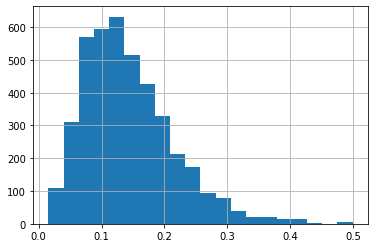

In [130]:
df_bc.bcdist.hist(bins=20)

In [142]:
df_bc['log_dist'] = np.log(df_bc.bcdist)

mod = smf.gee('log_dist ~ C(Protocols, Treatment(reference=\'NF_NF\'))',
              'Patient',
              df_bc,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                    log_dist   No. Observations:                 4160
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                 380
                      Estimating Equations   Max. cluster size:                 420
Family:                           Gaussian   Mean cluster size:               416.0
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Sun, 14 Aug 2022   Scale:                           0.221
Covariance type:                    robust   Time:                         17:43:55
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -2.5479      0.097    -26.191      0.000      -2.739      -2.357
C(Protocols, Treatment(reference='NF_NF'))[T.NF_OF]     0.7298      0.122      5.990      0.000       0.491       0.969
C(Protocols, Treatment(reference='NF_NF'))[T.NF_OH]     0.7641      0.131      5.817      0.000       0.507       1.022
C(Protocols, Treatment(reference='NF_NF'))[T.NF_OR]     0.8580      0.093      9.245      0.000       0.676       1.040
C(Protocols, Treatment(reference='NF_NF'))[T.NF_ZF]     0.5498      0.100      5.506      0.000       0.354       0.745
C(Protocols, Treatment(reference='NF_NF'))[T.NF_ZH]     0.9928      0.117      8.490      0.000       0.764       1.222
C(Protocols, Treatment(reference='NF_NF'))[T.NF_ZR]     0.8719      0.117      7.480      0.000       0.643       1.100
C(Protocols, Treatment(reference='NF_NF'))[T.OF_NF]     0.7298      0.122      5.990      0.000       0.491       0.969
C(Protocols, Treatment(reference='NF_NF'))[T.OF_OF]     0.0942      0.228      0.414      0.679      -0.352       0.540
C(Protocols, Treatment(reference='NF_NF'))[T.OF_OH]     0.4457      0.172      2.585      0.010       0.108       0.784
C(Protocols, Treatment(reference='NF_NF'))[T.OF_OR]     0.2530      0.152      1.666      0.096      -0.045       0.551
C(Protocols, Treatment(reference='NF_NF'))[T.OF_ZF]     0.4139      0.156      2.661      0.008       0.109       0.719
C(Protocols, Treatment(reference='NF_NF'))[T.OF_ZH]     0.5408      0.141      3.837      0.000       0.265       0.817
C(Protocols, Treatment(reference='NF_NF'))[T.OF_ZR]     0.4649      0.169      2.755      0.006       0.134       0.796
C(Protocols, Treatment(reference='NF_NF'))[T.OH_NF]     0.7641      0.131      5.817      0.000       0.507       1.022
C(Protocols, Treatment(reference='NF_NF'))[T.OH_OF]     0.4457      0.172      2.585      0.010       0.108       0.784
C(Protocols, Treatment(reference='NF_NF'))[T.OH_OH]    -0.1295      0.097     -1.342      0.180      -0.319       0.060
C(Protocols, Treatment(reference='NF_NF'))[T.OH_OR]     0.3291      0.150      2.189      0.029       0.034       0.624
C(Protocols, Treatment(reference='NF_NF'))[T.OH_ZF]     0.4203      0.144      2.926      0.003       0.139       0.702
C(Protocols, Treatment(reference='NF_NF'))[T.OH_ZH]     0.4456      0.160      2.788      0.005       0.132       0.759
C(Protocols, Treatment(reference='NF_NF'))[T.OH_ZR]     0.4537      0.150      3.028      0.002       0.160       0.747
C(Protocols, Treatment(reference='NF_NF'))[T.OR_NF]     0.8580      0.093      9.245      0.000       0.676       1.040
C(Protocols, Treatment(reference='NF_NF'))[T.OR_OF]     0.2530      0.152      1.666      0.096      -0.045     

In [149]:
ref = pd.DataFrame(set(df_bc.Protocols), columns=['Protocols'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['estimate'] = np.exp(preds['mean'])
preds['CI_low'] = np.exp(preds.mean_ci_lower)
preds['CI_high'] = np.exp(preds.mean_ci_upper)

preds['mean'] =  np.exp(preds['mean'])
preds['err_high'] = preds.CI_high - preds['mean']
preds['err_low'] = preds['mean'] - preds.CI_low


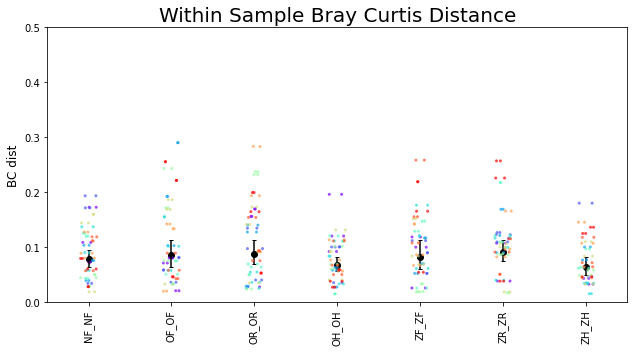

In [169]:
plt.figure(figsize=(12,8))

ii = 0
for pp in set(df.Patient):
    df_temp = df_bc[df_bc.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Protocols', y='bcdist', data=df_temp, 
                  order = ['NF_NF', 'OF_OF', 'OR_OR', 'OH_OH', 'ZF_ZF', 'ZR_ZR', 'ZH_ZH'],
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii)
    ii += 1

temp = preds
data = temp.groupby('Protocols')[['mean', 'err_low', 'err_high']].mean().reindex(['NF_NF', 'OF_OF', 'OR_OR', 'OH_OH', 'ZF_ZF', 'ZR_ZR', 'ZH_ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder=1)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 0)

plt.title('Within Sample Bray Curtis Distance', fontsize=20)
#plt.ylim([0,1])
plt.xlabel('', fontsize=12)
plt.ylabel('BC dist', fontsize=12)
plt.tight_layout()

plt.ylim([0,0.5])

plt.savefig('temp.jpg')


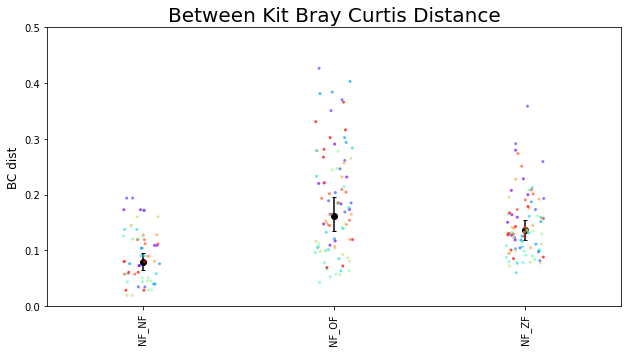

In [170]:
plt.figure(figsize=(12,8))

ii = 0
for pp in set(df.Patient):
    df_temp = df_bc[df_bc.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Protocols', y='bcdist', data=df_temp, 
                  order = ['NF_NF', 'NF_OF', 'NF_ZF'],
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii)
    ii += 1

temp = preds
data = temp.groupby('Protocols')[['mean', 'err_low', 'err_high']].mean().reindex(['NF_NF', 'NF_OF', 'NF_ZF'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder=1)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 0)

plt.title('Between Kit Bray Curtis Distance', fontsize=20)
#plt.ylim([0,1])
plt.xlabel('', fontsize=12)
plt.ylabel('BC dist', fontsize=12)
plt.tight_layout()

plt.ylim([0,0.5])
plt.savefig('temp.jpg')

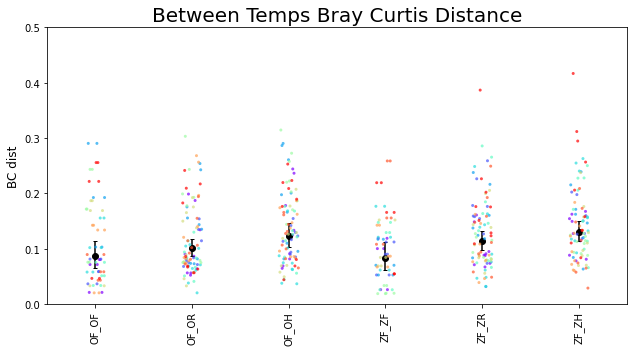

In [171]:
plt.figure(figsize=(12,8))

order = ['OF_OF', 'OF_OR', 'OF_OH', 'ZF_ZF', 'ZF_ZR', 'ZF_ZH']

ii = 0
for pp in set(df.Patient):
    df_temp = df_bc[df_bc.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Protocols', y='bcdist', data=df_temp, 
                  order = order,
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii)
    ii += 1

temp = preds
data = temp.groupby('Protocols')[['mean', 'err_low', 'err_high']].mean().reindex(order)
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder=1)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 1)

plt.title('Between Temps Bray Curtis Distance', fontsize=20)
#plt.ylim([0,1])
plt.xlabel('', fontsize=12)
plt.ylabel('BC dist', fontsize=12)
plt.tight_layout()

plt.ylim([0,0.5])
plt.savefig('temp.jpg')

In [172]:
cols = ['C(Protocols, Treatment(reference=\'NF_NF\'))[T.OF_OF]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.OR_OR]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.OH_OH]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.ZF_ZF]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.ZR_ZR]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.ZH_ZH]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.NF_OF]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.NF_ZF]']

temp = pd.DataFrame()
temp['feature'] = cols
temp['estimate'] = 100 * (np.exp( np.array(res.params[cols])) -1)
temp['low'] = 100 * (np.exp(np.array(res.conf_int()[0][cols])) -1)
temp['high'] = 100 * (np.exp(np.array(res.conf_int()[1][cols])) -1)
temp['p'] = list(pd.read_html(res.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))
temp

feature    estimate        low  \
0  C(Protocols, Treatment(reference='NF_NF'))[T.O...    9.878487 -29.667373   
1  C(Protocols, Treatment(reference='NF_NF'))[T.O...   13.248798 -19.453201   
2  C(Protocols, Treatment(reference='NF_NF'))[T.O...  -12.149867 -27.296675   
3  C(Protocols, Treatment(reference='NF_NF'))[T.Z...    5.888721 -18.773424   
4  C(Protocols, Treatment(reference='NF_NF'))[T.Z...   17.888109  -7.275518   
5  C(Protocols, Treatment(reference='NF_NF'))[T.Z...  -17.953895 -40.657015   
6  C(Protocols, Treatment(reference='NF_NF'))[T.N...  107.472811  63.401682   
7  C(Protocols, Treatment(reference='NF_NF'))[T.N...   73.285384  42.484291   

         high      p                       annot  
0   71.659760  0.679    9.9% [-29.7%, 71.7%]      
1   59.227808  0.474   13.2% [-19.5%, 59.2%]      
2    6.152584  0.180   -12.1% [-27.3%, 6.2%]      
3   38.038825  0.672    5.9% [-18.8%, 38.0%]      
4   49.880657  0.179    17.9% [-7.3%, 49.9%]      
5   13.434864  0.231  -18.0% [-40.7%, 13.4%]      
6  163.430380  0.000  107.5% [63.4%, 163.4%] ***  
7  110.744806  0.000   73.3% [42.5%, 110.7%] ***

In [173]:
df_bc['log_dist'] = np.log(df_bc.bcdist)

mod = smf.gee('log_dist ~ C(Protocols, Treatment(reference=\'OF_OF\'))',
              'Patient',
              df_bc,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()

cols = ['C(Protocols, Treatment(reference=\'OF_OF\'))[T.OF_OR]',
        'C(Protocols, Treatment(reference=\'OF_OF\'))[T.OF_OH]']

temp = pd.DataFrame()
temp['feature'] = cols
temp['estimate'] = 100 * (np.exp( np.array(res.params[cols])) -1)
temp['low'] = 100 * (np.exp(np.array(res.conf_int()[0][cols])) -1)
temp['high'] = 100 * (np.exp(np.array(res.conf_int()[1][cols])) -1)
temp['p'] = list(pd.read_html(res.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))
temp

feature   estimate        low  \
0  C(Protocols, Treatment(reference='OF_OF'))[T.O...  17.205654  -7.118046   
1  C(Protocols, Treatment(reference='OF_OF'))[T.O...  42.114445  11.462107   

        high      p                     annot  
0  47.899185  0.181  17.2% [-7.1%, 47.9%]      
1  81.196248  0.005  42.1% [11.5%, 81.2%] **

In [174]:
df_bc['log_dist'] = np.log(df_bc.bcdist)

mod = smf.gee('log_dist ~ C(Protocols, Treatment(reference=\'ZF_ZF\'))',
              'Patient',
              df_bc,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()

cols = ['C(Protocols, Treatment(reference=\'ZF_ZF\'))[T.ZF_ZR]',
        'C(Protocols, Treatment(reference=\'ZF_ZF\'))[T.ZF_ZH]']

temp = pd.DataFrame()
temp['feature'] = cols
temp['estimate'] = 100 * (np.exp( np.array(res.params[cols])) -1)
temp['low'] = 100 * (np.exp(np.array(res.conf_int()[0][cols])) -1)
temp['high'] = 100 * (np.exp(np.array(res.conf_int()[1][cols])) -1)
temp['p'] = list(pd.read_html(res.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))
temp

feature   estimate        low  \
0  C(Protocols, Treatment(reference='ZF_ZF'))[T.Z...  37.164397   1.482119   
1  C(Protocols, Treatment(reference='ZF_ZF'))[T.Z...  57.544012  15.175551   

         high      p                      annot  
0   85.392973  0.040    37.2% [1.5%, 85.4%] *    
1  115.498127  0.004  57.5% [15.2%, 115.5%] **

In [176]:
df_bc['log_dist'] = np.log(df_bc.bcdist)

mod = smf.gee('log_dist ~ C(Protocols, Treatment(reference=\'ZF_NF\'))',
              'Patient',
              df_bc,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()

cols = ['C(Protocols, Treatment(reference=\'ZF_NF\'))[T.OF_NF]',
        'C(Protocols, Treatment(reference=\'ZF_NF\'))[T.ZR_NF]',
        'C(Protocols, Treatment(reference=\'ZF_NF\'))[T.ZH_NF]',]

temp = pd.DataFrame()
temp['feature'] = cols
temp['estimate'] = 100 * (np.exp( np.array(res.params[cols])) -1)
temp['low'] = 100 * (np.exp(np.array(res.conf_int()[0][cols])) -1)
temp['high'] = 100 * (np.exp(np.array(res.conf_int()[1][cols])) -1)
temp['p'] = list(pd.read_html(res.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))
temp

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1831: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


feature   estimate        low  \
0  C(Protocols, Treatment(reference='ZF_NF'))[T.O...  19.728973   2.602380   
1  C(Protocols, Treatment(reference='ZF_NF'))[T.Z...  38.008978  21.245791   
2  C(Protocols, Treatment(reference='ZF_NF'))[T.Z...  55.736993  34.380340   

        high      p                     annot  
0  39.714372  0.022   19.7% [2.6%, 39.7%] *    
1  57.089808  0.000  38.0% [21.2%, 57.1%] ***  
2  80.487793  0.000  55.7% [34.4%, 80.5%] ***

In [179]:
df_bc['log_dist'] = np.log(df_bc.bcdist)

mod = smf.gee('log_dist ~ C(Protocols, Treatment(reference=\'OF_NF\'))',
              'Patient',
              df_bc,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()

cols = ['C(Protocols, Treatment(reference=\'OF_NF\'))[T.OR_NF]',
        'C(Protocols, Treatment(reference=\'OF_NF\'))[T.OH_NF]']

temp = pd.DataFrame()
temp['feature'] = cols
temp['estimate'] = 100 * (np.exp( np.array(res.params[cols])) -1)
temp['low'] = 100 * (np.exp(np.array(res.conf_int()[0][cols])) -1)
temp['high'] = 100 * (np.exp(np.array(res.conf_int()[1][cols])) -1)
temp['p'] = list(pd.read_html(res.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))
temp

feature   estimate        low  \
0  C(Protocols, Treatment(reference='OF_NF'))[T.O...  13.671140   2.390855   
1  C(Protocols, Treatment(reference='OF_NF'))[T.O...   3.483646 -19.854648   

        high      p                     annot  
0  26.194162  0.016   13.7% [2.4%, 26.2%] *    
1  33.618041  0.793  3.5% [-19.9%, 33.6%]

# RNA data

## Step 1: clean data 

In [3]:
url_genus = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/RNA/02_kraken2_classification/processed_results_krakenonly/taxonomy_matrices/kraken_genus_reads.txt?token=GHSAT0AAAAAABVVFHN5E645UFE74BNVJG4AYYD6OQQ'
url_phylum = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/RNA/02_kraken2_classification/processed_results_krakenonly/taxonomy_matrices/kraken_phylum_reads.txt?token=GHSAT0AAAAAABVVFHN4YX63Y2K3HV7UR4IUYYD6O2Q'
url_kingdom = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/RNA/02_kraken2_classification/processed_results_krakenonly/taxonomy_matrices/kraken_kingdom_reads.txt?token=GHSAT0AAAAAABVVFHN5XUJ6GOV4TNVBY3Z2YYD6PCA'

df_genus= pd.read_csv(url_genus, index_col=0, sep='\t')
df_phylum = pd.read_csv(url_phylum, index_col=0, sep='\t')
df_kingdom = pd.read_csv(url_kingdom, index_col=0, sep='\t')

df_genus = df_genus.T
df_phylum = df_phylum.T
df_kingdom = df_kingdom.T



In [4]:
#dumb little tweaks

df_genus.rename(columns = {'Podoviridae: environmental samples (321841)': 'Podoviridae: environmental samples',
                          'Candida (5475)': 'Candida 1',
                           'Viruses: environmental samples (186616)': 'Viruses: environmental samples',
                           'Candida (1535326)': 'Candida 2',
                           'Nitrospira (1234)':'Nitrospira',
                          'Ponticoccus (983507)': 'Ponticoccus 1',
                          'Ponticoccus (519422)': 'Ponticoccus 2'}, inplace=True)

df_phylum.columns = [c.split(' (')[0] for c in list(df_phylum.columns)]

#df_phylum = df_phylum[df_phylum.index.str[0] == 'D'].copy()
#df_genus = df_genus[df_genus.index.str[0] == 'D'].copy()
#df_kingdom = df_kingdom[df_kingdom.index.str[0] == 'D'].copy()

#df_genus = df_genus[df_genus.columns[df_genus.sum()>0]].copy()

In [5]:
df_genus.sum().sum()

2160670263

In [6]:
df_phylum.sum().sum()

2160670263

In [7]:
df_kingdom.sum().sum()

2160670263

In [8]:
df_genus.sum().sort_values()

Badnavirus                              1
Baltimorevirus                          1
Ithacavirus                             1
Caldisphaera                            1
Fipvunavirus                            1
                                  ...    
Alistipes                       170742242
Tobamovirus                     191603774
unclassified                    256984768
Bacteroides                     353415363
classified at a higher level    380270577
Length: 3453, dtype: int64

In [9]:
df_phylum.sum().sort_values()

Candidatus Helarchaeota                 3
candidate division CPR1                 6
Nanoarchaeota                          10
Coprothermobacterota                   12
Candidatus Veblenbacteria              13
                                  ...    
Proteobacteria                  119167049
classified at a higher level    254228761
unclassified                    256984768
Firmicutes                      728769117
Bacteroidetes                   743435881
Length: 173, dtype: int64

In [10]:
df_kingdom.sum()

classified at a higher level       2342600
unclassified                     256984768
Viruses                          203569940
Metazoa                              15340
Fungi                              9627072
Bacteria                        1687628651
Archaea                             501892
dtype: int64

In [11]:
df_taxonomy = pd.read_excel('genbank_taxonomy_array.xlsm')

df_taxonomy.loc[df_taxonomy.taxon_id == 983507, 'genus'] = 'Ponticoccus 1'
df_taxonomy.loc[df_taxonomy.taxon_id == 519422, 'genus'] = 'Ponticoccus 2'

df_taxonomy.loc[df_taxonomy.taxon_id == 5475, 'genus'] = 'Candida 1'
df_taxonomy.loc[df_taxonomy.taxon_id == 1535326, 'genus'] = 'Candida 2'

df_bubbleup = df_taxonomy[['genus', 'phylum', 'kingdom']].drop_duplicates().reset_index(drop=True).copy()

In [12]:
df_temp = df_genus.T.copy()
df_temp['genus'] = df_temp.index

df_temp = pd.merge(df_temp, df_bubbleup[~df_bubbleup.genus.isna()], on='genus', how='left')
df_temp['tot_count'] = df_temp.iloc[:,:-3].T.sum()

In [13]:
#should be 0
df_genus.T.shape[0] - df_temp.shape[0]

0

In [14]:
#should also be 0
df_genus.sum().T.sum() - df_temp.tot_count.sum()

0

In [15]:
#What's the difference between the manually rolled up phylum counts and the phylum read table?

df_temp1 = pd.DataFrame(df_temp.groupby('phylum').tot_count.sum()).rename(columns={'tot_count' : 'Manual Rollup'})
df_temp2 = pd.DataFrame(df_phylum.sum()).rename(columns={0 : 'Phylum Table'})

df_rollup_diff = pd.merge(df_temp1, df_temp2, left_index=True, right_index=True, how='outer').fillna(0)
df_rollup_diff['difference'] = df_rollup_diff['Phylum Table'] - df_rollup_diff['Manual Rollup'] 

df_rollup_diff = df_rollup_diff[~df_rollup_diff.index.isin(['unclassified', 'classified at a higher level'])]

In [16]:
df_rollup_diff

Manual Rollup  Phylum Table  difference
Acidobacteria                         242058.0        253249     11191.0
Actinobacteria                      28746721.0      38706015   9959294.0
Aquificae                               6887.0          6893         6.0
Armatimonadetes                        35790.0         36754       964.0
Ascomycota                           4552797.0       5730083   1177286.0
...                                        ...           ...         ...
candidate division FCPU426                 0.0           832       832.0
candidate division NC10                  715.0           715         0.0
candidate division WOR-3                   0.0          2974      2974.0
candidate division WWE3                    0.0          1195      1195.0
candidate division Zixibacteria            0.0          2900      2900.0

[171 rows x 3 columns]

In [17]:
#Here's 20 rows of this thing
df_rollup_diff.sort_index()[0:20].astype('int64')

Manual Rollup  Phylum Table  difference
Acidobacteria                       242058        253249       11191
Actinobacteria                    28746721      38706015     9959294
Aquificae                             6887          6893           6
Armatimonadetes                      35790         36754         964
Ascomycota                         4552797       5730083     1177286
Bacteroidetes                    607856668     743435881   135579213
Balneolaeota                          2706          2809         103
Basidiomycota                      2240641       2502582      261941
Blastocladiomycota                   16385         16385           0
Caldiserica                            269           287          18
Calditrichaeota                      12396         12396           0
Candidatus Abawacabacteria               0            67          67
Candidatus Adlerbacteria                 0            92          92
Candidatus Aenigmarchaeota             119           119           0
Candidatus Altiarchaeota               283           284           1
Candidatus Amesbacteria                  0           169         169
Candidatus Aminicenantes             15573         15573           0
Candidatus Andersenbacteria              0           379         379
Candidatus Atribacteria               2193          2193           0
Candidatus Azambacteria                  0           226         226

In [18]:
#this thing should be equal the thing below
df_rollup_diff.difference.sum() - (df_genus['classified at a higher level'].sum() - df_phylum['classified at a higher level'].sum() )

201109785.0

In [19]:
df_temp[(df_temp.phylum.isna()) & (~df_temp.genus.isin(['classified at a higher level', 'unclassified']))].tot_count.sum()

201109785

In [20]:
#cases where manual rollup is 0

#these are cases where the lookup table has a phylum but no genus.
df_rollup_diff[df_rollup_diff['Manual Rollup'] == 0].sort_values(by='difference')[-20:]

Manual Rollup  Phylum Table  difference
Candidatus Roizmanbacteria                 0.0          1422      1422.0
Candidatus Kaiserbacteria                  0.0          1436      1436.0
Candidatus Woesebacteria                   0.0          1589      1589.0
Candidatus Yanofskybacteria                0.0          1656      1656.0
Candidatus Dadabacteria                    0.0          1723      1723.0
Candidatus Wallbacteria                    0.0          2098      2098.0
Candidatus Uhrbacteria                     0.0          2354      2354.0
Candidatus Magasanikbacteria               0.0          2365      2365.0
Candidatus Poribacteria                    0.0          2419      2419.0
Candidatus Moranbacteria                   0.0          2513      2513.0
Candidatus Nomurabacteria                  0.0          2639      2639.0
candidate division Zixibacteria            0.0          2900      2900.0
candidate division WOR-3                   0.0          2974      2974.0
Candidatus Gottesmanbacteria               0.0          3163      3163.0
Candidatus Falkowbacteria                  0.0          3525      3525.0
Candidatus Woesearchaeota                  0.0          3692      3692.0
Candidatus Eisenbacteria                   0.0          6099      6099.0
Candidatus Handelsmanbacteria              0.0          9103      9103.0
Candidatus Marinimicrobia                  0.0         10255     10255.0
Candidatus Rokubacteria                    0.0         42139     42139.0

In [21]:
#cases where phylum table is 0

df_rollup_diff[df_rollup_diff['Phylum Table'] == 0]

Empty DataFrame
Columns: [Manual Rollup, Phylum Table, difference]
Index: []

In [22]:
#OK looking good, now let's do the rollup.  Careful with the NULLs!

In [23]:
ttt = df_rollup_diff.copy()

ttt1 = pd.merge(ttt[[]], df_phylum.T, left_index = True, right_index=True, how='left').fillna(0)
ttt2 = pd.merge(ttt[[]], df_temp.groupby('phylum').sum().iloc[:,:-1], left_index = True, right_index=True, how='left').fillna(0)

df_phylum_no_genus = ttt1 - ttt2
df_phylum_no_genus['genus'] = 'null'
df_phylum_no_genus['phylum'] = df_phylum_no_genus.index

df_phylum_no_genus = pd.merge( df_phylum_no_genus, df_bubbleup[['phylum', 'kingdom']].drop_duplicates(), on = 'phylum')

In [24]:
df_pg = pd.concat([df_temp.iloc[:, :-1].fillna('null'),df_phylum_no_genus]).reset_index(drop=True)

#df_pg.loc[df_pg.genus == 'classified at a higher level', df_pg.columns[:-3]] = df_phylum.T.loc[df_phylum.T.index == 'classified at a higher level', df_pg.columns[:-3]]

In [25]:
df_stupid = df_phylum.T.loc[df_phylum.T.index == 'classified at a higher level'].copy()
df_stupid['genus'] = np.nan
df_stupid['phylum'] = np.nan
df_stupid['kingdom'] = np.nan

df_stupid.reset_index(drop=True, inplace=True)

df_stupider = pd.DataFrame(df_temp[(df_temp.phylum.isna()) & (~df_temp.genus.isin(['classified at a higher level', 'unclassified']))][df_stupid.columns].sum()).T

df_stupider['genus'] = np.nan
df_stupider['phylum'] = np.nan
df_stupider['kingdom'] = np.nan

df_stupid = df_stupid - df_stupider

df_stupid['genus'] = 'null'
df_stupid['phylum'] = 'classified at a higher level'
df_stupid['kingdom'] = 'null'

df_pg.loc[0] = df_stupid.loc[0]

In [26]:
df_temp[(df_temp.phylum.isna()) & (~df_temp.genus.isin(['classified at a higher level', 'unclassified']))].groupby('kingdom').tot_count.sum()

kingdom
Archaea         18961
Bacteria       238073
Fungi            3739
Viruses     200849012
Name: tot_count, dtype: int64

In [27]:
#should be 0
df_genus.sum().T.sum() - df_pg.sum()[:-3].sum()

0.0

In [28]:
#should also be 0
df_kingdom['unclassified'].sum().sum() - df_pg[df_pg.genus == 'unclassified'].sum()[:-3].sum()

0.0

In [29]:
df_pg[df_pg.kingdom == 'null']

D01-NF-R1  D01-NF-R2  D01-NF-R3  D01-OF-R1  D01-OF-R2  D01-OF-R3  \
0   276667.0    58037.0   127508.0   424353.0   376989.0   399730.0   
1   986087.0   280937.0   462018.0  1203361.0  1174381.0  1075656.0   

   D01-OR-R1  D01-OR-R2  D01-OR-R3  D01-ZF-R1  ...  D10-ZF-R3  D10-ZH-R1  \
0   198680.0    61681.0    90115.0   379359.0  ...   489302.0   272478.0   
1   555408.0   153434.0   241243.0   582451.0  ...   653588.0   102597.0   

   D10-ZH-R2  D10-ZH-R3  D10-ZR-R1  D10-ZR-R2  D10-ZR-R3         genus  \
0   304429.0   850072.0   272057.0   145664.0   204760.0          null   
1   122979.0   284556.0   247913.0   138989.0   297426.0  unclassified   

                         phylum  kingdom  
0  classified at a higher level     null  
1                          null     null  

[2 rows x 174 columns]

In [30]:
df_kingdom.columns[2:]

Index(['Viruses', 'Metazoa', 'Fungi', 'Bacteria', 'Archaea'], dtype='object')

In [31]:
sample_cols = df_kingdom.T.columns
kingdom_cols = df_kingdom.columns[2:]


df_ttking = df_kingdom.T[df_kingdom.T.index.isin(kingdom_cols)].copy()

df_ttroll = df_pg.groupby('kingdom').sum()[sample_cols]
df_ttroll = df_ttroll[df_ttroll.index.isin(kingdom_cols)].copy()
df_ttroll = pd.merge(df_ttking[[]], df_ttroll, left_index=True, right_index=True, how='left').fillna(0)

#df_tttweak = pd.merge(df_pg, df_bubbleup_tweaks, on='genus').groupby('kingdom_x').sum()[sample_cols]
#df_tttweak = pd.merge(df_ttking[[]], df_tttweak, left_index=True, right_index=True, how='left').fillna(0)

df_unclassified_kingdoms = df_ttking - df_ttroll #

df_unclassified_kingdoms['genus'] = 'null'
df_unclassified_kingdoms['phylum'] = 'null'
df_unclassified_kingdoms['kingdom'] = df_unclassified_kingdoms.index

df_unclassified_kingdoms.reset_index(drop=True, inplace=True)
df_unclassified_kingdoms

D01-NF-R1  D01-NF-R2  D01-NF-R3  D01-OF-R1  D01-OF-R2  D01-OF-R3  \
0     2753.0      794.0    10777.0     1663.0     2546.0     1459.0   
1       51.0       28.0       54.0       51.0       62.0       37.0   
2      865.0     1142.0     1318.0     1032.0     3607.0     1404.0   
3   256755.0    50696.0   105405.0   399938.0   350857.0   380563.0   
4        0.0        3.0        5.0        1.0        2.0        2.0   

   D01-OR-R1  D01-OR-R2  D01-OR-R3  D01-ZF-R1  ...  D10-ZF-R3  D10-ZH-R1  \
0    23292.0     3735.0     4309.0     1001.0  ...      316.0       15.0   
1      230.0      103.0       27.0       37.0  ...       75.0       20.0   
2     6340.0     5263.0     5517.0      356.0  ...     1302.0     1421.0   
3   153608.0    45911.0    72688.0   370690.0  ...   482524.0   268732.0   
4        0.0        0.0        1.0        0.0  ...        3.0        0.0   

   D10-ZH-R2  D10-ZH-R3  D10-ZR-R1  D10-ZR-R2  D10-ZR-R3  genus  phylum  \
0       67.0       73.0      113.0       40.0      127.0   null    null   
1       33.0       94.0       52.0       28.0       27.0   null    null   
2     2557.0     4703.0     1374.0      640.0      525.0   null    null   
3   297601.0   837717.0   266625.0   143089.0   201508.0   null    null   
4        1.0        0.0        0.0        0.0        1.0   null    null   

    kingdom  
0   Viruses  
1   Metazoa  
2     Fungi  
3  Bacteria  
4   Archaea  

[5 rows x 174 columns]

In [36]:
data_cols = df_pg.columns[:-3]

In [38]:
df_temp = df_pg.copy()
df_temp.loc[df_temp.phylum == 'classified at a higher level', df_temp.columns[:-3]] -= df_unclassified_kingdoms.iloc[:,:-3].sum()
df_temp = pd.concat([df_unclassified_kingdoms, df_temp])

df_final = df_temp.copy()
df_final.to_csv('RNA_totals.csv')

In [42]:
df_phylum = pd.DataFrame([], columns = data_cols).T

df_phylum['Total Count'] = df_final[data_cols].sum()

df_phylum['Firmicutes'] = df_final[df_final.phylum == 'Firmicutes'][data_cols].sum()
df_phylum['Bacteroidetes'] = df_final[df_final.phylum == 'Bacteroidetes'][data_cols].sum()
df_phylum['Proteobacteria'] = df_final[df_final.phylum == 'Proteobacteria'][data_cols].sum()
df_phylum['Actinobacteria'] = df_final[df_final.phylum == 'Actinobacteria'][data_cols].sum()
df_phylum['Other Bacteria'] = df_final[(~df_final.phylum.isin(['Firmicutes', 'Bacteroidetes', 'Actinobacteria'])) & (df_final.kingdom == 'Bacteria')][data_cols].sum()
df_phylum['Viruses'] = df_final[(df_final.kingdom == 'Viruses')][data_cols].sum()
df_phylum['Fungi'] = df_final[(df_final.kingdom == 'Fungi')][data_cols].sum()
df_phylum['Unclassified'] = df_final[(df_final.genus == 'unclassified')][data_cols].sum()
df_phylum['Root'] = df_final[(df_final.phylum == 'classified at a higher level')][data_cols].sum()

df_phylum['Other'] = df_phylum['Total Count'] - df_final[df_final.kingdom.isin(['Bacteria', 'Viruses', 'Fungi'])][data_cols].sum() -  df_phylum.Unclassified - df_phylum.Root


df_phylum = df_phylum[df_phylum['Total Count'] > 100000 ]

df_phylum

Total Count  Firmicutes  Bacteroidetes  Proteobacteria  \
D01-NF-R1   14944388.0   4527920.0      2952463.0        305362.0   
D01-NF-R2    4287590.0   1264573.0       561666.0        101071.0   
D01-NF-R3   12825592.0   1576722.0      1451966.0         96344.0   
D01-OF-R1   19725963.0   7115347.0      5160135.0        541830.0   
D01-OF-R2   17224270.0   5497354.0      5837553.0        471308.0   
...                ...         ...            ...             ...   
D10-ZH-R2    3909423.0    164072.0      3236572.0         34716.0   
D10-ZH-R3   12966122.0    458331.0     11292536.0         33677.0   
D10-ZR-R1    9689561.0   2570093.0      5824702.0         41695.0   
D10-ZR-R2    4409815.0   1044582.0      2795659.0         18092.0   
D10-ZR-R3    7848216.0   3417847.0      3163222.0         25453.0   

           Actinobacteria  Other Bacteria    Viruses    Fungi  Unclassified  \
D01-NF-R1        174563.0        717862.0  5545168.0  22188.0      986087.0   
D01-NF-R2         50148.0        184753.0  1926687.0  12905.0      280937.0   
D01-NF-R3         55127.0        238418.0  9009902.0  20786.0      462018.0   
D01-OF-R1        230835.0       1128517.0  4837105.0  25578.0     1203361.0   
D01-OF-R2        189963.0        965083.0  3498101.0  39683.0     1174381.0   
...                   ...             ...        ...      ...           ...   
D10-ZH-R2         19968.0        334972.0     3167.0  23422.0      122979.0   
D10-ZH-R3         13944.0        875132.0     1162.0  32794.0      284556.0   
D10-ZR-R1        709354.0        311575.0     1915.0  17761.0      247913.0   
D10-ZR-R2        257901.0        163205.0      600.0   6835.0      138989.0   
D10-ZR-R3        730085.0        229787.0      385.0   6745.0      297426.0   

              Root   Other  
D01-NF-R1  16243.0  1894.0  
D01-NF-R2   5374.0   547.0  
D01-NF-R3   9949.0   704.0  
D01-OF-R1  21668.0  3417.0  
D01-OF-R2  19915.0  2237.0  
...            ...     ...  
D10-ZH-R2   4170.0   101.0  
D10-ZH-R3   7485.0   182.0  
D10-ZR-R1   3893.0  2355.0  
D10-ZR-R2   1867.0   177.0  
D10-ZR-R3   2572.0   147.0  

[171 rows x 11 columns]

In [44]:
df_phylum.columns

Index(['Total Count', 'Firmicutes', 'Bacteroidetes', 'Proteobacteria',
       'Actinobacteria', 'Other Bacteria', 'Viruses', 'Fungi', 'Unclassified',
       'Root', 'Other'],
      dtype='object')

In [45]:
df = df_phylum[['Total Count']].copy()

for col in ['Firmicutes', 'Bacteroidetes', 'Proteobacteria',
       'Actinobacteria', 'Other Bacteria', 'Viruses', 'Fungi', 'Unclassified',
       'Root', 'Other']:
    df['Relative Abundance: ' + col] = df_phylum[col] / df_phylum['Total Count']

In [46]:
df_temp = df_final[~df_final.genus.isin(['null', 'unclassified'])].copy() #[data_cols]
df_temp['name'] = df_temp['phylum'] + ': ' + df_temp['genus']
df_genus = df_temp.set_index('name')[data_cols].T.loc[df_phylum.index, :]

df_rel_genus = df_genus.copy()
df_rel_genus['Total Count'] = df_genus.T.sum()
for col in df_rel_genus.columns:
    if col != 'Total Count':
        df_rel_genus[col] = df_rel_genus[col] / df_rel_genus['Total Count']

df_rel_genus.drop(columns=['Total Count'], inplace=True)

df_rel_genus.tail()

name       null: Orthopoxvirus  null: Parapoxvirus  null: Molluscipoxvirus  \
D10-ZH-R2                  0.0                 0.0                     0.0   
D10-ZH-R3                  0.0                 0.0                     0.0   
D10-ZR-R1                  0.0                 0.0                     0.0   
D10-ZR-R2                  0.0                 0.0                     0.0   
D10-ZR-R3                  0.0                 0.0                     0.0   

name       null: Yatapoxvirus  null: Cervidpoxvirus  null: Centapoxvirus  \
D10-ZH-R2                 0.0                   0.0                  0.0   
D10-ZH-R3                 0.0                   0.0                  0.0   
D10-ZR-R1                 0.0                   0.0                  0.0   
D10-ZR-R2                 0.0                   0.0                  0.0   
D10-ZR-R3                 0.0                   0.0                  0.0   

name       null: Betaentomopoxvirus  null: unclassified Entomopoxvirinae  \
D10-ZH-R2                       0.0                                  0.0   
D10-ZH-R3                       0.0                                  0.0   
D10-ZR-R1                       0.0                                  0.0   
D10-ZR-R2                       0.0                                  0.0   
D10-ZR-R3                       0.0                                  0.0   

name       null: Alphabaculovirus  null: Betabaculovirus  ...  \
D10-ZH-R2            0.000000e+00                    0.0  ...   
D10-ZH-R3            9.172970e-08                    0.0  ...   
D10-ZR-R1            0.000000e+00                    0.0  ...   
D10-ZR-R2            0.000000e+00                    0.0  ...   
D10-ZR-R3            0.000000e+00                    0.0  ...   

name       Nanoarchaeota: Candidatus Nanopusillus  \
D10-ZH-R2                                     0.0   
D10-ZH-R3                                     0.0   
D10-ZR-R1                                     0.0   
D10-ZR-R2                                     0.0   
D10-ZR-R3                                     0.0   

name       Candidatus Aenigmarchaeota: unclassified Aenigmarchaeota  \
D10-ZH-R2                                                0.0          
D10-ZH-R3                                                0.0          
D10-ZR-R1                                                0.0          
D10-ZR-R2                                                0.0          
D10-ZR-R3                                                0.0          

name       Candidatus Diapherotrites: unclassified Diapherotrites  \
D10-ZH-R2                                                0.0        
D10-ZH-R3                                                0.0        
D10-ZR-R1                                                0.0        
D10-ZR-R2                                                0.0        
D10-ZR-R3                                                0.0        

name       Candidatus Parvarchaeota: Candidatus Parvarchaeum  \
D10-ZH-R2                                                0.0   
D10-ZH-R3                                                0.0   
D10-ZR-R1                                                0.0   
D10-ZR-R2                                                0.0   
D10-ZR-R3                                                0.0   

name       Candidatus Parvarchaeota: unclassified Candidatus Parvarchaeota  \
D10-ZH-R2                                                0.0                 
D10-ZH-R3                                                0.0                 
D10-ZR-R1                                                0.0                 
D10-ZR-R2                                                0.0                 
D10-ZR-R3                                                0.0                 

name       Candidatus Micrarchaeota: unclassified Candidatus Micrarchaeota  \
D10-ZH-R2                                                0.0                 
D10-ZH-R3                                              

In [47]:
df_alpha = pd.DataFrame([])

df_alpha['Richness 0.01%'] = (df_rel_genus>0.0001).sum(axis=1)
df_alpha['Richness 0.001%'] = (df_rel_genus>0.00001).sum(axis=1)
df_alpha['Richness 0.0001%'] = (df_rel_genus>0.000001).sum(axis=1)
df_alpha['Richness 0.00001%'] = (df_rel_genus>0.0000001).sum(axis=1)
#df_alpha['Richness 0.000001%'] = (df_rel_genus>0.00000001).sum(axis=1)
df_alpha['Richness Any%'] = (df_rel_genus>0).sum(axis=1)

df_alpha['Shannon Entropy'] = -(df_rel_genus* np.log(df_rel_genus)).fillna(0).T.sum()
df_alpha['Inv Simpson'] = (df_rel_genus**2).T.sum()**-1
#df_alpha['Chao1']

df_alpha

<ipython-input-47-48d5c3dc9f5a>:10: RuntimeWarning: divide by zero encountered in log
  df_alpha['Shannon Entropy'] = -(df_rel_genus* np.log(df_rel_genus)).fillna(0).T.sum()


Richness 0.01%  Richness 0.001%  Richness 0.0001%  \
D01-NF-R1              78              328              1184   
D01-NF-R2              88              327              1242   
D01-NF-R3              58              188               798   
D01-OF-R1              86              331              1155   
D01-OF-R2              93              351              1298   
...                   ...              ...               ...   
D10-ZH-R2              71              282               998   
D10-ZH-R3              40              184               760   
D10-ZR-R1              77              246               852   
D10-ZR-R2              78              247               837   
D10-ZR-R3              79              228               805   

           Richness 0.00001%  Richness Any%  Shannon Entropy  Inv Simpson  
D01-NF-R1               2103           2358         2.333197     4.205327  
D01-NF-R2               2044           2044         2.162362     3.218833  
D01-NF-R3               1764           2099         1.197579     1.683048  
D01-OF-R1               2297           2566         2.767275     6.986872  
D01-OF-R2               2414           2689         2.706203     6.936549  
...                      ...            ...              ...          ...  
D10-ZH-R2               1705           1705         0.719772     1.255494  
D10-ZH-R3               1603           2009         0.586703     1.220190  
D10-ZR-R1               1857           1857         1.725757     2.290876  
D10-ZR-R2               1679           1679         1.653578     2.153623  
D10-ZR-R3               1938           1938         2.353293     3.828444  

[171 rows x 7 columns]

In [48]:
df = pd.merge(df, df_alpha, left_index=True, right_index=True)

In [49]:
df.to_csv('rna_primary_outcomes.csv')
df_rel_genus.to_csv('rna_secondary_outcomes.csv')

## Step 2 Fit Model 

In [526]:
df = pd.read_csv('rna_primary_outcomes.csv', index_col = 0)
df_rel_genus = pd.read_csv('rna_secondary_outcomes.csv', index_col = 0)


url_rna_conc = 'https://raw.githubusercontent.com/dgmaghini/Benchmarking/main/data/RNAExtraction.tsv?token=GHSAT0AAAAAABVVFHN4OUIMNZRNA3ZYFXMQYYRERQA'
df_rna_conc = pd.read_csv(url_rna_conc, index_col=0, sep='\t')
df_rna_conc.loc[df_rna_conc.RNAConcentration == 'low', 'RNAConcentration'] = 0
df_rna_conc['RNAConcentration'] = df_rna_conc['RNAConcentration'].astype(float)
df_temp = pd.DataFrame(df_rna_conc.groupby('SampleID').RNAConcentration.mean(), columns=['RNAConcentration'])
df_temp.index = df_temp.index.str.replace('_', '-')
df = pd.merge(df, df_temp, left_index=True, right_index = True)

In [527]:
df_rna = df[['Relative Abundance: Firmicutes', 'Relative Abundance: Bacteroidetes',
       'Relative Abundance: Actinobacteria',
       'Relative Abundance: Other Bacteria','Relative Abundance: Proteobacteria']].copy()
norm = df_rna.iloc[:,:-1].sum(axis=1)
for col in df_rna.columns:
    df_rna[col] = df_rna[col]/norm
 

In [528]:
df['Patient'] = df.index.str.split('-').str[0]
df['Sample_Type'] = df.index.str.split('-').str[1]
df['Replication'] = df.index.str.split('-').str[2]

df = df[(df.Patient.str[0] == 'D') & (df.Sample_Type.str[0].isin(['N', 'O', 'Z']))]

In [529]:
#10 patients, 21 samples each
df.groupby('Patient').size()

Patient
D01    18
D02    17
D03    18
D04    17
D05    15
D06    18
D07    18
D08    18
D09    17
D10    15
dtype: int64

In [530]:
#7 Sample Types, 30 samples each
df.groupby('Sample_Type').size()

Sample_Type
NF    30
OF    30
OR    22
ZF    30
ZH    30
ZR    29
dtype: int64

In [531]:
#3 Replications for each
df.groupby('Replication').size()

Replication
R1    56
R2    58
R3    57
dtype: int64

In [532]:
df.columns

Index(['Total Count', 'Relative Abundance: Firmicutes',
       'Relative Abundance: Bacteroidetes',
       'Relative Abundance: Proteobacteria',
       'Relative Abundance: Actinobacteria',
       'Relative Abundance: Other Bacteria', 'Relative Abundance: Viruses',
       'Relative Abundance: Fungi', 'Relative Abundance: Unclassified',
       'Relative Abundance: Root', 'Relative Abundance: Other',
       'Richness 0.01%', 'Richness 0.001%', 'Richness 0.0001%',
       'Richness 0.00001%', 'Richness Any%', 'Shannon Entropy', 'Inv Simpson',
       'RNAConcentration', 'Patient', 'Sample_Type', 'Replication'],
      dtype='object')

In [538]:
#'Relative Abundance: Bacteroidetes'

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 10))

feature = 'Relative Abundance: Bacteroidetes'



df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
df_temp['log_feature'] = np.log(df_temp[feature])

mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 log_feature   No. Observations:                  171
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                  15
                      Estimating Equations   Max. cluster size:                  18
Family:                           Gaussian   Mean cluster size:                17.1
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Thu, 01 Sep 2022   Scale:                           0.267
Covariance type:                    robust   Time:                         13:45:42
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -1.9713      0.132    -14.914      0.000      -2.230      -1.712
C(Sample_Type, Treatment(reference='NF'))[T.OF]     0.6775      0.147      4.612      0.000       0.390       0.965
C(Sample_Type, Treatment(reference='NF'))[T.OR]     0.4751      0.210      2.264      0.024       0.064       0.886
C(Sample_Type, Treatment(reference='NF'))[T.ZF]     0.6912      0.185      3.746      0.000       0.330       1.053
C(Sample_Type, Treatment(reference='NF'))[T.ZH]     1.4037      0.140     10.032      0.000       1.129       1.678
C(Sample_Type, Treatment(reference='NF'))[T.ZR]     0.8329      0.188      4.439      0.000       0.465       1.201
==============================================================================
Skew:                         -0.5091   Kurtosis:                       0.2036
Centered skew:                -0.5460   Centered kurtosis:              1.2065
==============================================================================
"""

In [539]:
ref = pd.DataFrame(['NF', 'OF', 'OR', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['mean'] = np.exp(preds['mean'])
preds['err_high'] =  np.exp(preds.mean_ci_upper) - preds['mean']
preds['err_low'] = preds['mean'] -  np.exp(preds.mean_ci_lower)

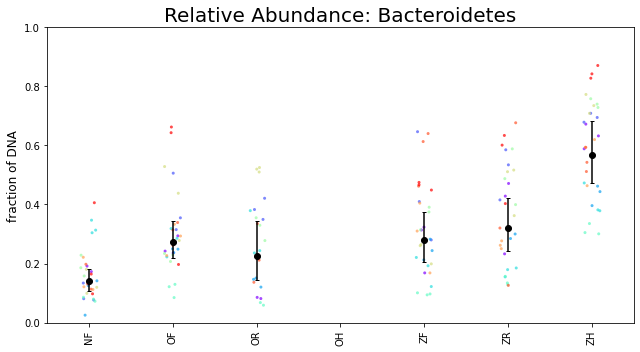

In [540]:
plt.figure(figsize=(12,8))

ii = 0
for pp in set(df.Patient):
    df_temp = df[df.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Sample_Type', y=feature, data=df_temp, 
                  order = ['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'],
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii)
    ii += 1
    #sns.swarmplot('Sample_Type', 'entropy', data=df_temp, jitter=0.2)
    

temp = preds
data = temp.groupby('Sample_Type')[['mean', 'err_low', 'err_high']].mean().reindex(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder = 12)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 13)

plt.title('Relative Abundance: Bacteroidetes' , fontsize=20)

plt.xlabel('', fontsize=12)
plt.ylabel('fraction of DNA', fontsize=12)

#plt.yscale('log')
plt.ylim([0, 1])

plt.tight_layout()
#fig1=plt.show()

#plt.ylim([0,1])

plt.savefig('temp.jpg')


In [541]:
#Ratio

df2 = df.copy()
df2['ratio'] = df['Relative Abundance: Bacteroidetes'] / df['Relative Abundance: Firmicutes']
df2['frac'] = df['Relative Abundance: Bacteroidetes'] / (df['Relative Abundance: Bacteroidetes'] + df['Relative Abundance: Firmicutes'])

feature = 'frac'



df_temp = df2[[feature, 'Sample_Type', 'Patient']].copy()
df_temp['feature'] = np.log(df_temp[feature])
df_temp['log_feature'] = np.log(df_temp[feature])

mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'ZF\'))',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 log_feature   No. Observations:                  171
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                  15
                      Estimating Equations   Max. cluster size:                  18
Family:                           Gaussian   Mean cluster size:                17.1
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Thu, 01 Sep 2022   Scale:                           0.121
Covariance type:                    robust   Time:                         13:45:46
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -0.8639      0.094     -9.159      0.000      -1.049      -0.679
C(Sample_Type, Treatment(reference='ZF'))[T.NF]    -0.5888      0.106     -5.556      0.000      -0.796      -0.381
C(Sample_Type, Treatment(reference='ZF'))[T.OF]     0.0177      0.101      0.176      0.861      -0.180       0.215
C(Sample_Type, Treatment(reference='ZF'))[T.OR]    -0.0004      0.153     -0.003      0.998      -0.301       0.300
C(Sample_Type, Treatment(reference='ZF'))[T.ZH]     0.5990      0.095      6.278      0.000       0.412       0.786
C(Sample_Type, Treatment(reference='ZF'))[T.ZR]     0.2093      0.105      1.990      0.047       0.003       0.415
==============================================================================
Skew:                         -0.4981   Kurtosis:                       0.3386
Centered skew:                -0.5012   Centered kurtosis:              1.5082
==============================================================================
"""

In [542]:
ref = pd.DataFrame(['NF', 'OF', 'OR',  'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

#preds['mean'] = preds['mean']
#preds['err_high'] =  preds.mean_ci_upper - preds['mean']
#preds['err_low'] = preds['mean'] -  preds.mean_ci_lower


#preds['mean'] = np.exp(preds['mean'])
#preds['err_high'] =  np.exp(preds.mean_ci_upper) - preds['mean']
#preds['err_low'] = preds['mean'] -  np.exp(preds.mean_ci_lower)


preds['mean'] = np.exp(preds['mean']) / (1 - np.exp(preds['mean']))
preds['mean_ci_upper'] = np.exp(preds['mean_ci_upper']) / (1 - np.exp(preds['mean_ci_upper']))
preds['mean_ci_lower'] = np.exp(preds['mean_ci_lower']) / (1 - np.exp(preds['mean_ci_lower']))
preds['err_high'] =  preds.mean_ci_upper - preds['mean']
preds['err_low'] = preds['mean'] -  preds.mean_ci_lower

In [543]:
preds

Sample_Type      mean   mean_se  mean_ci_lower  mean_ci_upper  err_high  \
0          NF  0.305399  0.101669       0.237138       0.399656  0.094257   
1          OF  0.751427  0.099595       0.545488       1.089948  0.338521   
2          OR  0.728096  0.135064       0.477838       1.217391  0.489294   
3          ZF  0.728660  0.094324       0.539336       1.028861  0.300201   
4          ZR  1.081731  0.060924       0.855782       1.412752  0.331021   
5          ZH  3.297470  0.041596       2.415665       4.969488  1.672017   

    err_low  
0  0.068261  
1  0.205940  
2  0.250258  
3  0.189323  
4  0.225949  
5  0.881805

In [544]:
feature

'frac'

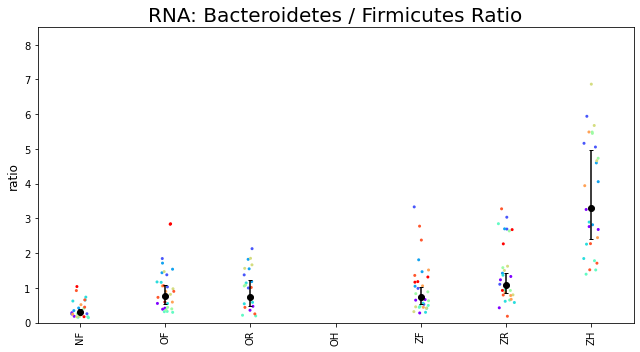

In [545]:
plt.figure(figsize=(12,8))

feature = 'ratio'

ii = 0
for pp in set(df.Patient):
    df_temp = df2[df2.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Sample_Type', y=feature, data=df_temp, 
                  order = ['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'],
                  s=3, alpha=1, color = colors[ii], zorder = 1 + ii)
    ii += 1
    #sns.swarmplot('Sample_Type', 'entropy', data=df_temp, jitter=0.2)
    

temp = preds
data = temp.groupby('Sample_Type')[['mean', 'err_low', 'err_high']].mean().reindex(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder = 12)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 13)

plt.title('RNA: Bacteroidetes / Firmicutes Ratio' , fontsize=20)

plt.xlabel('', fontsize=12)
plt.ylabel('ratio', fontsize=12)

#plt.yscale('log')
plt.ylim([0, 8.5])

plt.tight_layout()
#fig1=plt.show()

#plt.ylim([0,1])

plt.savefig('temp.jpg')


In [546]:
#primary outcomes

In [547]:
df['Relative Abundance: Unclassified + Root'] = df['Relative Abundance: Unclassified'] + df['Relative Abundance: Root']

In [548]:
export_cols = ['RNAConcentration',
    'Relative Abundance: Firmicutes', 'Relative Abundance: Bacteroidetes',
       'Relative Abundance: Actinobacteria',
       'Relative Abundance: Other Bacteria', 
    'Relative Abundance: Viruses',
       'Relative Abundance: Fungi',
               'Relative Abundance: Unclassified + Root',
    'Relative Abundance: Unclassified','Richness 0.01%', 'Richness 0.001%', 'Richness 0.0001%',
       'Richness 0.00001%', 'Richness Any%', 'Shannon Entropy', 'Inv Simpson']
df[['Patient', 'Sample_Type', 'Replication'] + export_cols].sort_index().to_csv('raw_data_rna.csv')

In [549]:
#do them all 

features = export_cols

df_kit_effects = pd.DataFrame([], columns = ['feature', 'OF', 'OF_annot', 'p_OF', 'ZF', 'ZF_annot', 'p_ZF'])
df_temp_effects_O = pd.DataFrame([], columns = ['feature', 'OR', 'OR_annot', 'p_OR'])
df_temp_effects_Z = pd.DataFrame([], columns = ['feature', 'ZR', 'ZR_annot', 'p_ZR', 'ZH', 'ZH_annot', 'p_ZH'])
df_preds = pd.DataFrame([], columns = ['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high'])

i = 0

for feature in features:
    print(feature)

    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = df_temp[df_temp[feature]>0].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])
    

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()
    
    ref = pd.DataFrame(['NF', 'OF', 'OR', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])
    preds = pd.concat([ref, est.get_prediction(ref).summary_frame(alpha=.05)], axis=1)
    preds['prediction'] = np.exp(preds['mean'])
    preds['CI_high'] =  np.exp(preds.mean_ci_upper)
    preds['CI_low'] = np.exp(preds.mean_ci_lower)
    preds['feature'] = feature
    
    df_preds = pd.concat([df_preds, preds[['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high']]])

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'NF\'))[T.OF]',
            'C(Sample_Type, Treatment(reference=\'NF\'))[T.ZF]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_kit_effects.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0],                    
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0],
        temp[temp.feature == cols[1]].p.values[0], ]
    
    
    ref = pd.DataFrame(['NF', 'OF', 'OR', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])


    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = df_temp[df_temp[feature]>0].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'OF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'OF\'))[T.OR]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_O.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0]]



    df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = df_temp[df_temp[feature]>0].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'ZF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZR]',
            'C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))

    df_temp_effects_Z.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0],                    
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0],
        temp[temp.feature == cols[1]].p.values[0], ]

    i += 1

RNAConcentration
Relative Abundance: Firmicutes
Relative Abundance: Bacteroidetes
Relative Abundance: Actinobacteria
Relative Abundance: Other Bacteria
Relative Abundance: Viruses
Relative Abundance: Fungi
Relative Abundance: Unclassified + Root
Relative Abundance: Unclassified
Richness 0.01%
Richness 0.001%
Richness 0.0001%
Richness 0.00001%
Richness Any%
Shannon Entropy
Inv Simpson


In [550]:
df_preds.to_csv('temp.csv')

In [551]:
df_kit_effects

feature         OF  \
0                          RNAConcentration -85.722704   
1            Relative Abundance: Firmicutes -23.890527   
2         Relative Abundance: Bacteroidetes  96.885597   
3        Relative Abundance: Actinobacteria -22.705908   
4        Relative Abundance: Other Bacteria  65.438674   
5               Relative Abundance: Viruses -43.708967   
6                 Relative Abundance: Fungi -29.001588   
7   Relative Abundance: Unclassified + Root  -5.391376   
8          Relative Abundance: Unclassified  -5.327059   
9                            Richness 0.01%  -7.673888   
10                          Richness 0.001% -16.341936   
11                         Richness 0.0001% -13.255159   
12                        Richness 0.00001%   6.080735   
13                            Richness Any%   9.488468   
14                          Shannon Entropy  -1.456536   
15                              Inv Simpson  -7.343124   

                       OF_annot   p_OF         ZF  \
0   -85.7% [-92.1%, -74.2%] ***  0.000 -94.511809   
1    -23.9% [-36.7%, -8.4%] **   0.004 -20.885174   
2     96.9% [47.6%, 162.6%] ***  0.000  99.615318   
3     -22.7% [-41.4%, 1.9%]      0.067 -47.294297   
4     65.4% [15.9%, 136.1%] **   0.006  41.997175   
5    -43.7% [-65.9%, -7.1%] *    0.025 -69.791136   
6     -29.0% [-51.1%, 3.1%]      0.072 -55.923159   
7     -5.4% [-18.9%, 10.4%]      0.480  10.068620   
8     -5.3% [-18.8%, 10.4%]      0.485  10.752984   
9      -7.7% [-17.4%, 3.2%]      0.159 -10.054965   
10   -16.3% [-27.2%, -3.8%] *    0.012 -20.590296   
11   -13.3% [-20.4%, -5.5%] ***  0.001 -16.803685   
12      6.1% [-0.5%, 13.1%]      0.071  13.381449   
13       9.5% [1.0%, 18.6%] *    0.027  19.465864   
14    -1.5% [-13.0%, 11.6%]      0.817   0.989236   
15    -7.3% [-30.3%, 23.2%]      0.599  -4.590736   

                       ZF_annot   p_ZF  
0   -94.5% [-95.5%, -93.3%] ***  0.000  
1    -20.9% [-33.6%, -5.8%] **   0.009  
2     99.6% [39.0%, 186.6%] ***  0.000  
3   -47.3% [-64.6%, -21.6%] **   0.002  
4    42.0% [-10.5%, 125.2%]      0.136  
5   -69.8% [-86.0%, -34.8%] **   0.002  
6    -55.9% [-78.6%, -9.3%] *    0.026  
7     10.1% [-19.4%, 50.2%]      0.546  
8     10.8% [-18.7%, 50.8%]      0.517  
9    -10.1% [-29.0%, 14.0%]      0.380  
10    -20.6% [-37.0%, 0.1%]      0.051  
11   -16.8% [-24.8%, -8.0%] ***  0.000  
12      13.4% [4.5%, 23.0%] **   0.003  
13      19.5% [8.6%, 31.4%] ***  0.000  
14     1.0% [-10.1%, 13.4%]      0.868  
15    -4.6% [-27.8%, 26.1%]      0.741

In [552]:
df[df.Sample_Type == 'ZF'][features].mean() *100

RNAConcentration                             1070.600000
Relative Abundance: Firmicutes                 37.690202
Relative Abundance: Bacteroidetes              31.661427
Relative Abundance: Actinobacteria              2.051835
Relative Abundance: Other Bacteria              7.743194
Relative Abundance: Viruses                     5.457546
Relative Abundance: Fungi                       0.473432
Relative Abundance: Unclassified + Root        14.895878
Relative Abundance: Unclassified               14.800015
Richness 0.01%                              11016.666667
Richness 0.001%                             37486.666667
Richness 0.0001%                           112000.000000
Richness 0.00001%                          224076.666667
Richness Any%                              245063.333333
Shannon Entropy                               262.234254
Inv Simpson                                   699.736876
dtype: float64

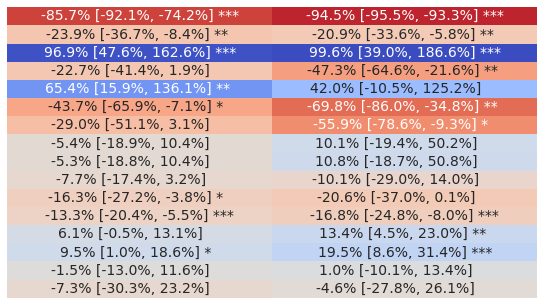

In [553]:
fig, ax = plt.subplots(figsize=(2*4.75,0.9 * 2*2.97)) 

sns.heatmap(-df_kit_effects[['OF', 'ZF']]
              , robust=True, annot = df_kit_effects[['OF_annot', 'ZF_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

In [556]:
df_temp_effects_Z

feature         ZR  \
0                          RNAConcentration  -5.376037   
1            Relative Abundance: Firmicutes -23.856381   
2         Relative Abundance: Bacteroidetes  15.215021   
3        Relative Abundance: Actinobacteria  -8.565241   
4        Relative Abundance: Other Bacteria  25.051804   
5               Relative Abundance: Viruses  31.660280   
6                 Relative Abundance: Fungi  12.279699   
7   Relative Abundance: Unclassified + Root  -2.166064   
8          Relative Abundance: Unclassified  -2.282601   
9                            Richness 0.01%  -2.320187   
10                          Richness 0.001%  -3.100301   
11                         Richness 0.0001%  -5.251528   
12                        Richness 0.00001%  -4.895925   
13                            Richness Any%  -3.390931   
14                          Shannon Entropy  -7.472844   
15                              Inv Simpson -18.874073   

                      ZR_annot   p_ZR          ZH  \
0    -5.4% [-26.6%, 22.0%]      0.670  161.942444   
1   -23.9% [-36.9%, -8.2%] **   0.004  -58.519690   
2     15.2% [-5.8%, 40.9%]      0.168  103.896881   
3    -8.6% [-31.4%, 21.8%]      0.541  -53.592594   
4     25.1% [10.3%, 41.8%] ***  0.000   68.539491   
5     31.7% [-7.8%, 88.0%]      0.130   18.049849   
6      12.3% [3.2%, 22.1%] **   0.007  230.243705   
7      -2.2% [-9.7%, 6.0%]      0.593  -33.921358   
8      -2.3% [-9.9%, 6.0%]      0.577  -35.338172   
9     -2.3% [-10.1%, 6.1%]      0.578   -1.052778   
10    -3.1% [-11.3%, 5.8%]      0.485    7.385575   
11    -5.3% [-12.3%, 2.3%]      0.169    2.085756   
12    -4.9% [-9.2%, -0.4%] *    0.032  -18.473214   
13     -3.4% [-7.7%, 1.2%]      0.141  -24.178003   
14    -7.5% [-14.4%, 0.0%]      0.051  -29.858766   
15  -18.9% [-33.1%, -1.7%] *    0.033  -47.950597   

                       ZH_annot   p_ZH  
0    161.9% [86.0%, 268.8%] ***  0.000  
1   -58.5% [-72.5%, -37.5%] ***  0.000  
2    103.9% [66.5%, 149.7%] ***  0.000  
3   -53.6% [-75.9%, -10.7%] *    0.021  
4     68.5% [30.9%, 117.0%] ***  0.000  
5     18.0% [-29.9%, 98.9%]      0.533  
6   230.2% [103.2%, 436.7%] ***  0.000  
7   -33.9% [-49.4%, -13.6%] **   0.002  
8   -35.3% [-50.9%, -14.9%] **   0.002  
9     -1.1% [-18.0%, 19.4%]      0.912  
10     7.4% [-12.2%, 31.3%]      0.488  
11      2.1% [-9.2%, 14.8%]      0.731  
12  -18.5% [-22.2%, -14.5%] ***  0.000  
13  -24.2% [-27.1%, -21.1%] ***  0.000  
14  -29.9% [-44.7%, -11.1%] **   0.003  
15  -48.0% [-62.7%, -27.4%] ***  0.000

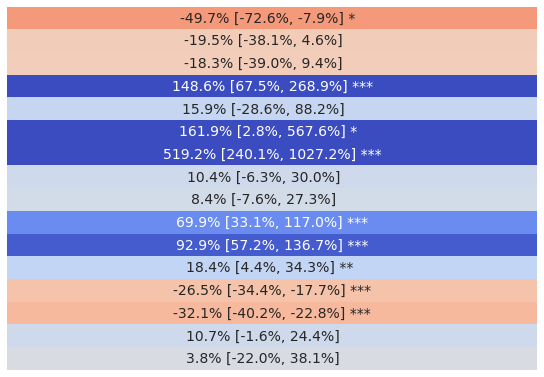

In [554]:
fig, ax = plt.subplots(figsize=(2*4.75,0.9 * 10/8*2*2.97)) 

sns.heatmap(-df_temp_effects_O[['OR']]
              , robust=True, annot = df_temp_effects_O[['OR_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

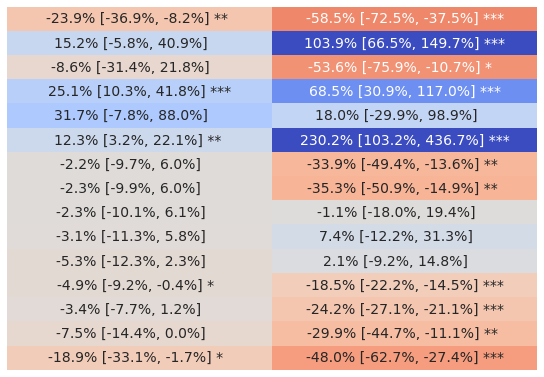

In [86]:
fig, ax = plt.subplots(figsize=(2*4.75,0.9 * 10/8*2*2.97)) 

sns.heatmap(-df_temp_effects_Z[['ZR', 'ZH']]
              , robust=True, annot = df_temp_effects_Z[['ZR_annot', 'ZH_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=False, xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 

fig.savefig('temp.pdf', bbox_inches='tight')

In [68]:
#richness plots

In [107]:
feature = 'Richness 0.01%'

df_temp = df[[feature, 'Sample_Type', 'Patient']].copy()
df_temp['log_feature'] = np.log(df_temp[feature])

mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 log_feature   No. Observations:                  171
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                  15
                      Estimating Equations   Max. cluster size:                  18
Family:                           Gaussian   Mean cluster size:                17.1
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Mon, 22 Aug 2022   Scale:                           0.162
Covariance type:                    robust   Time:                         14:22:37
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                           4.7011      0.094     49.978      0.000       4.517       4.886
C(Sample_Type, Treatment(reference='NF'))[T.OF]    -0.0798      0.057     -1.408      0.159      -0.191       0.031
C(Sample_Type, Treatment(reference='NF'))[T.OR]     0.4505      0.112      4.012      0.000       0.230       0.671
C(Sample_Type, Treatment(reference='NF'))[T.ZF]    -0.1060      0.121     -0.878      0.380      -0.343       0.131
C(Sample_Type, Treatment(reference='NF'))[T.ZH]    -0.1166      0.146     -0.799      0.424      -0.403       0.169
C(Sample_Type, Treatment(reference='NF'))[T.ZR]    -0.1294      0.134     -0.964      0.335      -0.393       0.134
==============================================================================
Skew:                          0.8613   Kurtosis:                       1.1530
Centered skew:                 1.1559   Centered kurtosis:              3.9406
==============================================================================
"""

In [108]:
ref = pd.DataFrame(['NF', 'OF', 'OR', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['mean'] = np.exp(preds['mean'])
preds['err_high'] =  np.exp(preds.mean_ci_upper) - preds['mean']
preds['err_low'] = preds['mean'] -  np.exp(preds.mean_ci_lower)

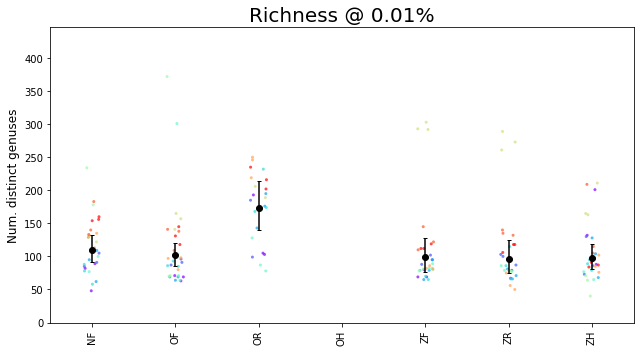

In [109]:
plt.figure(figsize=(12,8))

ii = 0
for pp in set(df.Patient):
    df_temp = df[df.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Sample_Type', y=feature, data=df_temp, 
                  order = ['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'],
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii)
    ii += 1
    #sns.swarmplot('Sample_Type', 'entropy', data=df_temp, jitter=0.2)
    

temp = preds
data = temp.groupby('Sample_Type')[['mean', 'err_low', 'err_high']].mean().reindex(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder = 12)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 13)

plt.title('Richness @ 0.01%' , fontsize=20)

plt.xlabel('', fontsize=12)
plt.ylabel('Num. distinct genuses', fontsize=12)

#plt.yscale('log')
plt.ylim([0, df[feature].max()*1.2])

plt.tight_layout()
#fig1=plt.show()

#plt.ylim([0,1])

plt.savefig('temp.jpg')


In [82]:
#genus-level results

In [455]:
df_rel_genus['Patient'] = df_rel_genus.index.str.split('-').str[0]
df_rel_genus['Sample_Type'] = df_rel_genus.index.str.split('-').str[1]
df_rel_genus['Replication'] = df_rel_genus.index.str.split('-').str[2]

In [456]:
df_temp = pd.DataFrame(df_rel_genus[df_rel_genus.Sample_Type == 'NF'].mean()).rename(columns={0:'Avg'})
df_temp['phylum'] = df_temp.index.str.split(':').str[0]
df_temp['name'] = df_temp.index
genera_to_study  = df_temp[df_temp.Avg > 0.0001].sort_values(by=['phylum', 'Avg']).name.values

In [457]:
genera_to_study

array(['Acidobacteria: unclassified Acidobacteria',
       'Actinobacteria: Rothia',
       'Actinobacteria: unclassified Actinobacteria (class) (miscellaneous)',
       'Actinobacteria: Micrococcus', 'Actinobacteria: Lawsonella',
       'Actinobacteria: Microbacterium', 'Actinobacteria: Olsenella',
       'Actinobacteria: Actinomadura', 'Actinobacteria: Mycobacterium',
       'Actinobacteria: Pseudarthrobacter', 'Actinobacteria: Rhodococcus',
       'Actinobacteria: Coriobacteriaceae: environmental samples',
       'Actinobacteria: unclassified Eggerthellales',
       'Actinobacteria: Actinomyces', 'Actinobacteria: Raoultibacter',
       'Actinobacteria: unclassified Coriobacteriia',
       'Actinobacteria: Cutibacterium',
       'Actinobacteria: unclassified Coriobacteriaceae',
       'Actinobacteria: Streptomyces', 'Actinobacteria: Corynebacterium',
       'Actinobacteria: Parolsenella', 'Actinobacteria: Gordonibacter',
       'Actinobacteria: Enterorhabdus', 'Actinobacteria: Eggert

In [138]:
#genera_to_study = [
#'Firmicutes: Faecalibacterium',
#'Firmicutes: unclassified Clostridiales (miscellaneous)',
#'Firmicutes: Firmicutes: environmental samples',
#'Firmicutes: unclassified Ruminococcaceae',
#'Firmicutes: Ruminococcus',
#'Firmicutes: Clostridium',
#'Firmicutes: Roseburia',
#'Firmicutes: Oscillibacter',
#'Firmicutes: Butyricicoccus',
#'Firmicutes: Clostridiales: environmental samples',
#'Firmicutes: Coprococcus',
#'Firmicutes: unclassified Lachnospiraceae',
#'Firmicutes: Megamonas',
#'Firmicutes: Gemmiger',
#'Firmicutes: Eubacterium',
#'Firmicutes: unclassified Oscillospiraceae',
#'Firmicutes: unclassified Firmicutes sensu stricto (miscellaneous)',
#'Firmicutes: Subdoligranulum',
#'Firmicutes: Flavonifractor',
#'Firmicutes: Blautia',
#'Firmicutes: Dialister',
#'Firmicutes: Dorea',
#'Firmicutes: Streptococcus',
#'Firmicutes: Lachnoclostridium',
#'Firmicutes: Megasphaera',
#'Firmicutes: Neglecta',
#'Firmicutes: Intestinimonas',
#'Firmicutes: Lachnospiraceae: environmental samples',
#'Firmicutes: unclassified Clostridiaceae',
#'Firmicutes: Anaerotruncus',
#'Firmicutes: Candidatus Borkfalkia',
#'Bacteroidetes: Bacteroides',
#'Bacteroidetes: Alistipes',
#'Bacteroidetes: Prevotella',
#'Bacteroidetes: Parabacteroides',
#'Bacteroidetes: Odoribacter',
#'Bacteroidetes: Butyricimonas',
#'Bacteroidetes: unclassified Rikenellaceae',
#'Bacteroidetes: Prevotellaceae: environmental samples',
#'Actinobacteria: Collinsella',
#'Actinobacteria: Bifidobacterium',
#'Actinobacteria: Enterorhabdus',
#'Actinobacteria: Eggerthella',
#'Proteobacteria: Azospirillum',
#'Proteobacteria: Sutterella',
#'Proteobacteria: Bilophila',
#'Lentisphaerae: unclassified Lentisphaeria',
#'Basidiomycota: Malassezia',
#'null: Tobamovirus',
#'null: Viruses: environmental samples',
#'Verrucomicrobia: Akkermansia']

In [458]:
#10 patients, 21 samples each
df_rel_genus.groupby('Patient').size()

Patient
D01    18
D02    17
D03    18
D04    17
D05    15
D06    18
D07    18
D08    18
D09    17
D10    15
dtype: int64

In [459]:
#7 Sample Types, 30 samples each
df_rel_genus.groupby('Sample_Type').size()

Sample_Type
NF    30
OF    30
OR    22
ZF    30
ZH    30
ZR    29
dtype: int64

In [460]:
#3 Replications for each
df_rel_genus.groupby('Replication').size()

Replication
R1    56
R2    58
R3    57
dtype: int64

In [464]:
df_rel_genus[['Patient', 'Sample_Type', 'Replication'] + list(genera_to_study)].sort_index().to_csv('temp.csv')

In [471]:
#do them all 

df_kit_effects = pd.DataFrame([], columns = ['feature', 'OF', 'OF_annot', 'p_OF', 'ZF', 'ZF_annot', 'p_ZF'])
df_temp_effects_O = pd.DataFrame([], columns = ['feature', 'OR', 'OR_annot', 'p_OR'])
df_temp_effects_Z = pd.DataFrame([], columns = ['feature', 'ZR', 'ZR_annot', 'p_ZR', 'ZH', 'ZH_annot', 'p_ZH'])
df_preds = pd.DataFrame([], columns = ['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high'])

i = 0

for feature in genera_to_study:
    print(feature)

    df_temp = df_rel_genus[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = df_temp[df_temp[feature]>0].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])
    

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'NF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()
    
    ref = pd.DataFrame(['NF', 'OF', 'OR', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])
    preds = pd.concat([ref, est.get_prediction(ref).summary_frame(alpha=.05)], axis=1)
    preds['prediction'] = np.exp(preds['mean'])
    preds['CI_high'] =  np.exp(preds.mean_ci_upper)
    preds['CI_low'] = np.exp(preds.mean_ci_lower)
    preds['feature'] = feature
    
    df_preds = pd.concat([df_preds, preds[['feature', 'Sample_Type', 'prediction', 'CI_low', 'CI_high']]])

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'NF\'))[T.OF]',
            'C(Sample_Type, Treatment(reference=\'NF\'))[T.ZF]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  
    df_kit_effects.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0],                    
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0],
        temp[temp.feature == cols[1]].p.values[0], ]
    
    
    ref = pd.DataFrame(['NF', 'OF', 'OR', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])


    df_temp = df_rel_genus[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = df_temp[df_temp[feature]>0].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'OF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'OF\'))[T.OR]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] ' 

    df_temp_effects_O.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0]]



    df_temp = df_rel_genus[[feature, 'Sample_Type', 'Patient']].copy()
    df_temp = df_temp[df_temp[feature]>0].copy()
    df_temp['log_feature'] = np.log(df_temp[feature])

    mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'ZF\'))',
                  'Patient',
                  df_temp,
                  cov_struct=sm.cov_struct.Exchangeable(),
                  family=sm.families.Gaussian())

    est = mod.fit()

    bins = [-1, 0.001, 0.01, 0.05, np.inf]
    names = ['***', '** ', '*  ', '   ']


    cols = ['C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZR]',
            'C(Sample_Type, Treatment(reference=\'ZF\'))[T.ZH]' ]

    temp = pd.DataFrame()
    temp['feature'] = cols
    temp['estimate'] = 100 * (np.exp( np.array(est.params[cols])) -1)
    temp['low'] = 100 * (np.exp(np.array(est.conf_int()[0][cols])) -1)
    temp['high'] = 100 * (np.exp(np.array(est.conf_int()[1][cols])) -1)
    temp['p'] = list(pd.read_html(est.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
    temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] ' 

    df_temp_effects_Z.loc[i] = [feature,
        temp[temp.feature == cols[0]].estimate.values[0],
        temp[temp.feature == cols[0]].annot.values[0],
        temp[temp.feature == cols[0]].p.values[0],                    
        temp[temp.feature == cols[1]].estimate.values[0],
        temp[temp.feature == cols[1]].annot.values[0],
        temp[temp.feature == cols[1]].p.values[0], ]

    i += 1

Acidobacteria: unclassified Acidobacteria
Actinobacteria: Rothia
Actinobacteria: unclassified Actinobacteria (class) (miscellaneous)
Actinobacteria: Micrococcus
Actinobacteria: Lawsonella
Actinobacteria: Microbacterium
Actinobacteria: Olsenella
Actinobacteria: Actinomadura
Actinobacteria: Mycobacterium
Actinobacteria: Pseudarthrobacter
Actinobacteria: Rhodococcus
Actinobacteria: Coriobacteriaceae: environmental samples
Actinobacteria: unclassified Eggerthellales
Actinobacteria: Actinomyces
Actinobacteria: Raoultibacter
Actinobacteria: unclassified Coriobacteriia
Actinobacteria: Cutibacterium
Actinobacteria: unclassified Coriobacteriaceae
Actinobacteria: Streptomyces
Actinobacteria: Corynebacterium
Actinobacteria: Parolsenella
Actinobacteria: Gordonibacter
Actinobacteria: Enterorhabdus
Actinobacteria: Eggerthella
Actinobacteria: Bifidobacterium
Actinobacteria: Collinsella
Ascomycota: Chaetosphaerella
Ascomycota: Fusarium
Ascomycota: Aspergillus
Ascomycota: Scortechinia
Ascomycota: Echin

In [472]:
df_preds.to_csv('temp.csv')

In [473]:
from statsmodels.stats import multitest

In [474]:
test_list = df_preds[(df_preds.prediction > 0.001)].feature.drop_duplicates().values

In [475]:
test_list = df_preds[(df_preds.prediction > 0.001)].feature.drop_duplicates().values

df_temp = df_preds[(df_preds.feature.isin(test_list)) & (df_preds.Sample_Type == 'NF')][['feature', 'prediction']]
df_temp['phylum'] = df_temp.feature.str.split(':').str[0]
df_temp['genus'] = df_temp.feature.str.split(':').str[1]

df_t1 = df_kit_effects[['feature', 'OF', 'OF_annot', 'p_OF']].rename(columns = {'OF': 'change', 'OF_annot': 'annot', 'p_OF': 'p'})
df_t1['comp'] = 'OF'
df_t2 = df_kit_effects[['feature', 'ZF', 'ZF_annot', 'p_ZF']].rename(columns = {'ZF': 'change', 'ZF_annot': 'annot', 'p_ZF': 'p'})
df_t2['comp'] = 'ZF'

df_tt = pd.concat([df_t1, df_t2], axis=0)
df_tt.sort_values(by='p', inplace=True)
df_tt['BH'] = multitest.fdrcorrection(df_tt.p, alpha=0.10, method='indep', is_sorted=True)[0].astype(int)
df_tt['annot'] = df_tt['annot'] + list(pd.cut(df_tt['BH'], [-2, 0.5, 2], labels=['  ', ' *']))

df_t1 = df_tt[df_tt.comp == 'OF'][['feature', 'change', 'annot']].rename(columns = {'annot': 'OF_annot', 'change':'OF'})
df_t2 = df_tt[df_tt.comp == 'ZF'][['feature', 'change', 'annot']].rename(columns = {'annot': 'ZF_annot', 'change':'ZF'})

df_kit_effects = pd.merge(pd.merge(df_temp, df_t1, on='feature'), df_t2, on='feature')[['feature', 'phylum', 'genus', 'prediction', 'OF', 'OF_annot', 'ZF', 'ZF_annot']].rename(columns={'prediction': 'Avg Rel. Abundance (NF)'})

In [476]:
df_kit_effects 

feature          phylum  \
0                       Actinobacteria: Cutibacterium  Actinobacteria   
1                     Actinobacteria: Corynebacterium  Actinobacteria   
2                       Actinobacteria: Enterorhabdus  Actinobacteria   
3                         Actinobacteria: Eggerthella  Actinobacteria   
4                     Actinobacteria: Bifidobacterium  Actinobacteria   
5                         Actinobacteria: Collinsella  Actinobacteria   
6           Bacteroidetes: unclassified Rikenellaceae   Bacteroidetes   
7                          Bacteroidetes: Odoribacter   Bacteroidetes   
8                      Bacteroidetes: Parabacteroides   Bacteroidetes   
9                           Bacteroidetes: Prevotella   Bacteroidetes   
10                           Bacteroidetes: Alistipes   Bacteroidetes   
11                         Bacteroidetes: Bacteroides   Bacteroidetes   
12                          Basidiomycota: Malassezia   Basidiomycota   
13                         Firmicutes: Staphylococcus      Firmicutes   
14                              Firmicutes: Weissella      Firmicutes   
15  Firmicutes: Lachnospiraceae: environmental sam...      Firmicutes   
16            Firmicutes: unclassified Clostridiaceae      Firmicutes   
17                          Firmicutes: Streptococcus      Firmicutes   
18                                  Firmicutes: Dorea      Firmicutes   
19                      Firmicutes: Lachnoclostridium      Firmicutes   
20                          Firmicutes: Anaerotruncus      Firmicutes   
21                         Firmicutes: Intestinimonas      Firmicutes   
22                                Firmicutes: Blautia      Firmicutes   
23                        Firmicutes: Subdoligranulum      Firmicutes   
24                            Firmicutes: Eubacterium      Firmicutes   
25  Firmicutes: unclassified Firmicutes sensu stri...      Firmicutes   
26           Firmicutes: unclassified Lachnospiraceae      Firmicutes   
27                            Firmicutes: Coprococcus      Firmicutes   
28                               Firmicutes: Gemmiger      Firmicutes   
29          Firmicutes: unclassified Oscillospiraceae      Firmicutes   
30                         Firmicutes: Flavonifractor      Firmicutes   
31   Firmicutes: Clostridiales: environmental samples      Firmicutes   
32                         Firmicutes: Butyricicoccus      Firmicutes   
33                           Firmicutes: Ruminococcus      Firmicutes   
34                          Firmicutes: Oscillibacter      Firmicutes   
35                            Firmicutes: Clostridium      Firmicutes   
36                              Firmicutes: Roseburia      Firmicutes   
37      Firmicutes: Firmicutes: environmental samples      Firmicutes   
38           Firmicutes: unclassified Ruminococcaceae      Firmicutes   
39  Firmicutes: unclassified Clostridiales (miscel...      Firmicutes   
40                       Firmicutes: Faecalibacterium      Firmicutes   
41                       Proteobacteria: Sphingomonas  Proteobacteria   
42                   Proteobacteria: Methylobacterium  Proteobacteria   
43                          Proteobacteria: Pelomonas  Proteobacteria   
44                        Proteobacteria: Pseudomonas  Proteobacteria   
45                          Proteobacteria: Bilophila  Proteobacteria   
46                         Proteobacteria: Sutterella  Proteobacteria   
47               null: Viruses: environmental samples            null   
48                                  null: Tobamovirus            null   

                                                genus  \
0                                       Cutibacterium   
1                                     Corynebacterium   
2                                       Enterorhabdus   
3                                         Eggerthella   
4                                     Bifidobacterium   
5                                         Collinsella

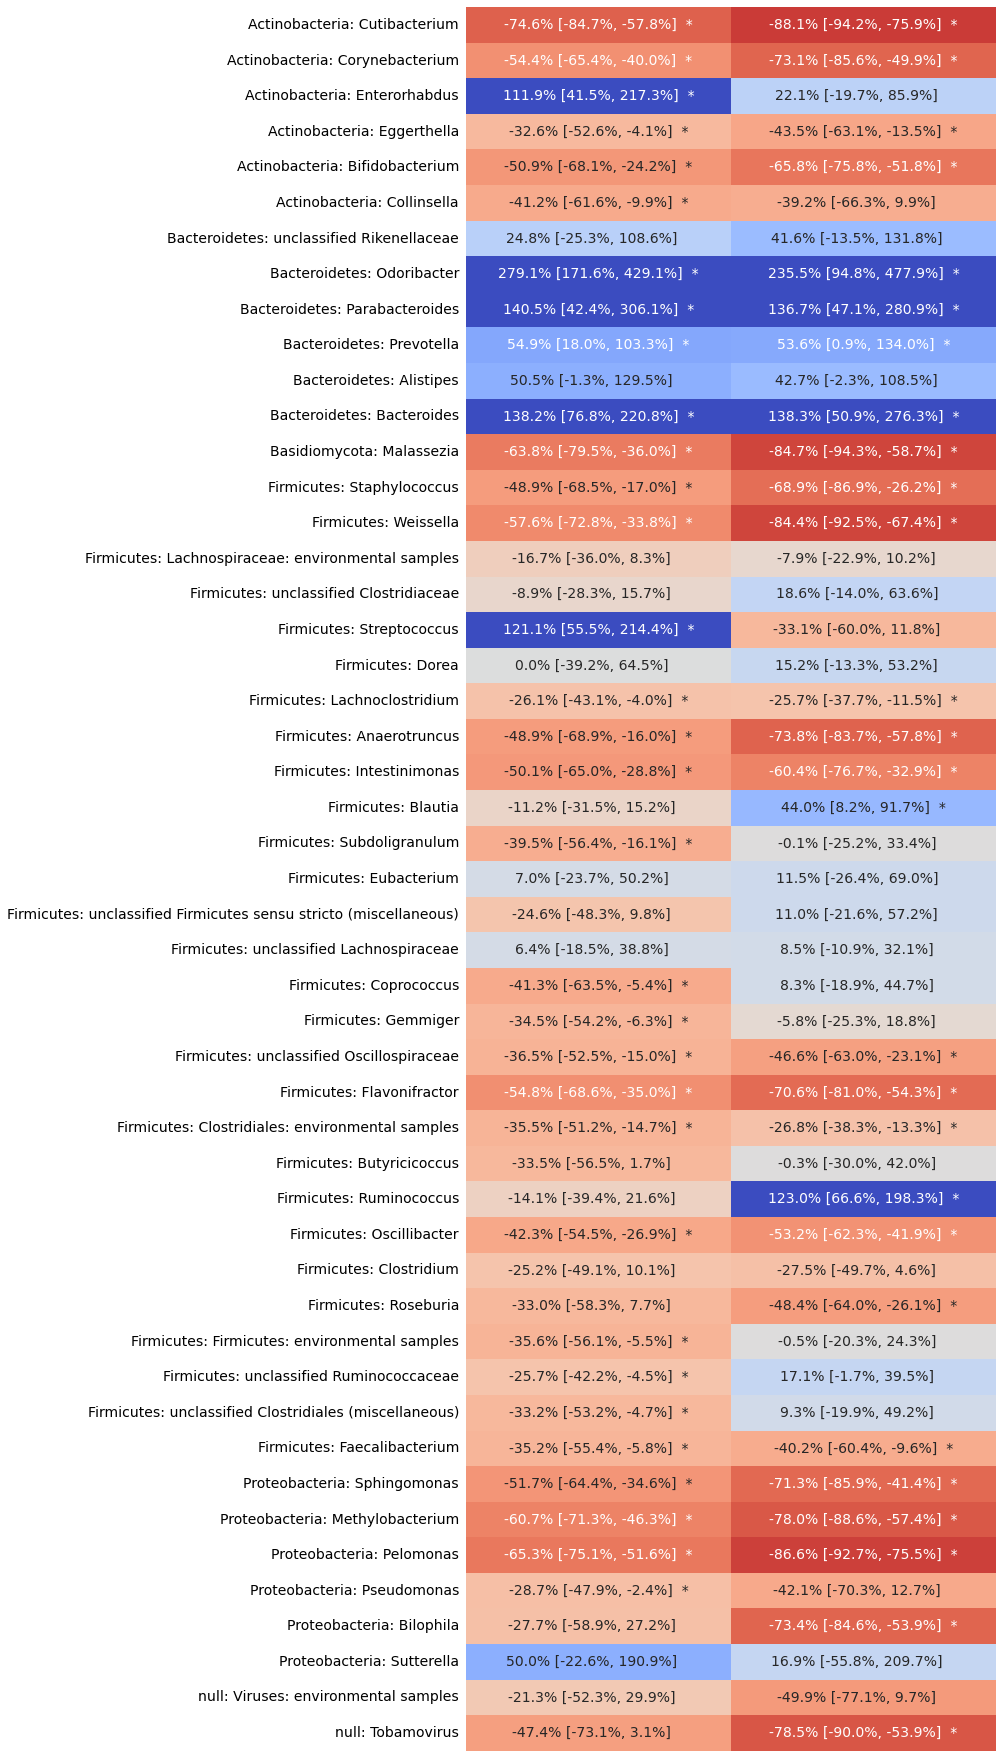

In [477]:
fig, ax = plt.subplots(figsize=(2*4.75, 5.4* 2*2.97)) 

sns.heatmap(-df_kit_effects[['OF', 'ZF']]
              , robust=True, annot = df_kit_effects[['OF_annot', 'ZF_annot']], 
            cbar=False, cmap = "coolwarm",  fmt = '',
                annot_kws={'size':14}, vmin=-100, vmax=100,
            yticklabels=df_kit_effects.feature, 
            #label_kws={'size':14},
            xticklabels=False, ax=ax)
ax.tick_params(left=False, bottom=False) 
ax.set_yticklabels(labels = df_kit_effects.feature, fontsize=14)

fig.savefig('temp.jpg', bbox_inches='tight')

In [479]:
#test_list = df_preds[(df_preds.prediction > 0.001)].feature.drop_duplicates().values

df_temp = df_preds[(df_preds.feature.isin(test_list)) & (df_preds.Sample_Type == 'OF')][['feature', 'prediction']]
df_temp['phylum'] = df_temp.feature.str.split(':').str[0]
df_temp['genus'] = df_temp.feature.str.split(':').str[1]

df_t1 = df_temp_effects_O[['feature', 'OR', 'OR_annot', 'p_OR']].rename(columns = {'OR': 'change', 'OR_annot': 'annot', 'p_OR': 'p'})
df_t1['comp'] = 'OR'
#df_t2 = df_temp_effects_O[['feature', 'OH', 'OH_annot', 'p_OH']].rename(columns = {'OH': 'change', 'OH_annot': 'annot', 'p_OH': 'p'})
#df_t2['comp'] = 'OH'

df_tt = df_t1# pd.concat([df_t1, df_t2], axis=0)
df_tt.sort_values(by='p', inplace=True)
df_tt['BH'] = multitest.fdrcorrection(df_tt.p, alpha=0.05, method='indep', is_sorted=True)[0].astype(int)
df_tt['annot'] = df_tt['annot'] + list(pd.cut(df_tt['BH'], [-2, 0.5, 2], labels=['  ', ' *']))

df_t1 = df_tt[df_tt.comp == 'OR'][['feature', 'change', 'annot']].rename(columns = {'annot': 'OR_annot', 'change':'OR'})
#df_t2 = df_tt[df_tt.comp == 'OH'][['feature', 'change', 'annot']].rename(columns = {'annot': 'OH_annot', 'change':'OH'})

df_temp_effects_O = pd.merge(df_temp, df_t1, on='feature')[['feature', 'phylum', 'genus', 'prediction', 'OR', 'OR_annot']].rename(columns={'prediction': 'Avg Rel. Abundance (OF)'})

In [480]:
df_temp_effects_O

feature          phylum  \
0                       Actinobacteria: Cutibacterium  Actinobacteria   
1                     Actinobacteria: Corynebacterium  Actinobacteria   
2                       Actinobacteria: Enterorhabdus  Actinobacteria   
3                         Actinobacteria: Eggerthella  Actinobacteria   
4                     Actinobacteria: Bifidobacterium  Actinobacteria   
5                         Actinobacteria: Collinsella  Actinobacteria   
6           Bacteroidetes: unclassified Rikenellaceae   Bacteroidetes   
7                          Bacteroidetes: Odoribacter   Bacteroidetes   
8                      Bacteroidetes: Parabacteroides   Bacteroidetes   
9                           Bacteroidetes: Prevotella   Bacteroidetes   
10                           Bacteroidetes: Alistipes   Bacteroidetes   
11                         Bacteroidetes: Bacteroides   Bacteroidetes   
12                          Basidiomycota: Malassezia   Basidiomycota   
13                         Firmicutes: Staphylococcus      Firmicutes   
14                              Firmicutes: Weissella      Firmicutes   
15  Firmicutes: Lachnospiraceae: environmental sam...      Firmicutes   
16            Firmicutes: unclassified Clostridiaceae      Firmicutes   
17                          Firmicutes: Streptococcus      Firmicutes   
18                                  Firmicutes: Dorea      Firmicutes   
19                      Firmicutes: Lachnoclostridium      Firmicutes   
20                          Firmicutes: Anaerotruncus      Firmicutes   
21                         Firmicutes: Intestinimonas      Firmicutes   
22                                Firmicutes: Blautia      Firmicutes   
23                        Firmicutes: Subdoligranulum      Firmicutes   
24                            Firmicutes: Eubacterium      Firmicutes   
25  Firmicutes: unclassified Firmicutes sensu stri...      Firmicutes   
26           Firmicutes: unclassified Lachnospiraceae      Firmicutes   
27                            Firmicutes: Coprococcus      Firmicutes   
28                               Firmicutes: Gemmiger      Firmicutes   
29          Firmicutes: unclassified Oscillospiraceae      Firmicutes   
30                         Firmicutes: Flavonifractor      Firmicutes   
31   Firmicutes: Clostridiales: environmental samples      Firmicutes   
32                         Firmicutes: Butyricicoccus      Firmicutes   
33                           Firmicutes: Ruminococcus      Firmicutes   
34                          Firmicutes: Oscillibacter      Firmicutes   
35                            Firmicutes: Clostridium      Firmicutes   
36                              Firmicutes: Roseburia      Firmicutes   
37      Firmicutes: Firmicutes: environmental samples      Firmicutes   
38           Firmicutes: unclassified Ruminococcaceae      Firmicutes   
39  Firmicutes: unclassified Clostridiales (miscel...      Firmicutes   
40                       Firmicutes: Faecalibacterium      Firmicutes   
41                       Proteobacteria: Sphingomonas  Proteobacteria   
42                   Proteobacteria: Methylobacterium  Proteobacteria   
43                          Proteobacteria: Pelomonas  Proteobacteria   
44                        Proteobacteria: Pseudomonas  Proteobacteria   
45                          Proteobacteria: Bilophila  Proteobacteria   
46                         Proteobacteria: Sutterella  Proteobacteria   
47               null: Viruses: environmental samples            null   
48                                  null: Tobamovirus            null   

                                                genus  \
0                                       Cutibacterium   
1                                     Corynebacterium   
2                                       Enterorhabdus   
3                                         Eggerthella   
4                                     Bifidobacterium   
5                                         Collinsella

In [481]:
#test_list = df_preds[(df_preds.prediction > 0.001)].feature.drop_duplicates().values

df_temp = df_preds[(df_preds.feature.isin(test_list)) & (df_preds.Sample_Type == 'ZF')][['feature', 'prediction']]
df_temp['phylum'] = df_temp.feature.str.split(':').str[0]
df_temp['genus'] = df_temp.feature.str.split(':').str[1]

df_t1 = df_temp_effects_Z[['feature', 'ZR', 'ZR_annot', 'p_ZR']].rename(columns = {'ZR': 'change', 'ZR_annot': 'annot', 'p_ZR': 'p'})
df_t1['comp'] = 'ZR'
df_t2 = df_temp_effects_Z[['feature', 'ZH', 'ZH_annot', 'p_ZH']].rename(columns = {'ZH': 'change', 'ZH_annot': 'annot', 'p_ZH': 'p'})
df_t2['comp'] = 'ZH'

df_tt = pd.concat([df_t1, df_t2], axis=0)
df_tt.sort_values(by='p', inplace=True)
df_tt['BH'] = multitest.fdrcorrection(df_tt.p, alpha=0.10, method='indep', is_sorted=True)[0].astype(int)
df_tt['annot'] = df_tt['annot'] + list(pd.cut(df_tt['BH'], [-2, 0.5, 2], labels=['  ', ' *']))

df_t1 = df_tt[df_tt.comp == 'ZR'][['feature', 'change', 'annot']].rename(columns = {'annot': 'ZR_annot', 'change':'ZR'})
df_t2 = df_tt[df_tt.comp == 'ZH'][['feature', 'change', 'annot']].rename(columns = {'annot': 'ZH_annot', 'change':'ZH'})

df_temp_effects_Z = pd.merge(pd.merge(df_temp, df_t1, on='feature'), df_t2, on='feature')[['feature', 'phylum', 'genus', 'prediction', 'ZR', 'ZR_annot', 'ZH', 'ZH_annot']].rename(columns={'prediction': 'Avg Rel. Abundance (ZF)'})

In [482]:
df_temp_effects_Z

feature          phylum  \
0                       Actinobacteria: Cutibacterium  Actinobacteria   
1                     Actinobacteria: Corynebacterium  Actinobacteria   
2                       Actinobacteria: Enterorhabdus  Actinobacteria   
3                         Actinobacteria: Eggerthella  Actinobacteria   
4                     Actinobacteria: Bifidobacterium  Actinobacteria   
5                         Actinobacteria: Collinsella  Actinobacteria   
6           Bacteroidetes: unclassified Rikenellaceae   Bacteroidetes   
7                          Bacteroidetes: Odoribacter   Bacteroidetes   
8                      Bacteroidetes: Parabacteroides   Bacteroidetes   
9                           Bacteroidetes: Prevotella   Bacteroidetes   
10                           Bacteroidetes: Alistipes   Bacteroidetes   
11                         Bacteroidetes: Bacteroides   Bacteroidetes   
12                          Basidiomycota: Malassezia   Basidiomycota   
13                         Firmicutes: Staphylococcus      Firmicutes   
14                              Firmicutes: Weissella      Firmicutes   
15  Firmicutes: Lachnospiraceae: environmental sam...      Firmicutes   
16            Firmicutes: unclassified Clostridiaceae      Firmicutes   
17                          Firmicutes: Streptococcus      Firmicutes   
18                                  Firmicutes: Dorea      Firmicutes   
19                      Firmicutes: Lachnoclostridium      Firmicutes   
20                          Firmicutes: Anaerotruncus      Firmicutes   
21                         Firmicutes: Intestinimonas      Firmicutes   
22                                Firmicutes: Blautia      Firmicutes   
23                        Firmicutes: Subdoligranulum      Firmicutes   
24                            Firmicutes: Eubacterium      Firmicutes   
25  Firmicutes: unclassified Firmicutes sensu stri...      Firmicutes   
26           Firmicutes: unclassified Lachnospiraceae      Firmicutes   
27                            Firmicutes: Coprococcus      Firmicutes   
28                               Firmicutes: Gemmiger      Firmicutes   
29          Firmicutes: unclassified Oscillospiraceae      Firmicutes   
30                         Firmicutes: Flavonifractor      Firmicutes   
31   Firmicutes: Clostridiales: environmental samples      Firmicutes   
32                         Firmicutes: Butyricicoccus      Firmicutes   
33                           Firmicutes: Ruminococcus      Firmicutes   
34                          Firmicutes: Oscillibacter      Firmicutes   
35                            Firmicutes: Clostridium      Firmicutes   
36                              Firmicutes: Roseburia      Firmicutes   
37      Firmicutes: Firmicutes: environmental samples      Firmicutes   
38           Firmicutes: unclassified Ruminococcaceae      Firmicutes   
39  Firmicutes: unclassified Clostridiales (miscel...      Firmicutes   
40                       Firmicutes: Faecalibacterium      Firmicutes   
41                       Proteobacteria: Sphingomonas  Proteobacteria   
42                   Proteobacteria: Methylobacterium  Proteobacteria   
43                          Proteobacteria: Pelomonas  Proteobacteria   
44                        Proteobacteria: Pseudomonas  Proteobacteria   
45                          Proteobacteria: Bilophila  Proteobacteria   
46                         Proteobacteria: Sutterella  Proteobacteria   
47               null: Viruses: environmental samples            null   
48                                  null: Tobamovirus            null   

                                                genus  \
0                                       Cutibacterium   
1                                     Corynebacterium   
2                                       Enterorhabdus   
3                                         Eggerthella   
4                                     Bifidobacterium   
5                                         Collinsella

In [154]:
#beta diversity

In [155]:
from skbio.diversity import alpha_diversity
from skbio.diversity import get_alpha_diversity_metrics
from skbio.diversity import beta_diversity
from skbio.diversity import get_beta_diversity_metrics

In [156]:
genera = list(df_rel_genus.columns[:-3])

In [157]:
df_temp = df_rel_genus[df_rel_genus.Patient.isin(['D01'])][genera].copy()
bc_dm = beta_diversity('braycurtis', df_temp)
bc_dm.ids = list(df_temp.index)

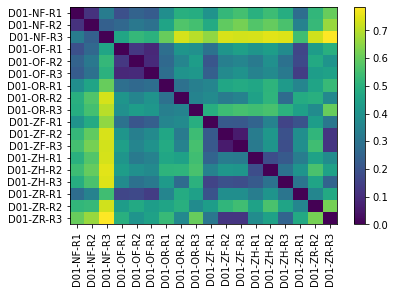

In [158]:
bc_dm

In [159]:
df_bc = pd.DataFrame([], columns = ['Patient', 'Protocol_1', 'Protocol_2', 'bcdist'])
zz = 0

for pp in np.sort(list(set(df.Patient))):
    print(pp)
    df_temp = df_rel_genus[df_rel_genus.Patient == pp][genera].copy().sort_index()
    bc_dm = beta_diversity('braycurtis', df_temp)
    bc_dm.ids = list(df_temp.index)

    for ii in range(bc_dm.shape[0]):
        for jj in range(bc_dm.shape[0]):
            if ii != jj:
                protocol_1 = df_temp.index[ii].split('-')[1]
                protocol_2 = df_temp.index[jj].split('-')[1]
                bc = bc_dm[ii,jj]
                
                df_bc.loc[zz] = [pp, protocol_1, protocol_2, bc]
                zz += 1

D01
D02
D03
D04
D05
D06
D07
D08
D09
D10


In [160]:
df_bc['Protocols'] = df_bc['Protocol_1'] + '_' +  df_bc['Protocol_2']

In [161]:
df_bc.to_csv('temp.csv')

<AxesSubplot:>

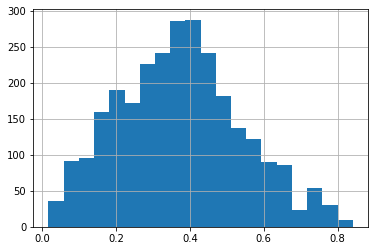

In [162]:
df_bc.bcdist.hist(bins=20)

In [163]:
df_bc['log_dist'] = np.log(df_bc.bcdist)

mod = smf.gee('log_dist ~ C(Protocols, Treatment(reference=\'NF_NF\'))',
              'Patient',
              df_bc,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                    log_dist   No. Observations:                 2766
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                 210
                      Estimating Equations   Max. cluster size:                 306
Family:                           Gaussian   Mean cluster size:               276.6
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Mon, 22 Aug 2022   Scale:                           0.154
Covariance type:                    robust   Time:                         14:40:49
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -1.7965      0.152    -11.800      0.000      -2.095      -1.498
C(Protocols, Treatment(reference='NF_NF'))[T.NF_OF]     0.7228      0.108      6.694      0.000       0.511       0.934
C(Protocols, Treatment(reference='NF_NF'))[T.NF_OR]     1.0239      0.138      7.413      0.000       0.753       1.295
C(Protocols, Treatment(reference='NF_NF'))[T.NF_ZF]     0.7962      0.122      6.543      0.000       0.558       1.035
C(Protocols, Treatment(reference='NF_NF'))[T.NF_ZH]     1.2817      0.119     10.789      0.000       1.049       1.515
C(Protocols, Treatment(reference='NF_NF'))[T.NF_ZR]     1.0150      0.135      7.516      0.000       0.750       1.280
C(Protocols, Treatment(reference='NF_NF'))[T.OF_NF]     0.7228      0.108      6.694      0.000       0.511       0.934
C(Protocols, Treatment(reference='NF_NF'))[T.OF_OF]    -0.0962      0.171     -0.564      0.573      -0.431       0.238
C(Protocols, Treatment(reference='NF_NF'))[T.OF_OR]     0.8924      0.180      4.950      0.000       0.539       1.246
C(Protocols, Treatment(reference='NF_NF'))[T.OF_ZF]     0.4563      0.164      2.778      0.005       0.134       0.778
C(Protocols, Treatment(reference='NF_NF'))[T.OF_ZH]     0.8264      0.192      4.297      0.000       0.449       1.203
C(Protocols, Treatment(reference='NF_NF'))[T.OF_ZR]     0.5107      0.206      2.483      0.013       0.108       0.914
C(Protocols, Treatment(reference='NF_NF'))[T.OR_NF]     1.0239      0.138      7.413      0.000       0.753       1.295
C(Protocols, Treatment(reference='NF_NF'))[T.OR_OF]     0.8924      0.180      4.950      0.000       0.539       1.246
C(Protocols, Treatment(reference='NF_NF'))[T.OR_OR]    -0.0154      0.202     -0.077      0.939      -0.411       0.380
C(Protocols, Treatment(reference='NF_NF'))[T.OR_ZF]     0.9974      0.171      5.821      0.000       0.662       1.333
C(Protocols, Treatment(reference='NF_NF'))[T.OR_ZH]     1.0774      0.175      6.152      0.000       0.734       1.421
C(Protocols, Treatment(reference='NF_NF'))[T.OR_ZR]     0.9161      0.221      4.148      0.000       0.483       1.349
C(Protocols, Treatment(reference='NF_NF'))[T.ZF_NF]     0.7962      0.122      6.543      0.000       0.558       1.035
C(Protocols, Treatment(reference='NF_NF'))[T.ZF_OF]     0.4563      0.164      2.778      0.005       0.134       0.778
C(Protocols, Treatment(reference='NF_NF'))[T.ZF_OR]     0.9974      0.171      5.821      0.000       0.662       1.333
C(Protocols, Treatment(reference='NF_NF'))[T.ZF_ZF]    -0.3318      0.211     -1.570      0.116      -0.746       0.082
C(Protocols, Treatment(reference='NF_NF'))[T.ZF_ZH]     0.7932      0.173      4.580      0.000       0.454     

In [164]:
ref = pd.DataFrame(set(df_bc.Protocols), columns=['Protocols'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['estimate'] = np.exp(preds['mean'])
preds['CI_low'] = np.exp(preds.mean_ci_lower)
preds['CI_high'] = np.exp(preds.mean_ci_upper)

preds['mean'] =  np.exp(preds['mean'])
preds['err_high'] = preds.CI_high - preds['mean']
preds['err_low'] = preds['mean'] - preds.CI_low


In [176]:
preds.sort_values(by='Protocols').to_csv('temp.csv')

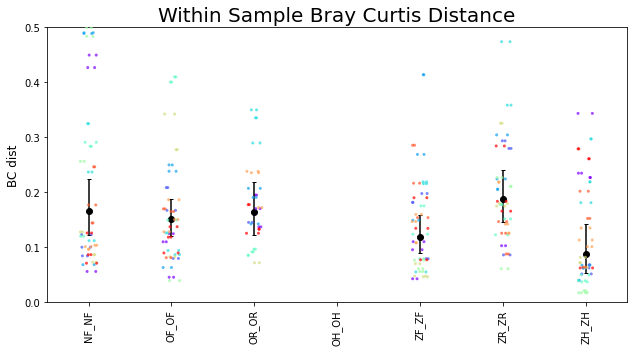

In [165]:
plt.figure(figsize=(12,8))

ii = 0
for pp in set(df.Patient):
    df_temp = df_bc[df_bc.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Protocols', y='bcdist', data=df_temp, 
                  order = ['NF_NF', 'OF_OF', 'OR_OR', 'OH_OH', 'ZF_ZF', 'ZR_ZR', 'ZH_ZH'],
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii)
    ii += 1

temp = preds
data = temp.groupby('Protocols')[['mean', 'err_low', 'err_high']].mean().reindex(['NF_NF', 'OF_OF', 'OR_OR', 'OH_OH', 'ZF_ZF', 'ZR_ZR', 'ZH_ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder=1)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 0)

plt.title('Within Sample Bray Curtis Distance', fontsize=20)
#plt.ylim([0,1])
plt.xlabel('', fontsize=12)
plt.ylabel('BC dist', fontsize=12)
plt.tight_layout()

plt.ylim([0,0.5])

plt.savefig('temp.jpg')


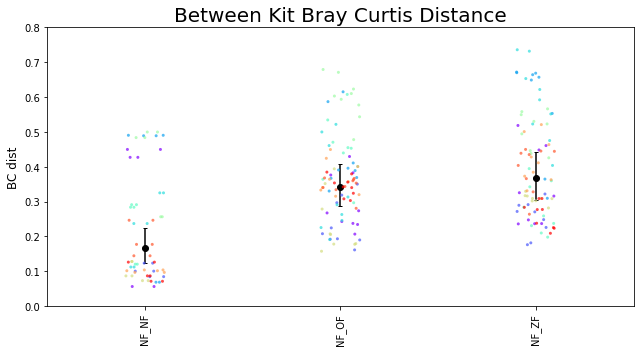

In [169]:
plt.figure(figsize=(12,8))

ii = 0
for pp in set(df.Patient):
    df_temp = df_bc[df_bc.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Protocols', y='bcdist', data=df_temp, 
                  order = ['NF_NF', 'NF_OF', 'NF_ZF'],
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii)
    ii += 1

temp = preds
data = temp.groupby('Protocols')[['mean', 'err_low', 'err_high']].mean().reindex(['NF_NF', 'NF_OF', 'NF_ZF'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder=1)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 0)

plt.title('Between Kit Bray Curtis Distance', fontsize=20)
#plt.ylim([0,1])
plt.xlabel('', fontsize=12)
plt.ylabel('BC dist', fontsize=12)
plt.tight_layout()

plt.ylim([0,0.8])
plt.savefig('temp.jpg')

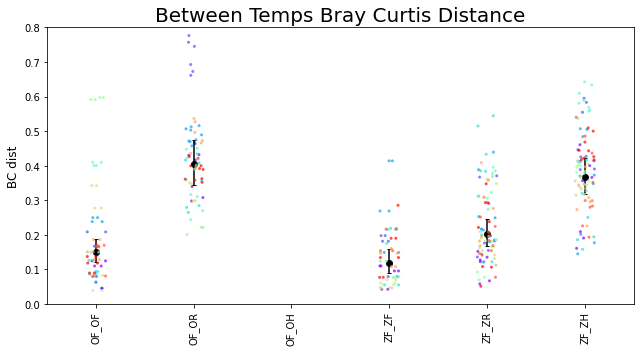

In [172]:
plt.figure(figsize=(12,8))

order = ['OF_OF', 'OF_OR', 'OF_OH', 'ZF_ZF', 'ZF_ZR', 'ZF_ZH']

ii = 0
for pp in set(df.Patient):
    df_temp = df_bc[df_bc.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Protocols', y='bcdist', data=df_temp, 
                  order = order,
                  s=3, alpha=0.7, color = colors[ii], zorder = 1 + ii)
    ii += 1

temp = preds
data = temp.groupby('Protocols')[['mean', 'err_low', 'err_high']].mean().reindex(order)
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder=1)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 1)

plt.title('Between Temps Bray Curtis Distance', fontsize=20)
#plt.ylim([0,1])
plt.xlabel('', fontsize=12)
plt.ylabel('BC dist', fontsize=12)
plt.tight_layout()

plt.ylim([0,0.8])
plt.savefig('temp.jpg')

In [178]:
cols = ['C(Protocols, Treatment(reference=\'NF_NF\'))[T.OF_OF]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.OR_OR]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.ZF_ZF]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.ZR_ZR]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.ZH_ZH]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.NF_OF]',
        'C(Protocols, Treatment(reference=\'NF_NF\'))[T.NF_ZF]']

temp = pd.DataFrame()
temp['feature'] = cols
temp['estimate'] = 100 * (np.exp( np.array(res.params[cols])) -1)
temp['low'] = 100 * (np.exp(np.array(res.conf_int()[0][cols])) -1)
temp['high'] = 100 * (np.exp(np.array(res.conf_int()[1][cols])) -1)
temp['p'] = list(pd.read_html(res.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))
temp

feature    estimate        low  \
0  C(Protocols, Treatment(reference='NF_NF'))[T.O...   -9.174587 -34.986042   
1  C(Protocols, Treatment(reference='NF_NF'))[T.O...   -1.532865 -33.679753   
2  C(Protocols, Treatment(reference='NF_NF'))[T.Z...  -28.236320 -52.570536   
3  C(Protocols, Treatment(reference='NF_NF'))[T.Z...   13.165565 -24.727106   
4  C(Protocols, Treatment(reference='NF_NF'))[T.Z...  -47.154433 -72.584492   
5  C(Protocols, Treatment(reference='NF_NF'))[T.N...  106.013681  66.719793   
6  C(Protocols, Treatment(reference='NF_NF'))[T.N...  121.716103  74.666817   

         high      p                       annot  
0   26.884379  0.573   -9.2% [-35.0%, 26.9%]      
1   46.196329  0.939   -1.5% [-33.7%, 46.2%]      
2    8.582838  0.116   -28.2% [-52.6%, 8.6%]      
3   70.133555  0.552   13.2% [-24.7%, 70.1%]      
4    1.864024  0.057   -47.2% [-72.6%, 1.9%]      
5  154.568676  0.000  106.0% [66.7%, 154.6%] ***  
6  181.438864  0.000  121.7% [74.7%, 181.4%] ***

In [181]:
df_bc['log_dist'] = np.log(df_bc.bcdist)

mod = smf.gee('log_dist ~ C(Protocols, Treatment(reference=\'OF_OF\'))',
              'Patient',
              df_bc,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()

cols = ['C(Protocols, Treatment(reference=\'OF_OF\'))[T.OF_OR]']

temp = pd.DataFrame()
temp['feature'] = cols
temp['estimate'] = 100 * (np.exp( np.array(res.params[cols])) -1)
temp['low'] = 100 * (np.exp(np.array(res.conf_int()[0][cols])) -1)
temp['high'] = 100 * (np.exp(np.array(res.conf_int()[1][cols])) -1)
temp['p'] = list(pd.read_html(res.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))
temp

feature    estimate        low  \
0  C(Protocols, Treatment(reference='OF_OF'))[T.O...  168.761341  98.390627   

         high    p                       annot  
0  264.093101  0.0  168.8% [98.4%, 264.1%] ***

In [182]:
df_bc['log_dist'] = np.log(df_bc.bcdist)

mod = smf.gee('log_dist ~ C(Protocols, Treatment(reference=\'ZF_ZF\'))',
              'Patient',
              df_bc,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()

cols = ['C(Protocols, Treatment(reference=\'ZF_ZF\'))[T.ZF_ZR]',
        'C(Protocols, Treatment(reference=\'ZF_ZF\'))[T.ZF_ZH]']

temp = pd.DataFrame()
temp['feature'] = cols
temp['estimate'] = 100 * (np.exp( np.array(res.params[cols])) -1)
temp['low'] = 100 * (np.exp(np.array(res.conf_int()[0][cols])) -1)
temp['high'] = 100 * (np.exp(np.array(res.conf_int()[1][cols])) -1)
temp['p'] = list(pd.read_html(res.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))
temp

feature    estimate         low  \
0  C(Protocols, Treatment(reference='ZF_ZF'))[T.Z...   70.135436   28.421383   
1  C(Protocols, Treatment(reference='ZF_ZF'))[T.Z...  208.017279  120.177514   

         high    p                        annot  
0  125.399119  0.0    70.1% [28.4%, 125.4%] ***  
1  330.900698  0.0  208.0% [120.2%, 330.9%] ***

In [183]:
df_bc['log_dist'] = np.log(df_bc.bcdist)

mod = smf.gee('log_dist ~ C(Protocols, Treatment(reference=\'ZF_NF\'))',
              'Patient',
              df_bc,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()

cols = ['C(Protocols, Treatment(reference=\'ZF_NF\'))[T.OF_NF]',
        'C(Protocols, Treatment(reference=\'ZF_NF\'))[T.ZR_NF]',
        'C(Protocols, Treatment(reference=\'ZF_NF\'))[T.ZH_NF]',]

temp = pd.DataFrame()
temp['feature'] = cols
temp['estimate'] = 100 * (np.exp( np.array(res.params[cols])) -1)
temp['low'] = 100 * (np.exp(np.array(res.conf_int()[0][cols])) -1)
temp['high'] = 100 * (np.exp(np.array(res.conf_int()[1][cols])) -1)
temp['p'] = list(pd.read_html(res.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))
temp

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1831: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


feature   estimate        low  \
0  C(Protocols, Treatment(reference='ZF_NF'))[T.O...  -7.082220 -22.737118   
1  C(Protocols, Treatment(reference='ZF_NF'))[T.Z...  24.458321  10.855260   
2  C(Protocols, Treatment(reference='ZF_NF'))[T.Z...  62.494257  34.276299   

        high      p                      annot  
0  11.744652  0.435  -7.1% [-22.7%, 11.7%]      
1  39.730615  0.000   24.5% [10.9%, 39.7%] ***  
2  96.642177  0.000   62.5% [34.3%, 96.6%] ***

In [185]:
df_bc['log_dist'] = np.log(df_bc.bcdist)

mod = smf.gee('log_dist ~ C(Protocols, Treatment(reference=\'OF_NF\'))',
              'Patient',
              df_bc,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()

cols = ['C(Protocols, Treatment(reference=\'OF_NF\'))[T.OR_NF]']

temp = pd.DataFrame()
temp['feature'] = cols
temp['estimate'] = 100 * (np.exp( np.array(res.params[cols])) -1)
temp['low'] = 100 * (np.exp(np.array(res.conf_int()[0][cols])) -1)
temp['high'] = 100 * (np.exp(np.array(res.conf_int()[1][cols])) -1)
temp['p'] = list(pd.read_html(res.summary().tables[1].as_html(), header=0, index_col=0)[0].loc[cols, 'P>|z|'])
temp['annot'] = np.round(temp.estimate,1).astype(str) + '% [' + np.round(temp.low,1).astype(str) + '%, ' + np.round(temp.high,1).astype(str) +  '%] '  + list(pd.cut(temp['p'], bins, labels=names))
temp

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1831: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))


feature   estimate       low  \
0  C(Protocols, Treatment(reference='OF_NF'))[T.O...  35.132579  7.362568   

       high     p                    annot  
0  70.08548  0.01  35.1% [7.4%, 70.1%] **

In [ ]:
#dna / rna ratio

In [237]:
df_dna.rename(columns = {'Relative Abundance: Firmicutes': 'DNA: Firmicutes',
                         'Relative Abundance: Bacteroidetes': 'DNA: Bacteroidetes',
                         'Relative Abundance: Actinobacteria': 'DNA: Actinobacteria',
                           'Relative Abundance: Other Bacteria': 'DNA: Other Bacteria' ,
                        'Relative Abundance: Proteobacteria': 'DNA: Proteobacteria' }, inplace=True)
df_rna.rename(columns = {'Relative Abundance: Firmicutes': 'RNA: Firmicutes',
                         'Relative Abundance: Bacteroidetes': 'RNA: Bacteroidetes',
                         'Relative Abundance: Actinobacteria': 'RNA: Actinobacteria',
                           'Relative Abundance: Other Bacteria': 'RNA: Other Bacteria',
                         'Relative Abundance: Proteobacteria': 'RNA: Proteobacteria'  }, inplace=True)

df_rat = pd.merge(df_dna, df_rna, left_index=True, right_index=True)

#df_rat['Firmicutes'] = df_rat['DNA: Firmicutes']/

df_rat['Patient'] = df_rat.index.str.split('-').str[0]
df_rat['Sample_Type'] = df_rat.index.str.split('-').str[1]
df_rat['Replication'] = df_rat.index.str.split('-').str[2]

#df = df[(df.Patient.str[0] == 'D') & (df.Sample_Type.str[0].isin(['N', 'O', 'Z']))]

In [240]:
df_rat['DNA: Other Bacteria 2'] = (df_rat['DNA: Other Bacteria'] - df_rat['DNA: Proteobacteria'])
df_rat['RNA: Other Bacteria 2'] = (df_rat['RNA: Other Bacteria'] - df_rat['RNA: Proteobacteria'])

In [262]:
#Ratio

df2 = df_rat.copy()
feature = 'Bacteroidetes'
df2['ratio'] = df2['DNA: ' + feature] / df2['RNA: ' + feature]
df2['frac'] = df2['DNA: ' + feature] / (df2['DNA: ' + feature] + df2['RNA: ' + feature])

feature = 'frac'



df_temp = df2[[feature, 'Sample_Type', 'Patient']].copy()
df_temp['feature'] = np.log(df_temp[feature])
df_temp['log_feature'] = np.log(df_temp[feature])

mod = smf.gee('log_feature ~ C(Sample_Type, Treatment(reference=\'ZF\'))',
              'Patient',
              df_temp,
              cov_struct=sm.cov_struct.Exchangeable(),
              family=sm.families.Gaussian())

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 log_feature   No. Observations:                  170
Model:                                 GEE   No. clusters:                       10
Method:                        Generalized   Min. cluster size:                  15
                      Estimating Equations   Max. cluster size:                  18
Family:                           Gaussian   Mean cluster size:                17.0
Dependence structure:         Exchangeable   Num. iterations:                     4
Date:                     Mon, 29 Aug 2022   Scale:                           0.045
Covariance type:                    robust   Time:                         16:02:15
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -0.7588      0.049    -15.447      0.000      -0.855      -0.663
C(Sample_Type, Treatment(reference='ZF'))[T.NF]     0.1318      0.068      1.946      0.052      -0.001       0.264
C(Sample_Type, Treatment(reference='ZF'))[T.OF]     0.0836      0.044      1.881      0.060      -0.003       0.171
C(Sample_Type, Treatment(reference='ZF'))[T.OR]     0.1378      0.078      1.766      0.077      -0.015       0.291
C(Sample_Type, Treatment(reference='ZF'))[T.ZH]    -0.1781      0.049     -3.640      0.000      -0.274      -0.082
C(Sample_Type, Treatment(reference='ZF'))[T.ZR]    -0.0124      0.045     -0.278      0.781      -0.100       0.075
==============================================================================
Skew:                         -0.5219   Kurtosis:                       0.3870
Centered skew:                -0.1711   Centered kurtosis:              0.2291
==============================================================================
"""

In [255]:
ref = pd.DataFrame(['NF', 'OF', 'OR',  'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

#preds['mean'] = preds['mean']
#preds['err_high'] =  preds.mean_ci_upper - preds['mean']
#preds['err_low'] = preds['mean'] -  preds.mean_ci_lower


#preds['mean'] = np.exp(preds['mean'])
#preds['err_high'] =  np.exp(preds.mean_ci_upper) - preds['mean']
#preds['err_low'] = preds['mean'] -  np.exp(preds.mean_ci_lower)


preds['mean'] = np.exp(preds['mean']) / (1 - np.exp(preds['mean']))
preds['mean_ci_upper'] = np.exp(preds['mean_ci_upper']) / (1 - np.exp(preds['mean_ci_upper']))
preds['mean_ci_lower'] = np.exp(preds['mean_ci_lower']) / (1 - np.exp(preds['mean_ci_lower']))
preds['err_high'] =  preds.mean_ci_upper - preds['mean']
preds['err_low'] = preds['mean'] -  preds.mean_ci_lower

In [256]:
preds

Sample_Type      mean   mean_se  mean_ci_lower  mean_ci_upper  err_high  \
0          NF  1.146797  0.064354       0.889959       1.538079  0.391282   
1          OF  1.036898  0.042642       0.880551       1.239299  0.202401   
2          OR  1.161689  0.047556       0.959143       1.438410  0.276721   
3          ZF  0.880532  0.049123       0.739906       1.064234  0.183702   
4          ZR  0.860348  0.059950       0.698362       1.083885  0.223537   
5          ZH  0.644295  0.041156       0.566099       0.738385  0.094090   

    err_low  
0  0.256838  
1  0.156346  
2  0.202546  
3  0.140626  
4  0.161986  
5  0.078196

In [257]:
feature

'frac'

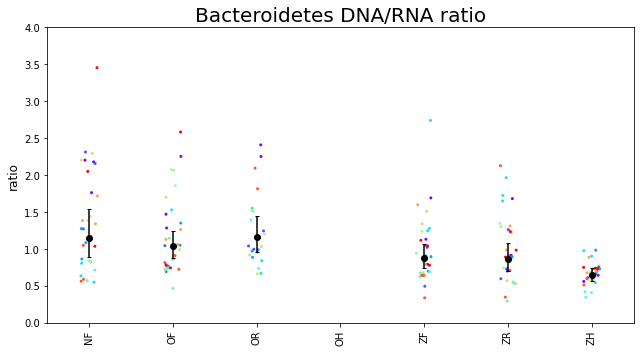

In [259]:
plt.figure(figsize=(12,8))

feature = 'ratio'

ii = 0
for pp in set(df2.Patient):
    df_temp = df2[df2.Patient==pp].copy()
    #plt.scatter(df_temp.Sample_Type , df_temp['Firmicutes'], s=3, alpha=0.5)
    sns.stripplot(x='Sample_Type', y=feature, data=df_temp, 
                  order = ['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'],
                  s=3, alpha=1, color = colors[ii], zorder = 1 + ii)
    ii += 1
    #sns.swarmplot('Sample_Type', 'entropy', data=df_temp, jitter=0.2)
    

temp = preds
data = temp.groupby('Sample_Type')[['mean', 'err_low', 'err_high']].mean().reindex(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'])
err = []
err.append([data['err_low'].values, data['err_high'].values])
#err.append([data[( 'err_low', 'test')].values, data[( 'err_high', 'test')].values])
data['mean'].plot(kind='bar', yerr=err, figsize=(9,5), capsize=2, alpha=0, zorder = 12)
plt.scatter(x=data.index, y=data['mean'], color='k', zorder = 13)

plt.title('Bacteroidetes DNA/RNA ratio' , fontsize=20)

plt.xlabel('', fontsize=12)
plt.ylabel('ratio', fontsize=12)

#plt.yscale('log')
plt.ylim([0, 4])

plt.tight_layout()
#fig1=plt.show()

#plt.ylim([0,1])

plt.savefig('temp.jpg')


In [ ]:
ref = pd.DataFrame(['NF', 'OF', 'OR', 'OH', 'ZF', 'ZR', 'ZH'], columns=['Sample_Type'])

preds = pd.concat([ref, res.get_prediction(ref).summary_frame(alpha=.05)], axis=1)

preds['% change'] = np.exp(preds['mean'])
preds['CI_high'] =  np.exp(preds.mean_ci_upper)
preds['CI_low'] = np.exp(preds.mean_ci_lower)
preds['feature'] = feature

